In [1]:
import psycopg2
import requests
import nbimporter
import datetime
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import Init_database as indb
import pdb
from calendar import monthrange
from googletrans import Translator

Importing Jupyter notebook from Init_database.ipynb


In [2]:
db_name="db_teld"
user_name="postgres"
password = "ecalscraping"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

# 1. Check connection to database

In [3]:
try:
    cur = conn.cursor()
    stmt1 = "select ST_AsText(location) from tbl_app_eachstations"
    cur.execute(stmt1)
    station_loc1 = cur.fetchall()
    stmt2 = "select ST_X(location), ST_Y(location) from tbl_app_eachstations"
    cur.execute(stmt2)
    station_loc2 = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print(station_loc1[0])
print(station_loc2[0])

('POINT(116.26327 39.863907)',)
(116.26327, 39.863907)


In [4]:
# #------- Request stationid which has user activities from db -------#
try:
    cur = conn.cursor()
    cur.execute("select distinct stationid from tbl_app_useractivity;")
    stationWithAct_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Number of stations with user activites: ", len(stationWithAct_list))
# #------- Request pilecode from db for states -------#
# staid_list = []
# for staid in stationWithAct_list:
#     staid_list.append(staid[0])
try:
    cur = conn.cursor()
#     sta_list = ['33a3c031-0a3a-417d-ba1b-53549bb08dc2']
    sta_list = ['2b3a35d4-cb94-4b8f-a47a-bbb054754066', '1d02640a-7f14-4fc3-baaf-60754a38fff7',
                'ac6cb946-5fff-491b-859e-55cc5f701657', 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66',
                'b134a159-16bd-4f5d-af1b-cd42599a3bab', '33a3c031-0a3a-417d-ba1b-53549bb08dc2', 
                'e4758edb-1183-4c51-887b-a52ca7abef3d', '13bdab71-110b-4448-a3c4-5c3113183546']
    #1. beijing hangkong jingmi jixie yanjiusuo chongdianzhan --'2b3a35d4-cb94-4b8f-a47a-bbb054754066',
    #2. beijing xijiao bingguan chongdianzhan -- '1d02640a-7f14-4fc3-baaf-60754a38fff7
    #3. beijing yangguanglicheng jiudian chongdianzhan --'ac6cb946-5fff-491b-859e-55cc5f701657',
    #4. beijing rongtao gongsi chongdianzhan -- '32d317a9-3d0c-4458-8357-89a2b3b1cf94'
    #5. beijing huairou qu yanshui lu -- 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'
    
    #6. shenzhen hengjiang dasha chongdianzhan -- 'b134a159-16bd-4f5d-af1b-cd42599a3bab'
    #7. shenzhen yinxing gongyeyuan chongdianzhan -- '33a3c031-0a3a-417d-ba1b-53549bb08dc2'
    #8. shenzhe wanke jiulongshan chongdianzhan -- 'e4758edb-1183-4c51-887b-a52ca7abef3d'
    #9. shenzhen jingyuan dasha chongdianzhan -- '13bdab71-110b-4448-a3c4-5c3113183546'
    stmt = "select pilecode from tbl_APP_pilecode where staid in %s"
    cur.execute(stmt, (tuple(sta_list),))
    
#     stmt = "select pilecode from tbl_APP_pilecode where staid = 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'"
#     cur.execute(stmt)
#     cur.execute("select pilecode from tbl_APP_pilecode")
    pillcode_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Nubmer of pills: ", len(pillcode_list))

('Number of stations with user activites: ', 5236)
('Nubmer of pills: ', 86)


In [23]:
# # #------- Request Shenzhen charging pilecode from db for states -------#
# try:
#     cur = conn.cursor()
# #     stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(115.37916, 39.47148, 117.15623, 40.81726, 4326);"    
#     stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(113.85955, 22.50563, 114.17335, 22.69960, 4326) intersect select distinct stationid from tbl_app_useractivity;"
#     cur.execute(stmt1)
#     sta_list = cur.fetchall()
#     sta_list_clean = []
#     for sta in sta_list:
#         sta_list_clean.append(sta[0])
# except psycopg2.Error as e:
#     print(e)
# print("Shenzhen stations: " + str(len(sta_list_clean)))

In [22]:
# # #------- Request QingDao charging pilecode from db for states -------#
# try:
#     cur = conn.cursor()
# #     stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(115.37916, 39.47148, 117.15623, 40.81726, 4326);"    
#     stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(119.410781, 35.592975, 120.892190, 37.189975, 4326) intersect select distinct stationid from tbl_app_useractivity;"
#     cur.execute(stmt1)
#     sta_list_qingdao = cur.fetchall()
#     sta_list_qingdao_clean = []
#     for sta in sta_list_qingdao:
#         sta_list_qingdao_clean.append(sta[0])
# except psycopg2.Error as e:
#     print(e)
# print("Qingdao stations: " + str(len(sta_list_qingdao_clean)))

# 2. Create a charing station object

In [5]:
class Station(object):
    "This is a station object"
    num_pills = 0
    def __init__(self, stationid, score, pricescore, servicescore, 
                 stationname, stationaddress, location):
        self.id = stationid
        self.score = score
        self.pricescore = pricescore
        self.servicescore = servicescore
        self.name = stationname
        self.addr = stationaddress
        self.GPS = location
        self.pills = []
        self.ult_data = []
    def add_Pill(self, pill_obj):
        self.pills.append(pill_obj)
        self.num_pills += 1
    def delete_numPills(self):
#         if self.pills >= 1:
#             self.pills -= 1
        pass
    def check_pill(self, pillcode):
        for pill in self.pills:
            #if exist return True
            if pill.pillcode == pillcode:
                return True
        return False
    def get_maxPower(self):
        maxPower = 0
        for pill in self.pills:
            if pill.isfast == "Y":
                maxPower += 60 #kw
            else:
                maxPower += 7 #kw
        return maxPower
    def get_stationName_Eng(self):
        translator = Translator()
        return translator.translate(self.name).text

# 3. Create a charging pill object

In [6]:
class Pill(Station):
    ult_data = None
    def __init__(self, pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station):
        self.pillcode = pillcode
        self.voltage = voltage
        self.description = description
        self.isfast = isfast
        self.chargingport = chargingport
        self.power = power
        self.pricedesc = pricedesc
        self.prices = prices
        self.station = station
    def update_ultData(self, ult_data_new):
        self.ult_data = ult_data_new

# 4. Functions to request database

In [7]:
# #------- Request one pill daily utilization data from db -------#
def get_pill_daily(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select statecodev3, statenamev3, time from tbl_APP_state where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        ult_data = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return ult_data

In [8]:
# #------- Request the pill details from db -------#
def get_pill_details(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select voltage, description, isfast, chargingport, power, pricedesc, prices from tbl_app_piles where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        pill_details = cur.fetchall()
        cur.close()
        return pill_details
    except psycopg2.Error as e:
        print(e)

In [9]:
# #------- Request the station details from db -------#
def get_sta_details(stationid):
    try:
        cur = conn.cursor()
        stmt = "select servicescore, score, pricescore, stationname, stationaddress, ST_X(location), ST_Y(location) from tbl_app_eachstations where stationid='{}'".format(stationid)
        cur.execute(stmt)
        sta_details = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return sta_details
    

In [10]:
# #------- Request pillcodes from same station from db -------#
def get_pillcodes(stationid=sta_list[0]):
    try:
        cur = conn.cursor()
        stmt = "select pillcode from tbl_app_piles where staid='{}'".format(stationid)
        cur.execute(stmt)
        pillcode_list = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return pillcode_list

## 4.1 Get target pillcode list, pill details and station details list

In [11]:
def get_pill_station_details(sta_list):
    pillcode_list = []
    pill_details_list = []
    sta_details_list = []
    for staid in sta_list:
        pillcode_list.append(get_pillcodes(staid))
        pill_details_list.append(get_pill_details(pillcode_list[0][0][0]))
        sta_details_list.append(get_sta_details(staid))
    return pillcode_list, pill_details_list, sta_details_list

## 4.2 Example

In [12]:
# 深圳银星工业园充电站
pillcode_list_YinXing, pill_details_YinXing, sta_details_YinXing = get_pill_station_details([sta_list[-3]])

#____________________________#
#All stations in the sta_list
pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list)

In [13]:
for _ in pillcode_list_YinXing[0]:
    print(_[0])
print("__________________")
print("pill details: \n")
for _ in pill_details_YinXing[0][0]:
    print(_)
print("__________________")
print("station details: \n")
for _ in sta_details_YinXing[0][0]:
    print(_)

4403060011105
4403060011103
4403060011109
4403060011201
4403060011106
4403060011203
4403060011202
4403060011108
4403060011210
4403060011102
4403060011107
4403060011110
4403060011207
4403060011209
4403060011101
4403060011104
4403060011206
4403060011205
4403060011204
__________________
pill details: 


00:00~24:00:0.700000:00~24:00:1.0000
N
国标2011 

电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
[{u'servicePrice': u'0.7000', u'timeRange': u'00:00-24:00', u'electricPrice': u'1.0000', u'startTime': u'00:00'}]
__________________
station details: 

3.6
4.3
3.6
深圳银星工业园充电站
广东省深圳市宝安区龙华新区观光路1301号银星高科技工业园
114.04726
22.7296


In [14]:
for _ in pillcode_list[0]:
    print(_[0])
print("__________________")
print("pill details: \n")
for _ in pill_details_list[0][0]:
    print(_)
print("__________________")
print("station details: \n")
for _ in sta_details_list[0][0]:
    print(_)

1101060331210
1101060331209
1101060331102
1101060331104
1101060331103
1101060331101
1101060331203
1101060331207
1101060331204
1101060331208
1101060331205
1101060331201
1101060331206
1101060331202
__________________
pill details: 


00:00~24:00:0.800000:00~24:00:1.2000
N
国标2011 国标2015 

电费:00:00~24:00:1.2000;服务费:00:00~24:00:0.8000
[{u'servicePrice': u'0.8000', u'timeRange': u'00:00-24:00', u'electricPrice': u'1.2000', u'startTime': u'00:00'}]
__________________
station details: 

--
--
--
北京航空精密机械研究所充电站
北京市市辖区丰台区南苑东路5号
116.407528
39.806932


# 5. Functions to construct stations and pills

In [15]:
def init_sta(stationid, score, pricescore, 
               servicescore, stationname, stationaddress, x, y):
    """
    Data cleansing + passing into Station object to initiate
    """
    location  = (x, y)
    station = Station(stationid, score, pricescore, servicescore, stationname, stationaddress, location)
    return station

In [16]:
def constr_pill(pillcode, voltage, description, isfast, 
                chargingport, power, pricedesc, prices, station):
    """
    Data cleansing + passing into Pill object to initiate
    """
    pill = Pill(pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station)
    return pill

In [17]:
def constr_sta(pillcode_list, station):
    """
    Construct full station and pills included
    """
    for pillcode in pillcode_list:
        pill_details = get_pill_details(pillcode=pillcode[0])
        if not station.check_pill(pillcode[0]):
            pill = constr_pill(pillcode[0], pill_details[0][0], pill_details[0][1], pill_details[0][2],
                  pill_details[0][3], pill_details[0][4], pill_details[0][5], pill_details[0][6], station)
            station.add_Pill(pill)
    return station

In [18]:
def update_ultData(station):
    for pill in station.pills:
        pillcode = pill.pillcode
        ult_data = get_pill_daily(pillcode)
        pill.update_ultData(ult_data)
    return station

## 5.1 Initiate station object

In [19]:
def init_station_obj(sta_list, sta_details_list):
    staObject_list = []
    for i, staid in enumerate(sta_list):
        station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                          sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
        staObject_list.append(station_obj)
    return staObject_list

### 5.1.1 Initiate one single station object

In [20]:
YinXing_IndustrialPark_sta =init_sta(sta_list[-3], sta_details_YinXing[0][0], 
                                     sta_details_YinXing[0][0][1], sta_details_YinXing[0][0][2],
                                     sta_details_YinXing[0][0][3], sta_details_YinXing[0][0][4], 
                                     sta_details_YinXing[0][0][5], sta_details_YinXing[0][0][6])

### 5.1.2 Initiate a list of station object

In [21]:
staObject_list = []
for i, staid in enumerate(sta_list):
    station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                      sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
    staObject_list.append(station_obj)

## 5.2 Construct full station object

In [22]:
def constr_station_objFull(staObject_list, pillcode_list):
    for i, pillcodes in enumerate(pillcode_list):
        staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    return staObject_list

### 5.2.1 Construct a single station object full with pills included

In [23]:
YinXing_IndustrialPark_sta = constr_station_objFull([YinXing_IndustrialPark_sta], pillcode_list_YinXing)
YinXing_IndustrialPark_sta = constr_sta(pillcode_list_YinXing[0], YinXing_IndustrialPark_sta[0])
##-----YinXing_IndustrialPark_sta is a station object now not a list.
print(YinXing_IndustrialPark_sta.num_pills)

19


### 5.2.2 Construct a list of station objects full with pills included

In [24]:
staObject_list = constr_station_objFull(staObject_list, pillcode_list)
for i, pillcodes in enumerate(pillcode_list):
    staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    print(staObject_list[i].num_pills)

14
8
12
6
2
19
15
10


## 5.3 Update daily utilization data for the station

In [25]:
def update_daily_ultData(staObject_list):
    """
        Takes in a list of station
        Returns a list if list length > 1, a station object if length = 0
    """
    if len(staObject_list) == 1:
        return update_ultData(staObject_list[0])
    else:
        for i in range(len(staObject_list)):
            staObject_list[i] = update_ultData(staObject_list[i])
        return staObject_list

### 5.3.1 Update daily utilization data for a single station

In [26]:
YinXing_IndustrialPark_sta = update_daily_ultData([YinXing_IndustrialPark_sta])
YinXing_IndustrialPark_sta = update_ultData(YinXing_IndustrialPark_sta)
print(YinXing_IndustrialPark_sta.pills[0].ult_data[0][2])

2017-10-29 19:55:28.678637-07:00


### 5.3.2 Update daily utilization data for a list of stations

In [46]:
staObject_list = update_daily_ultData(staObject_list)

In [47]:
# for i in range(len(staObject_list)):
#     staObject_list[i] = update_ultData(staObject_list[i])

In [48]:
print(staObject_list[0].pills[0].ult_data[0][2])
print(staObject_list[0].name)

2017-09-18 23:11:32.012552-07:00
北京航空精密机械研究所充电站


# 6. Data Visualization - Plotting

In [27]:
YinXing_IndustrialPark_sta.pills[0].ult_data[0][2]

datetime.datetime(2017, 10, 29, 19, 55, 28, 678637, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

In [28]:
def comp_date(date1, date2):
    """
        Compare two dates
        Return True if date1 later than date2
    """
    if date1 > date2:
        return True
    else:
        return False

In [47]:
def find_indxBoundary(pill, day_lowerBound, day_range):
    """
        Find index of first and last data on the desired day ranges
        pill - pill object
        day_lowerBound - dateTime object
        day_range - integer
        Return boundary_list
    """
    boundary_list = []
    prior_check = 0
    last_check = 0
    for day in range(day_range):
        for index, data in enumerate(pill.ult_data):
            if data[2].tzinfo._offset.seconds == 61200:
                offset = -420
            elif data[2].tzinfo._offset.seconds == 57600:
                offset = -480
            day_lowerBound = datetime.datetime(day_lowerBound.year, day_lowerBound.month, day_lowerBound.day, \
                                               tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None))
            day_upperBound = day_lowerBound + datetime.timedelta(days=1)
            if (not prior_check) & comp_date(data[2], day_lowerBound):
                #Goes in the desired period
                prior_check = 1
                boundary_list.append(index)
            elif (not last_check) & comp_date(data[2], day_upperBound):
                #Goes out of the desired period
                last_check = 1
                boundary_list.append(index)   
        day_lowerBound = day_upperBound
        prior_check = 0
        last_check = 0
    if len(boundary_list) == 0:
        pdb.set_trace()
        raise ValueError("no index found.")
    return boundary_list            

In [30]:
def create_timeOfDay(day_lowerBound, timestamp=15):
    """
        Create X-axis for plotting
        timestamp - assuming multiple of 15 (minutes)
    """
    timeOfDay = []
    pts_per_min = int(60/timestamp)
    minutes = [timestamp*i for i in range(pts_per_min)]
    year = day_lowerBound.year
    month = day_lowerBound.month
    day = day_lowerBound.day
    for i in range(24):
        for minute in minutes:
            date_obj = datetime.datetime(year, month, day, i, minute, 0, 
                                         tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
            timeOfDay.append(date_obj)
    return timeOfDay

In [31]:
def find_timeIdx(dateTime, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    Boundaries and intervals:
        52:31 -- [00:00] -- 7:30 --> Index 0 
        7:31 -- [15:00] -- 22:30 --> Index 1
        22:31 -- [30:00] -- 37:30 --> Index 2
        37:31 -- [45:00] -- 52:30 --> Index 3
    """
    if dateTime.tzinfo._offset.seconds == 61200:
        offset = -420
    elif dateTime.tzinfo._offset.seconds == 57600:
        offset = -480
    if timestamp == 15:
#         pdb.set_trace()
        if dateTime.day - 1 == 0:
            if dateTime.month - 1 == 0:
                # First interval of a new calendar year
                if dateTime.hour == 0 and datetime.datetime(dateTime.year-1, 12, 31, 23, 52, 31, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
            else:
                # First interval of a new month
                dayEnd = monthrange(dateTime.year, dateTime.month-1)[-1]
                if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, 23, 52, 31, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
                elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 52, 31, \
                                                              tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return dateTime.hour*4
                else:
                    if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 31, \
                                         tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime \
                    < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 30, \
                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                        return dateTime.hour*4 + 1
                    elif datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 31, \
                                           tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime \
                    < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 37, 30, \
                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                        return dateTime.hour*4 + 2
                    else: 
                        return dateTime.hour*4 + 3
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 52, 31, \
                                                    tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
        < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, \
                                                    tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            # If dateTime is in the first interval but involves previous day as boundary
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 52, 31, \
                                                      tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
        < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, \
                                                    tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            return dateTime.hour*4
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 31, \
                                 tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
            < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 30, \
                                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*4 + 1
            elif datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 31, \
                                   tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
            < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 37, 30, \
                                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*4 + 2
            else: 
                return dateTime.hour*4 + 3
    elif timestamp == 30:
        if dateTime.day - 1 == 0:
            if dateTime.month - 1 == 0:
                # First interval of a new calendar year
                if dateTime.hour == 0 and datetime.datetime(dateTime.year-1, 12, 31, 23, 45, 1, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
            else:
                # First interval of a new month
                dayEnd = monthrange(dateTime.year, dateTime.month-1)[-1]
                if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, 23, 45, 1, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
                elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, dateTime.hour-1, 45, 1, \
                                                              tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, \
                                                            tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return dateTime.hour*2
                else:
                    if datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, dateTime.hour, 15, 0, \
                                         tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
                    < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 45, 1, \
                                                                tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                        return dateTime.hour*2 + 1
                    else:
                        if dateTime.hour == 23:
                            return dateTime.hour*2 + 1
                        return dateTime.hour*2 + 2
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 45, 1, \
                                                    tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
        < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, \
                                                    tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            # If dateTime is in the first interval but involves previous day as boundary
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 45, 1, \
                                                      tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
        < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, \
                                                    tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            return dateTime.hour*2
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, \
                                 tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) \
            < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 45, 1, \
                                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*2 + 1
            else:
                if dateTime.hour == 23:
                    return dateTime.hour*2 + 1
                return dateTime.hour*2 + 2

In [33]:
def map_powerOfDay(station, boundary_list_grand, timestamp=15, day_range=1, aggregated=1):
    """
        timestamp - assuming multiple of 15 (minutes)
    """
    power_01 = 0
    #ac charger power
    power_ac_02 = 7  #kw
    power_ac_05 = 0  #kw
    #dc charger power
    power_dc_02 = 40 #kw
    power_dc_05 = 0 #kw
    day_bucket = int(24*60/timestamp)
    buckets = day_bucket*day_range
    timeOfPower = [[] for i in range(buckets)]
    tmpt_list = [[] for i in range(int(24*60/timestamp))]
    for pill_idx, boundary_list in enumerate(boundary_list_grand):
        #for each pill of a station
        if len(boundary_list) != 0:
            for day_idx, boundary in enumerate(boundary_list):
                #for each day of a pill
                if (day_idx+1) != len(boundary_list):
#                     pdb.set_trace()
                    for i in range(boundary, boundary_list[day_idx+1]):        
                        try:
                            index = find_timeIdx(station.pills[pill_idx].ult_data[i][2], timestamp)
                            code = int(station.pills[pill_idx].ult_data[i][0])
                            if code == 1 or code == 3 or code == 7:
                                #idle or offline or broken
                                tmpt_list[index].append(power_01)
                            elif code == 2:
                                #charging
                                if len(station.pills[pill_idx].power) is 0:
                                    tmpt_list[index].append(power_ac_02)
                                else:
                                    tmpt_list[index].append(power_dc_02)
                            elif code == 5 or code == 4 or code == 6 or code == 8:
                                #plugged in - full charge or waiting to charge or unknown
                                if len(station.pills[pill_idx].power) is 0:
                                    tmpt_list[index].append(power_ac_05)
                                else:
                                    tmpt_list[index].append(power_dc_05)
                            else:
                                raise ValueError("No such activity code.")
                        except:
                            pdb.set_trace()
                            print(station.pills[pill_idx].ult_data[i][2])
                            print(sys.exc_info())
    #                 pdb.set_trace()
                    tmpt_list = [sum(a) for a in tmpt_list]
                    try:
                        if aggregated:
                            for i in range(buckets):
                                timeOfPower[i].append(tmpt_list[i])
                        else:
                            for i in range(day_bucket):
                                timeOfPower[i+day_idx//2*96].append(tmpt_list[i])
                    except:
                        pdb.set_trace()
                    tmpt_list = [[] for i in range(day_bucket)]
    return timeOfPower

In [34]:
def map_ultdata(station, boundary_list_grand, timestamp=15, day_range=1, aggregated=1):
    """
        Update the station.ult_data
        station - station object
        boundary_list_grand - the station corresponding date indices
    """
    station.ult_data = map_powerOfDay(station, boundary_list_grand, timestamp, day_range, aggregated)
    return station

In [54]:
def clean_pillUltdata(station, day_lowerBound, day_range):
    """
        Delete data outside of the desired day ranges
        station - station object
        day_lowerBound - dateTime object
        day_range - integer
        Return station with pills ult_data updated and boundary_list_grand with corresponding indices
    """
    boundary_list_grand = []
    for pill in station.pills:
        boundary_list = find_indxBoundary(pill, day_lowerBound, day_range)
        if len(boundary_list) != 0:
            pill.ult_data = pill.ult_data[boundary_list[0]:boundary_list[-1]]
            boundary_list_grand.append(np.sort(boundary_list))
        else:
            print("boundary_list length is zero")
            pdb.set_trace()
#     try:
#         pdb.set_trace()
#         blg = np.array(boundary_list_grand)
#         blg = np.sort(np.unique(blg, axis=1))
#     except:
#         pdb.set_trace()
    return station, boundary_list_grand

In [36]:
def get_avg_timeOfPower(station, day_range, timestamp=15):
    """
        timestamp - assuming multiple of 15 (minutes)
    """
    buckets = int(24*60/timestamp)
    avg_timeOfPower = []
    for i in range(buckets):
        if len(station.ult_data[i]) == 0:
            station.ult_data[i] = [0]
#         pdb.set_trace()
        avg_timeOfPower.append(sum(station.ult_data[i])/day_range)
    return avg_timeOfPower

In [58]:
#Specify Params
test_date = datetime.datetime(2017, 10, 10, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
day_range = 50

In [59]:
YinXing_IndustrialPark_sta_copy = copy.deepcopy(YinXing_IndustrialPark_sta) #deep copy to preserve the origin dataset
YinXing_IndustrialPark_sta_copy1 = copy.deepcopy(YinXing_IndustrialPark_sta)
YinXing_IndustrialPark_sta_copy, boundary_list_grand = clean_pillUltdata(YinXing_IndustrialPark_sta_copy, 
                                                                         test_date, day_range)
YinXing_IndustrialPark_sta_copy1 = map_ultdata(YinXing_IndustrialPark_sta_copy1, boundary_list_grand, timestamp=15)

In [ ]:
sta1_copy = copy.deepcopy(staObject_list[0])
sta1_copy1 = copy.deepcopy(staObject_list[0])
sta1_copy, boundary_list_grand_sta1 = clean_pillUltdata(sta1_copy, test_date, day_range)
sta1_copy1 = map_ultdata(sta1_copy1, boundary_list_grand_sta1, timestamp=30)

# 6.1 Plotting One Station

## 6.1.2.0 Yinxing Industrial Park - 10.10 + 50days

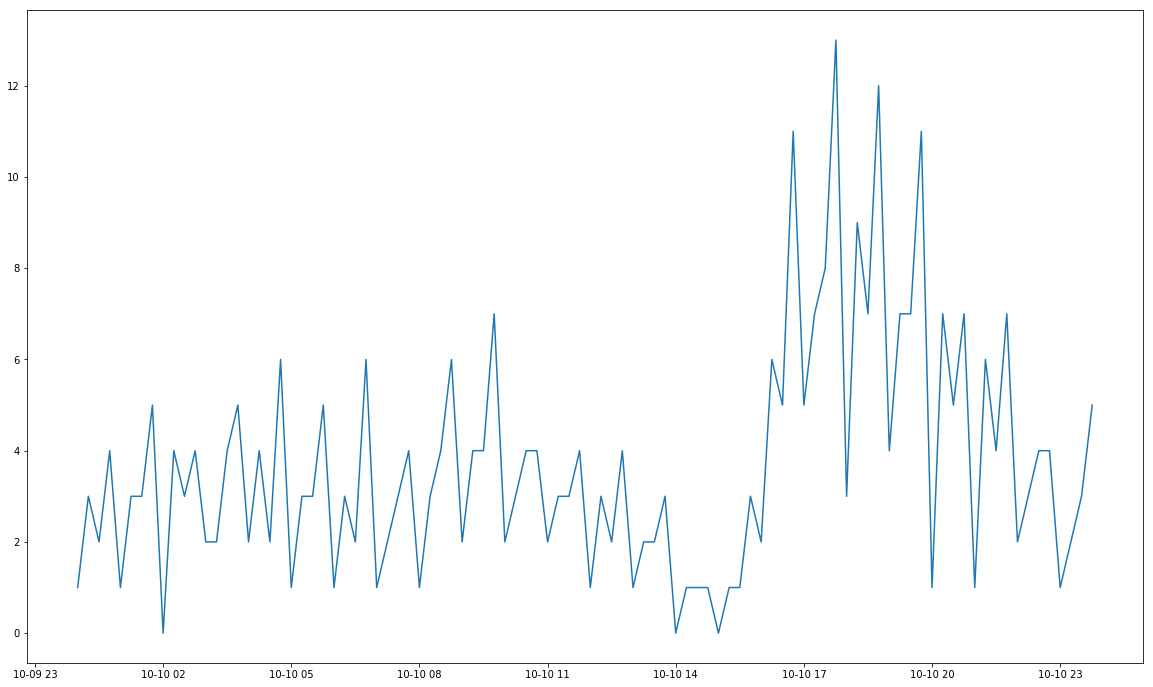

In [60]:
plt.close()
plt.figure(10, figsize=(20,12))
timeOfDay = create_timeOfDay(test_date)
avg_timeOfPower = get_avg_timeOfPower(YinXing_IndustrialPark_sta_copy1, 50)
plt.plot(timeOfDay, avg_timeOfPower)

## 6.1.2.1 Yinxing Industrial Park - 10.20 + 20days

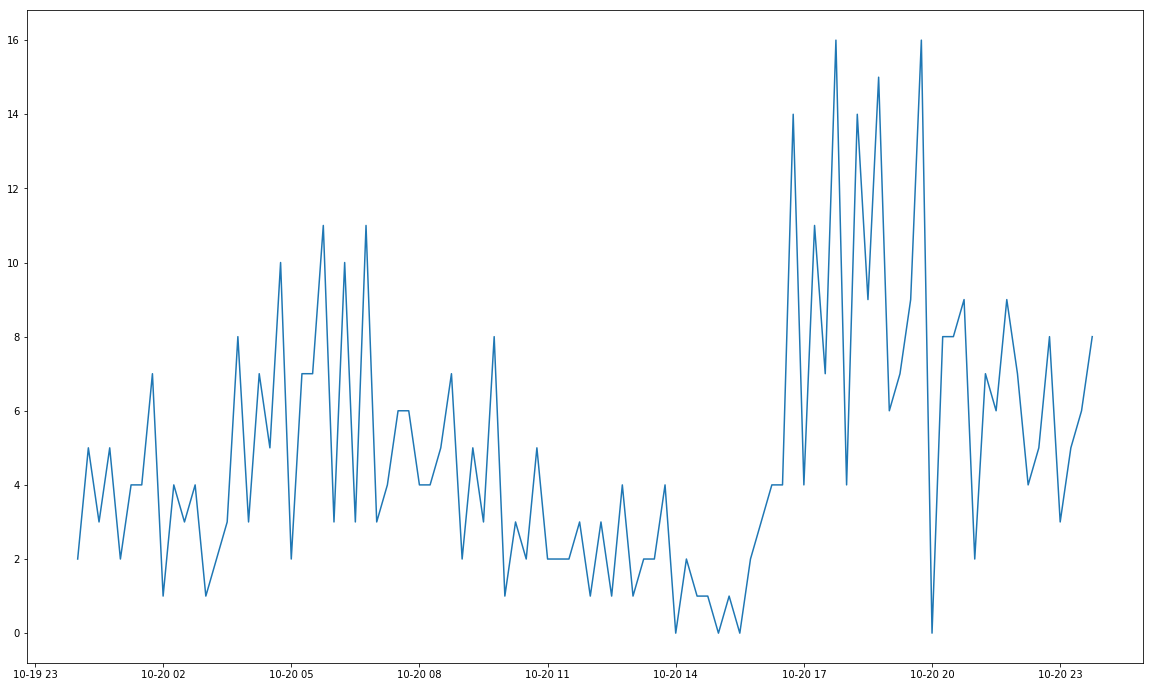

In [44]:
plt.close()
plt.figure(10, figsize=(20,12))
timeOfDay = create_timeOfDay(test_date)
avg_timeOfPower = get_avg_timeOfPower(YinXing_IndustrialPark_sta_copy1, 20)
plt.plot(timeOfDay, avg_timeOfPower)

## 6.1.2.2 Yinxing Industrial Park - 11.10 + 20days

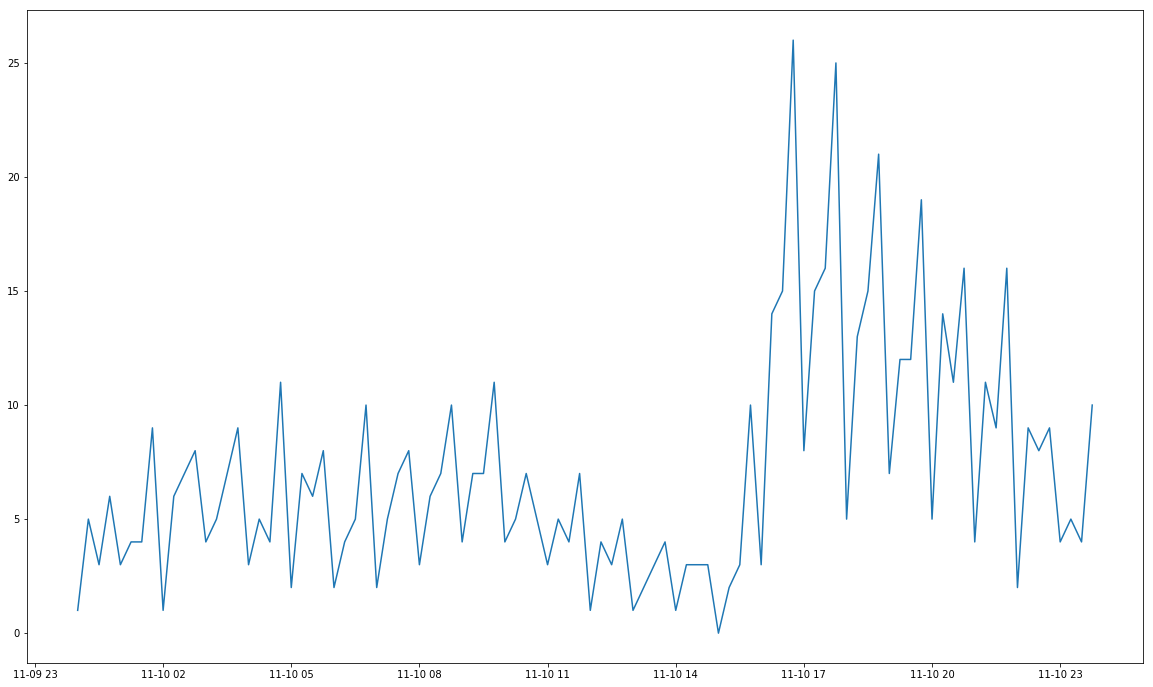

In [47]:
plt.close()
plt.figure(10, figsize=(20,12))
timeOfDay = create_timeOfDay(test_date)
avg_timeOfPower = get_avg_timeOfPower(YinXing_IndustrialPark_sta_copy1, 20)
plt.plot(timeOfDay, avg_timeOfPower)

## 6.1.2.3 Jingyuan Mansion 10.10 + 50days

In [57]:
test_date = datetime.datetime(2017, 10, 20, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
day_range = 20

In [58]:
staObject_list_copy = []
for station in staObject_list[-1:]:
    station_copy = copy.deepcopy(station)
    station_copy1 = copy.deepcopy(station)
    station_copy, boundary_list_grand_station = clean_pillUltdata(station_copy, test_date, day_range)
    station_copy1 = map_ultdata(station_copy1, boundary_list_grand_station, timestamp=15)
    staObject_list_copy.append(station_copy1)

深圳景元大厦充电站


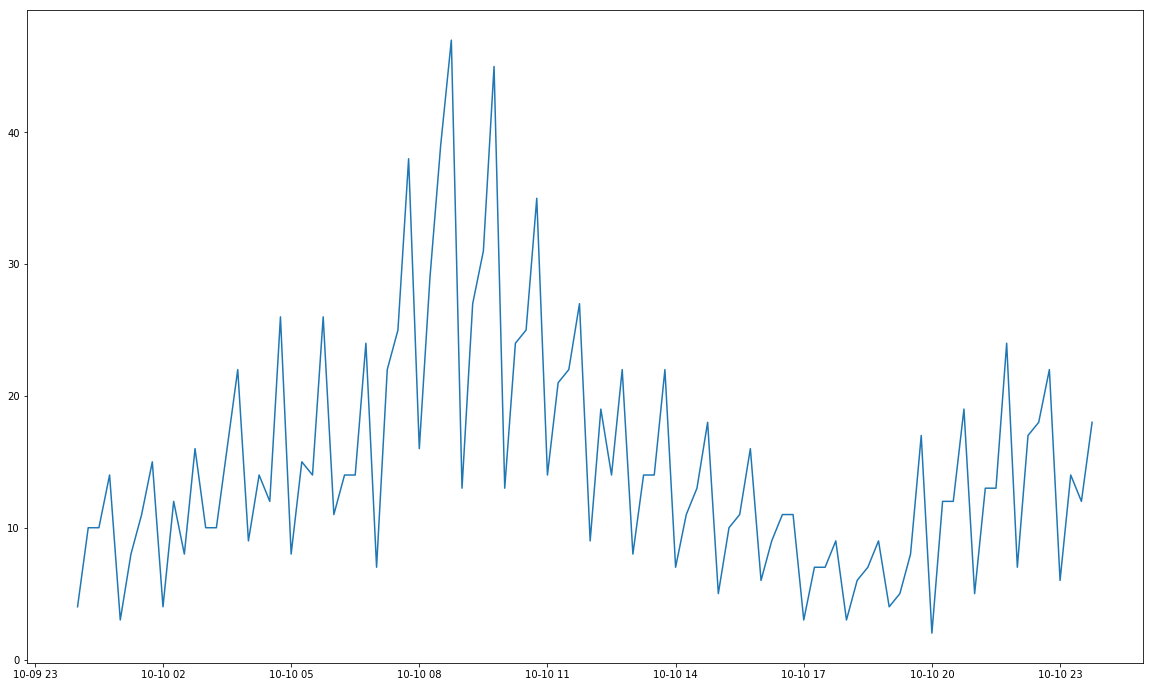

In [56]:
timeOfDay = create_timeOfDay(test_date, timestamp=15)
for station in staObject_list_copy[-1:]:
    plt.figure(10, figsize=(20,12))
    avg_timeOfPower = get_avg_timeOfPower(station, day_range=50, timestamp=15)
    print(station.name)
    plt.plot(timeOfDay, avg_timeOfPower)
    plt.show()

## 6.1.2.4 Jingyuan Mansion 10.20 + 20days

深圳景元大厦充电站


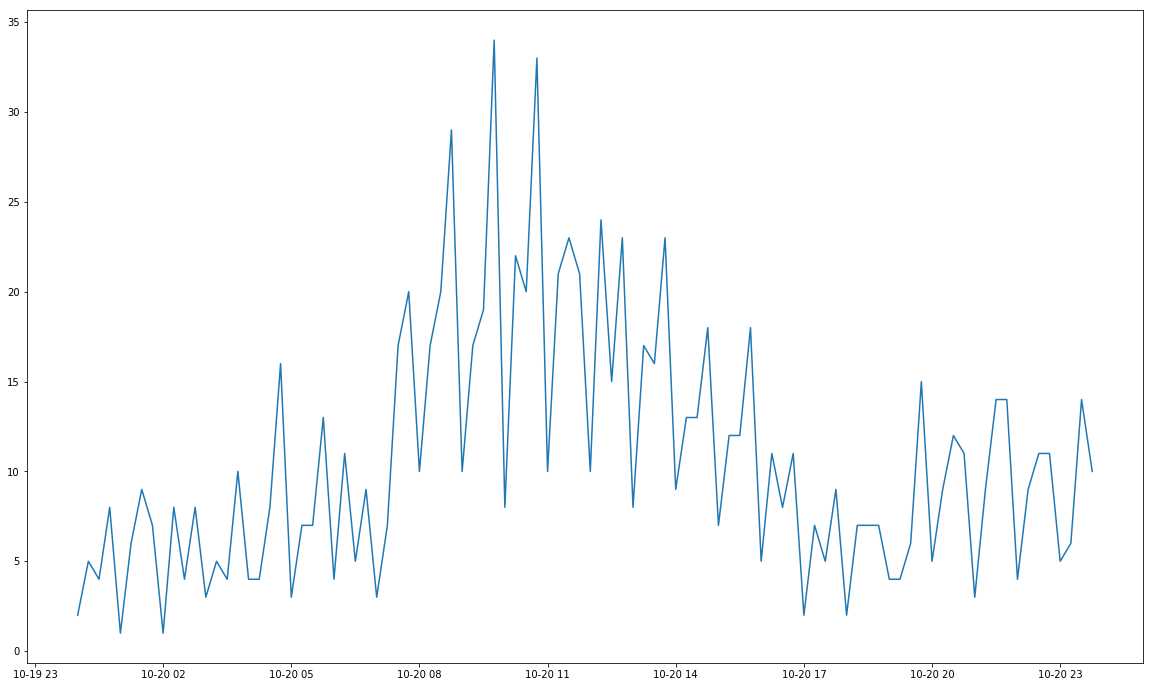

In [59]:
timeOfDay = create_timeOfDay(test_date, timestamp=15)
for station in staObject_list_copy[-1:]:
    plt.figure(10, figsize=(20,12))
    avg_timeOfPower = get_avg_timeOfPower(station, day_range=20, timestamp=15)
    print(station.name)
    plt.plot(timeOfDay, avg_timeOfPower)
    plt.show()

# 6.1.3 Research Institute

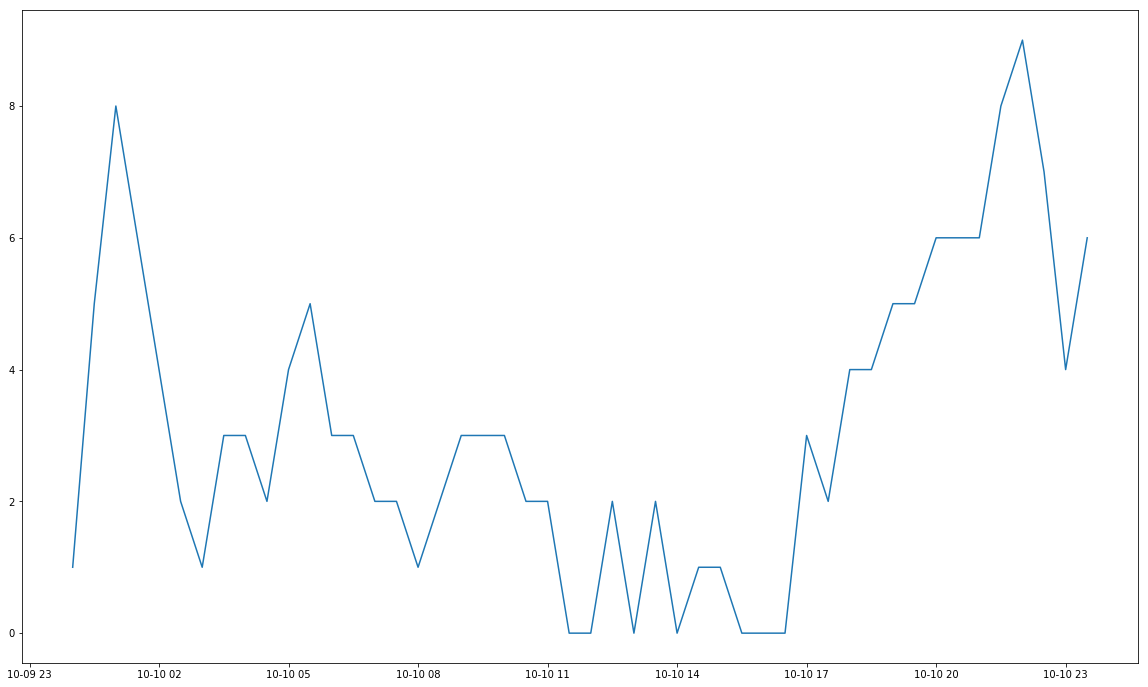

In [363]:
plt.close()
plt.figure(10, figsize=(20,12))
timeOfDay = create_timeOfDay(test_date, timestamp=30)
avg_timeOfPower = get_avg_timeOfPower(sta1_copy1, day_range=40, timestamp=30)
plt.plot(timeOfDay, avg_timeOfPower)

In [449]:
for pill in YinXing_IndustrialPark_sta_copy1.pills:
    print(pill.pricedesc)

电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000


# 6.2 Plotting Eight Stations 10.10+70days

In [61]:
test_date = datetime.datetime(2017, 10, 10, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
day_range = 70

In [62]:
staObject_list_copy = []
for station in staObject_list:
    station_copy = copy.deepcopy(station)
    station_copy1 = copy.deepcopy(station)
    station_copy, boundary_list_grand_station = clean_pillUltdata(station_copy, test_date, day_range)
    station_copy1 = map_ultdata(station_copy1, boundary_list_grand_station, timestamp=15)
    staObject_list_copy.append(station_copy1)

北京航空精密机械研究所充电站


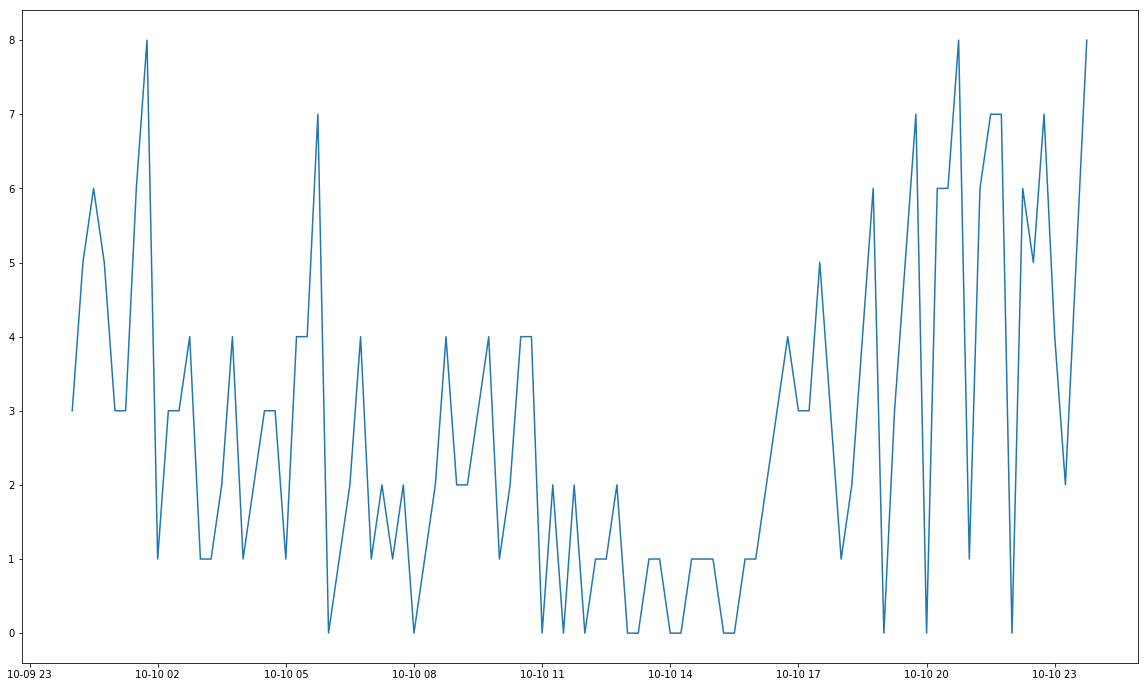

北京西郊宾馆充电站


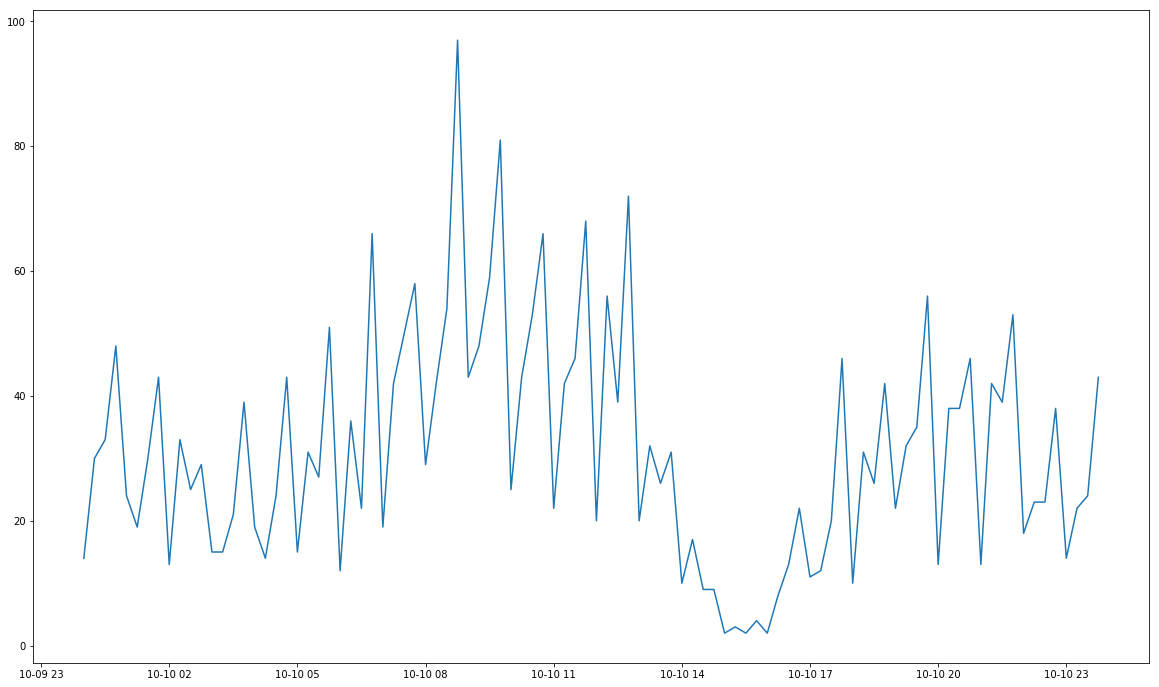

北京阳光丽城酒店充电站


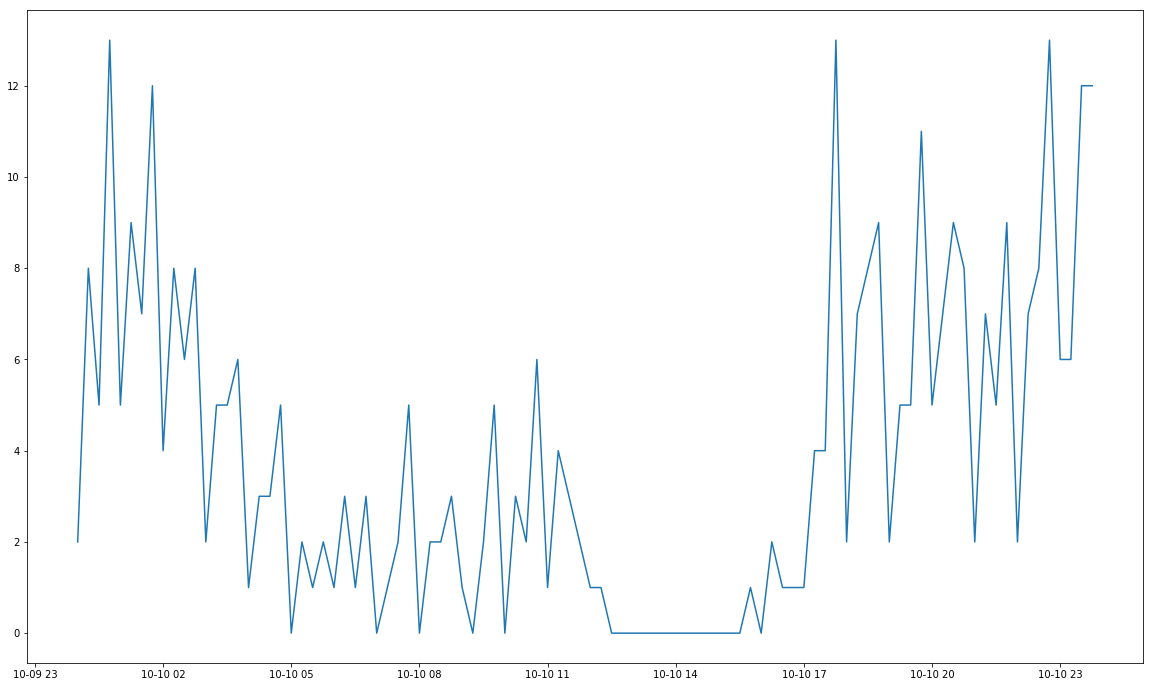

北京元亨苑林山庄有限公司充电站


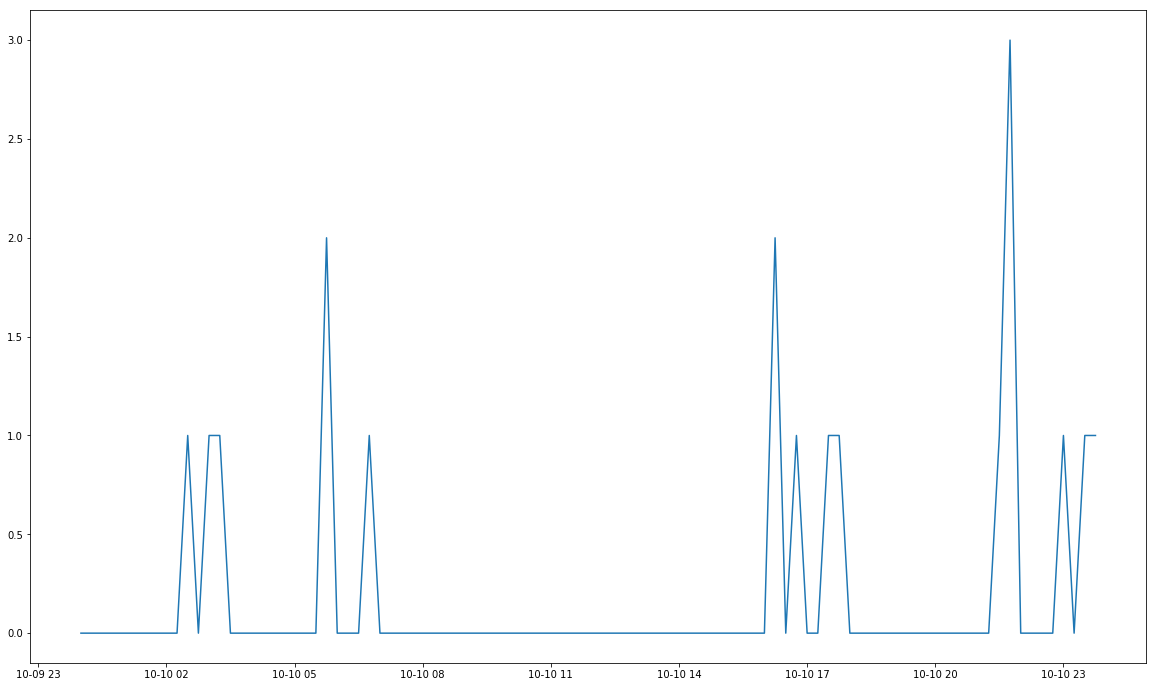

深圳恒江大厦充电站


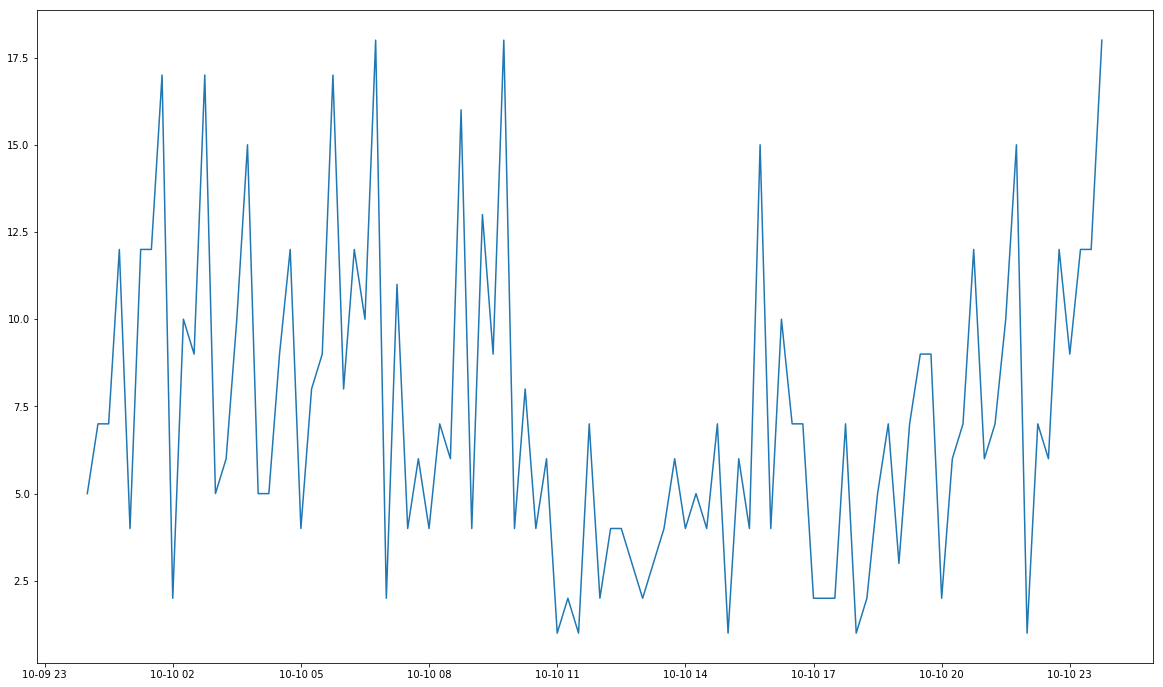

深圳银星工业园充电站


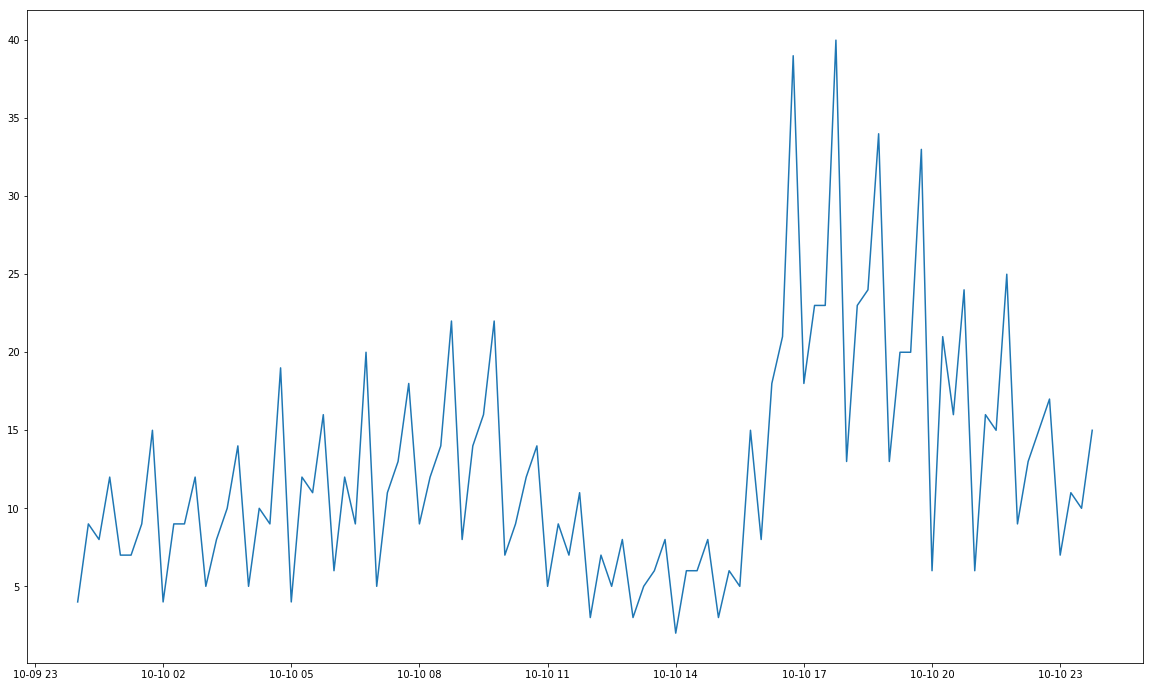

深圳万科九龙山充电站


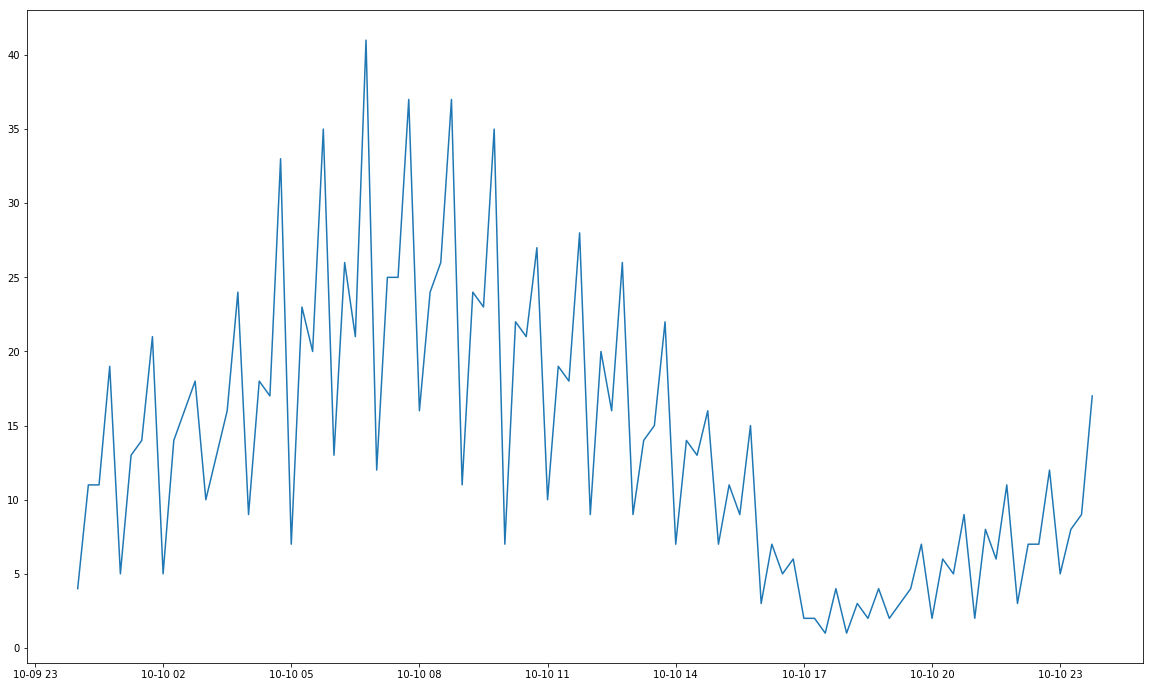

深圳景元大厦充电站


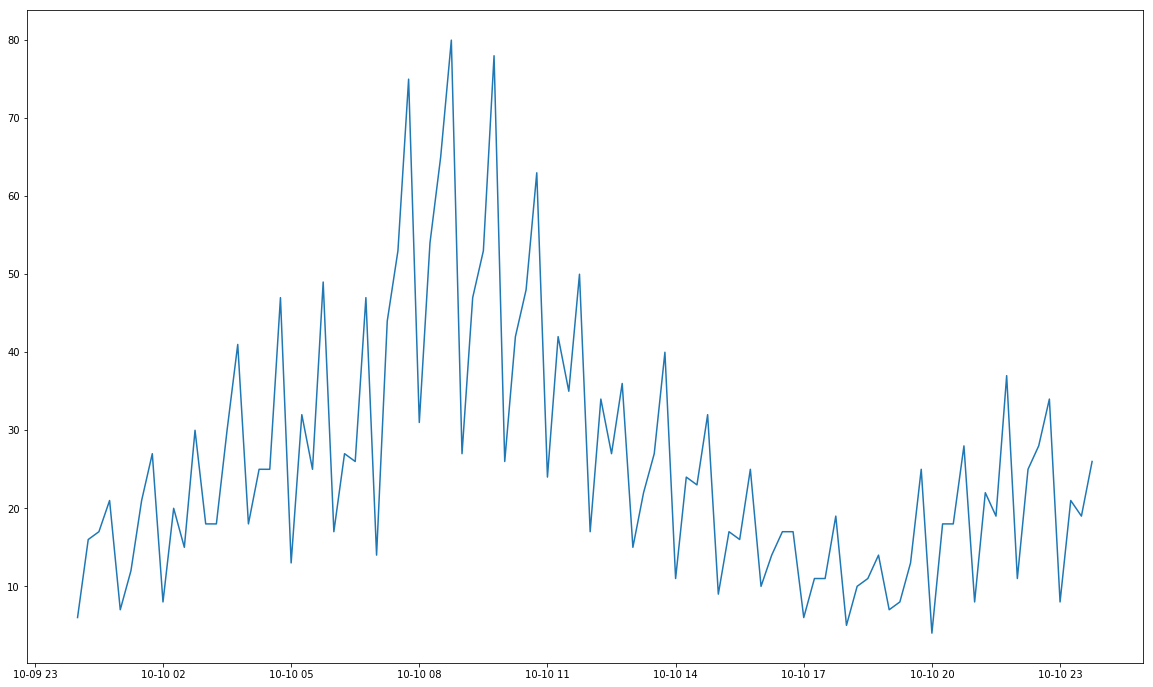

In [63]:
timeOfDay = create_timeOfDay(test_date, timestamp=15)
for station in staObject_list_copy:
    plt.figure(10, figsize=(20,12))
    avg_timeOfPower = get_avg_timeOfPower(station, day_range=70, timestamp=15)
    print(station.name)
    plt.plot(timeOfDay, avg_timeOfPower)
    plt.show()
#     avg_timeOfPower = get_avg_timeOfPower(station, day_range=40, timestamp=15)
#     penetration = np.divide(avg_timeOfPower, station.get_maxPower())*100 #percentage
#     fig, ax1 = plt.subplots(figsize=(20,12))
#     ax2 = ax1.twinx()
#     ax1.plot(timeOfDay, avg_timeOfPower, label="Average Power Consumption (kW)", color="blue")
#     ax1.fill_between(timeOfDay, [max(station.ult_data[i]) for i in range(96)], [min(station.ult_data[i]) for i in range(96)], facecolor='#C4291F')
#     ax1.fill_between(timeOfDay, [np.percentile(station.ult_data[i], 75) for i in range(96)], [np.percentile(station.ult_data[i], 25) for i in range(96)], facecolor='black')
#     ax1.set_xlabel("Time of Day", fontdict={'fontsize':20})
#     ax1.set_ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
#     ax1.set_ybound(lower=0)

#     ax2.plot(timeOfDay, penetration, label="EV penetration rate (%)", color="#c1a481")
#     ax2.set_ylabel("EV Penetration (%)", fontdict={'fontsize':20})
#     ax2.set_ybound(0, max(penetration)+10)

#     ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
#     ax2.legend(loc='upper right', bbox_to_anchor=(0.8, 1))
#     ax1.set_title("Max vs. 75th and 25th percentile + EV Penetration", fontdict={'fontsize':20})
#     plt.show()

# 6.3 Plotting a Lot of Stations

In [82]:
test_date = datetime.datetime(2017, 10, 10, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
day_range = 70
timestamp = 30

In [66]:
pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list_clean)
shenzhen_station_list = init_station_obj(sta_list_clean, sta_details_list)
shenzhen_station_list = constr_station_objFull(shenzhen_station_list, pillcode_list)
shenzhen_station_list = update_daily_ultData(shenzhen_station_list)

In [73]:
#check for any offline stations
iniLength = len(shenzhen_station_list)
for idx, station in enumerate(shenzhen_station_list):
    if station.pills[0].ult_data[-1][2] < test_date:
        shenzhen_station_list = shenzhen_station_list[:idx]+shenzhen_station_list[idx+1:]
        print(idx)
        print(station.name)
finLength = len(shenzhen_station_list)
print("Initial Station Numbers: "+str(iniLength)+", Final Station Numbers: "+str(finLength))

Initial Station Numbers: 68, Final Station Numbers: 68


In [85]:
shenzhen_station_list_copylist = []
for station in shenzhen_station_list:
    shenzhen_station_copy = copy.deepcopy(station)
    shenzhen_station_copy1 = copy.deepcopy(station)
    shenzhen_station_copy, boundary_list_grand_station = clean_pillUltdata(shenzhen_station_copy, test_date, day_range)
    shenzhen_station_copy1 = map_ultdata(shenzhen_station_copy1, boundary_list_grand_station, timestamp)
    shenzhen_station_list_copylist.append(shenzhen_station_copy1)

0
深圳水木丹华充电站


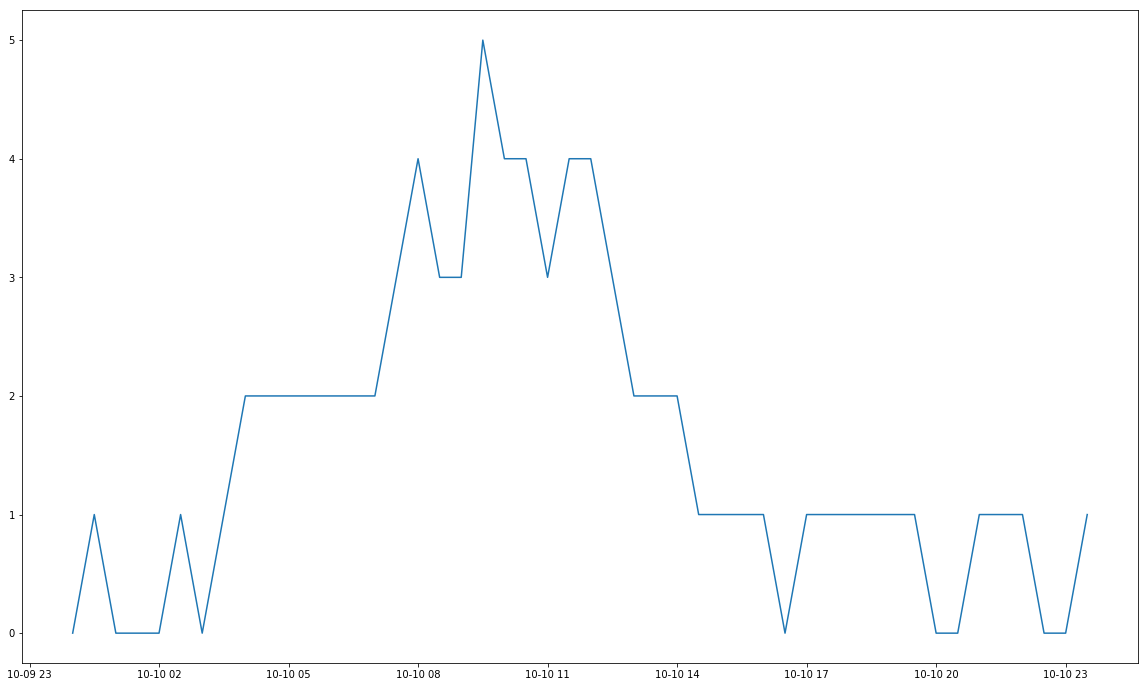

1
深圳天安国际大厦充电站


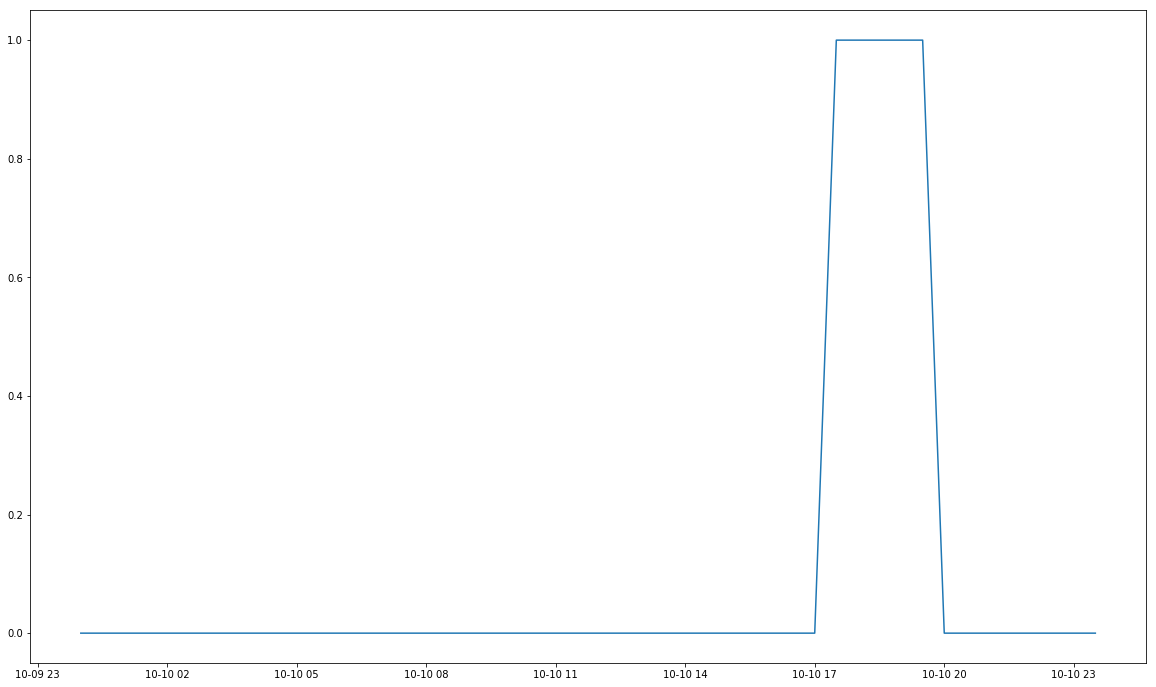

2
深圳联泰大厦充电站


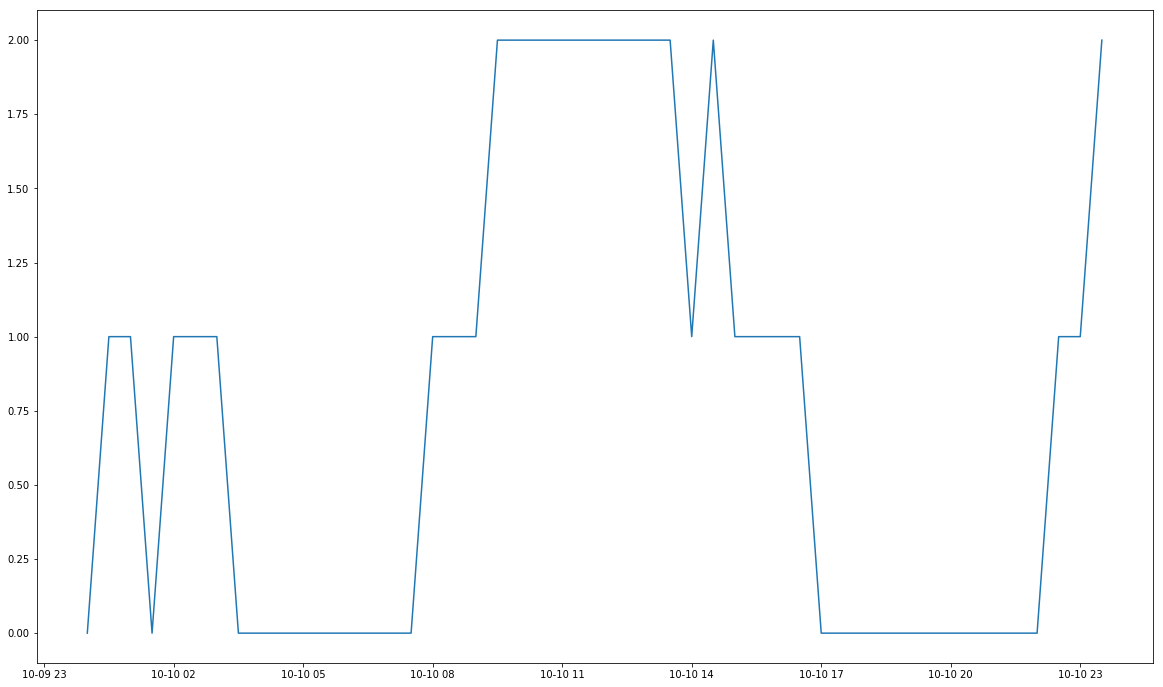

3
深圳南山书城充电站


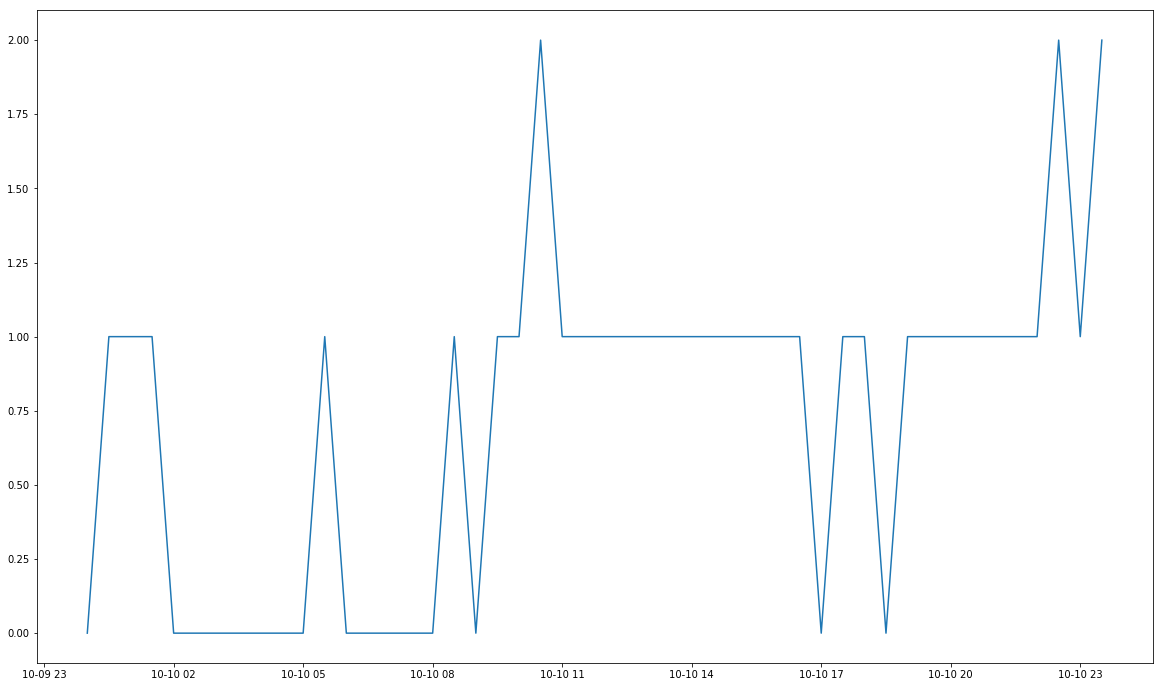

4
深圳园博园管理处充电站


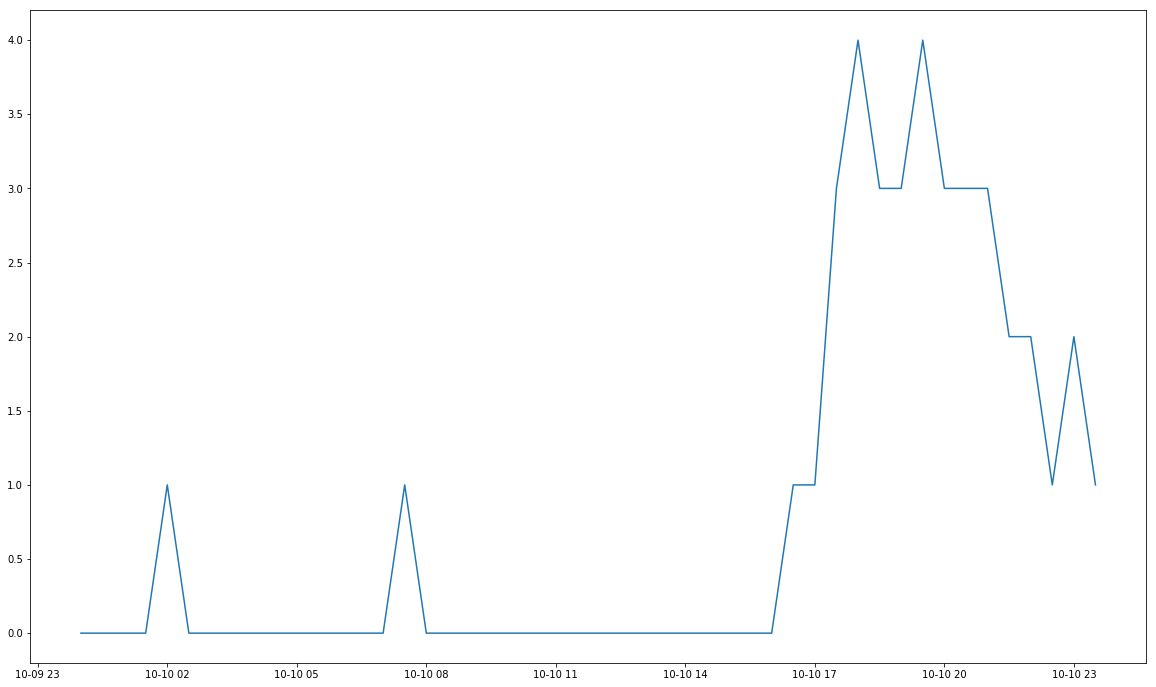

5
深圳京基晶都酒店充电站


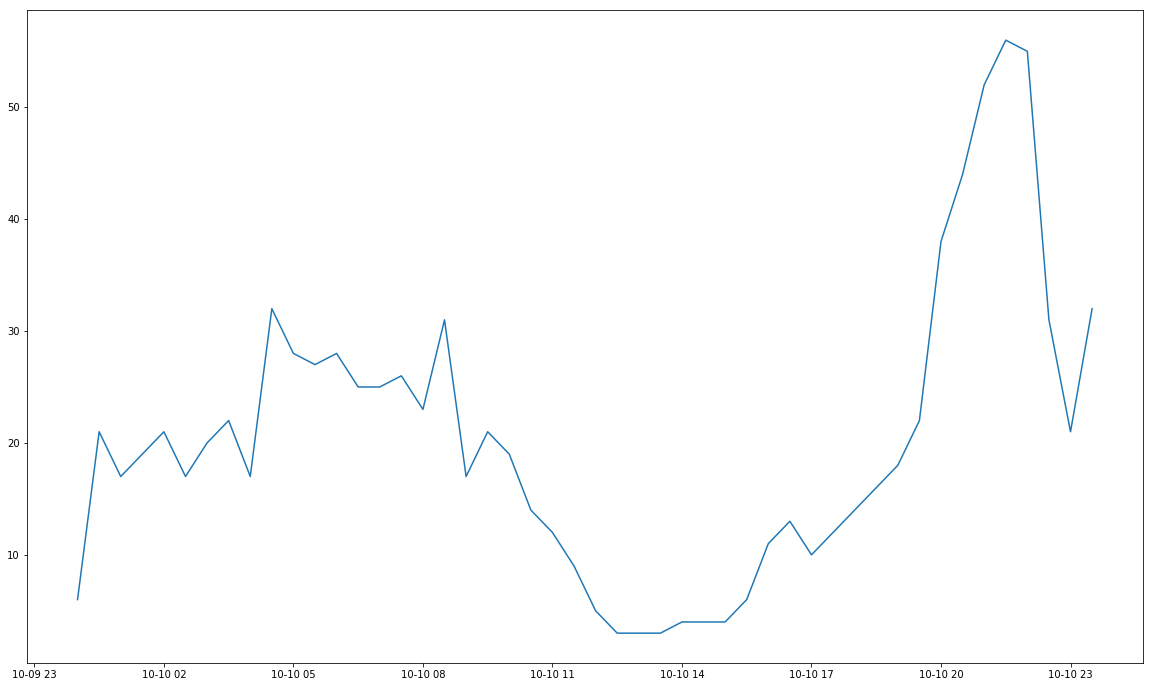

6
深圳百仕达三期充电站


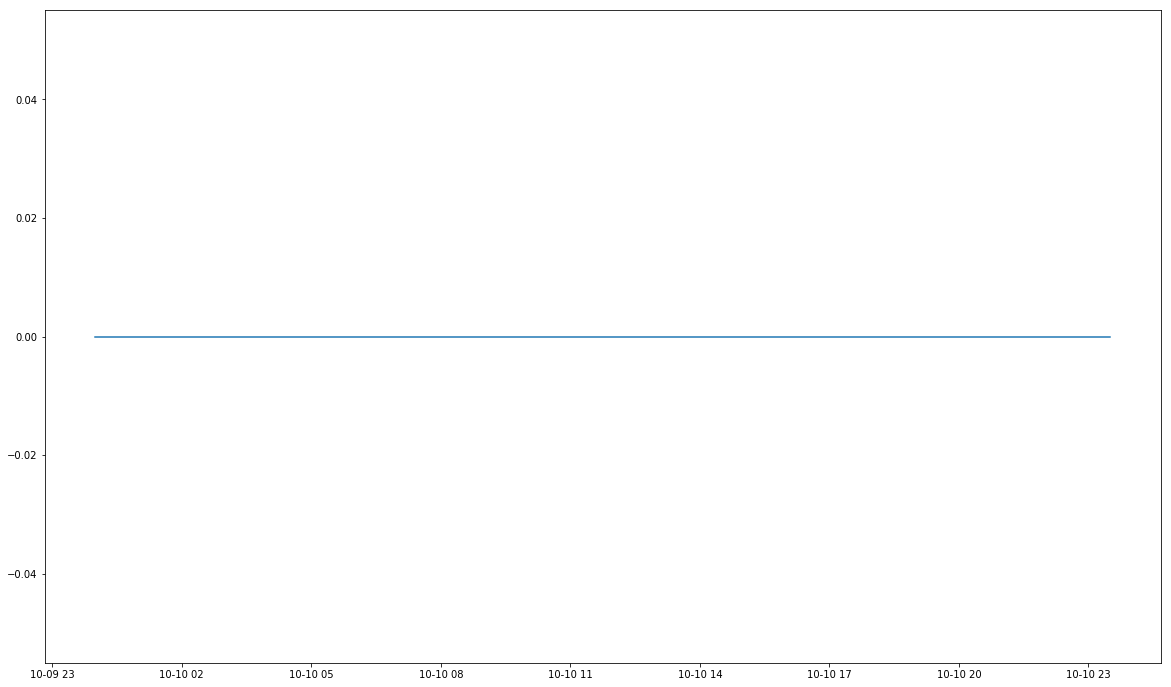

7
深圳书城中心城充电站


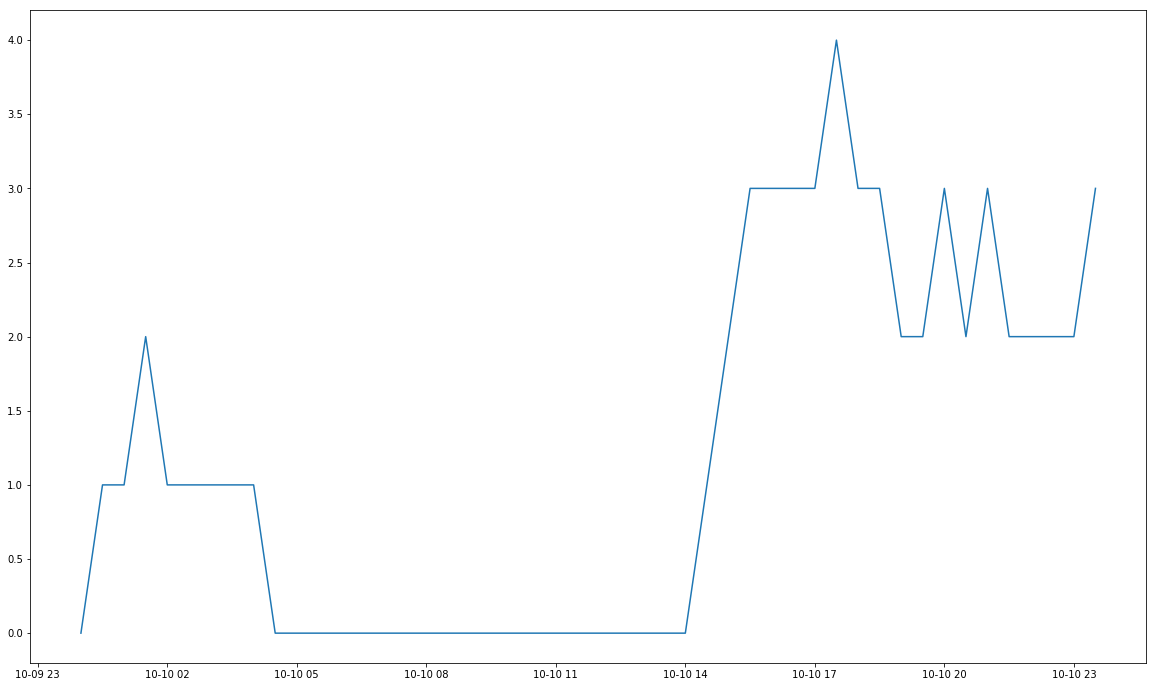

8
深圳城市管理局充电站


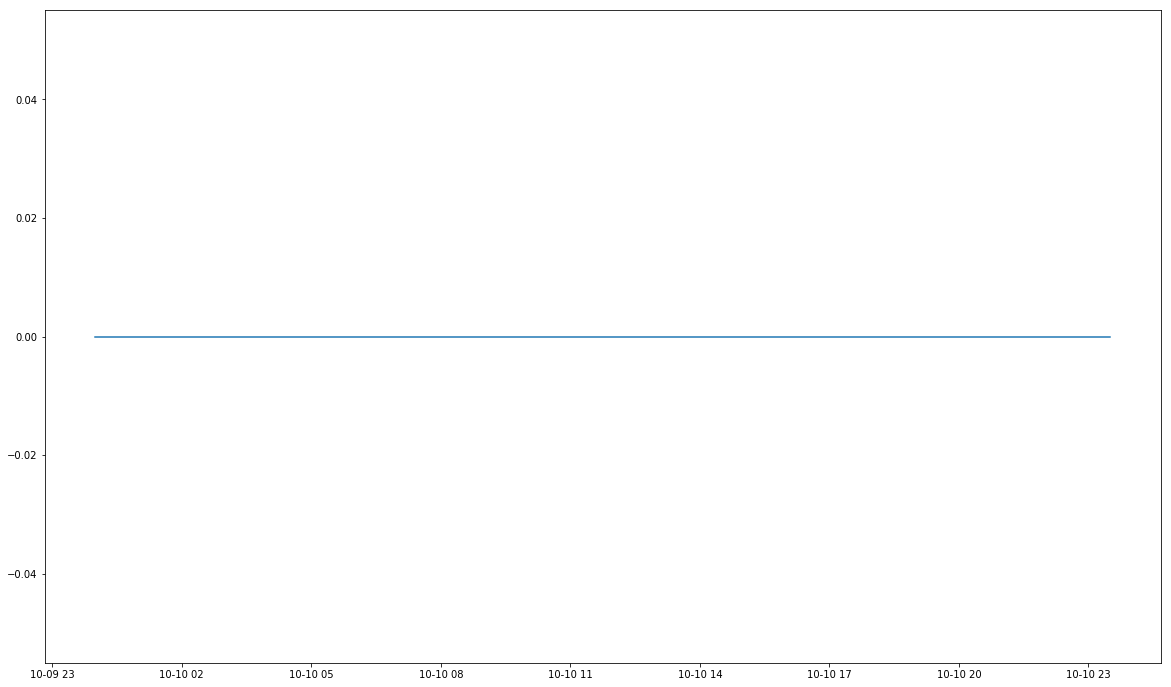

9
深圳大冲都市花园充电站


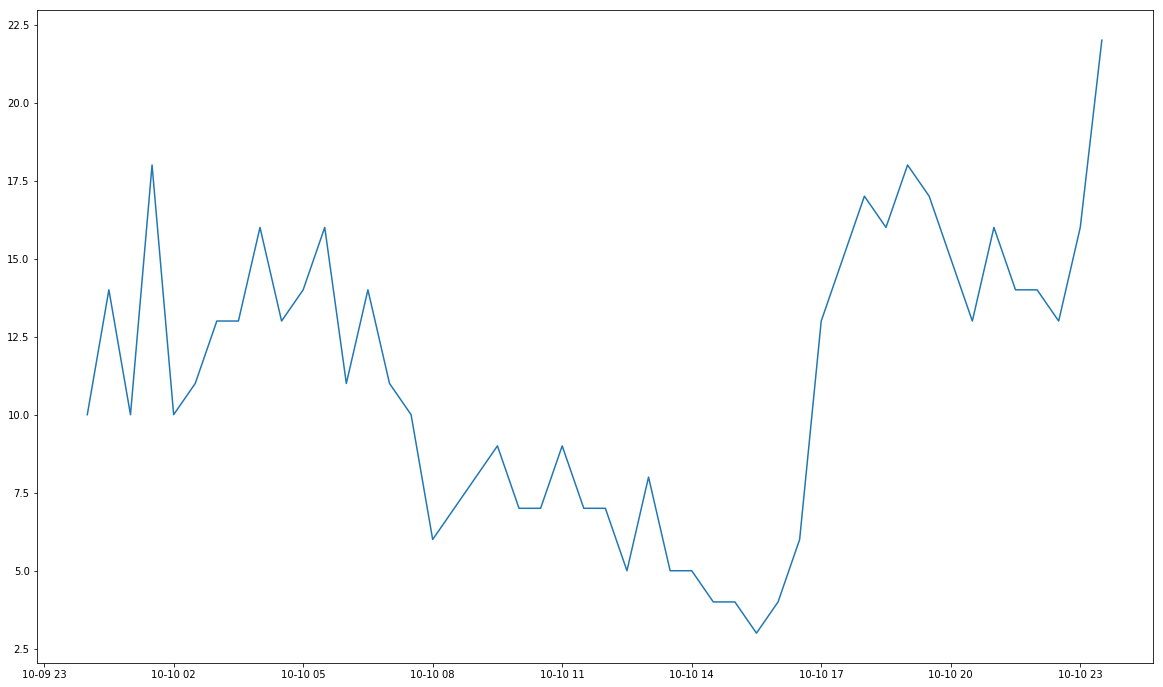

10
深圳创维半导体大厦充电站


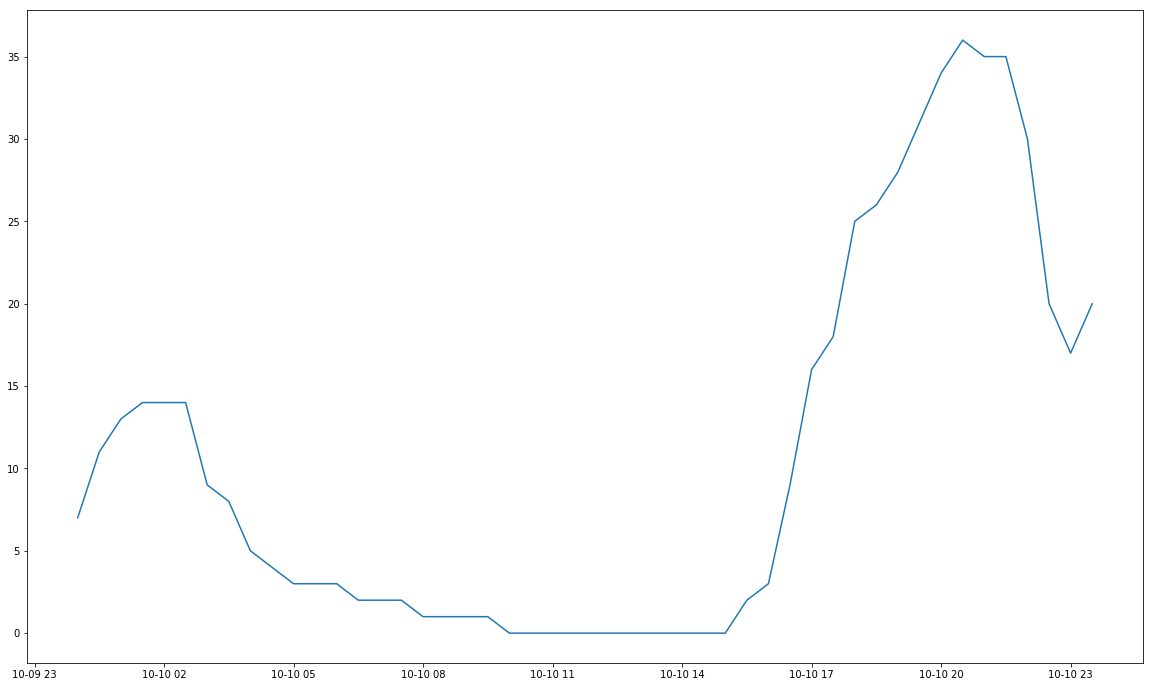

11
深圳东方银座广场充电站


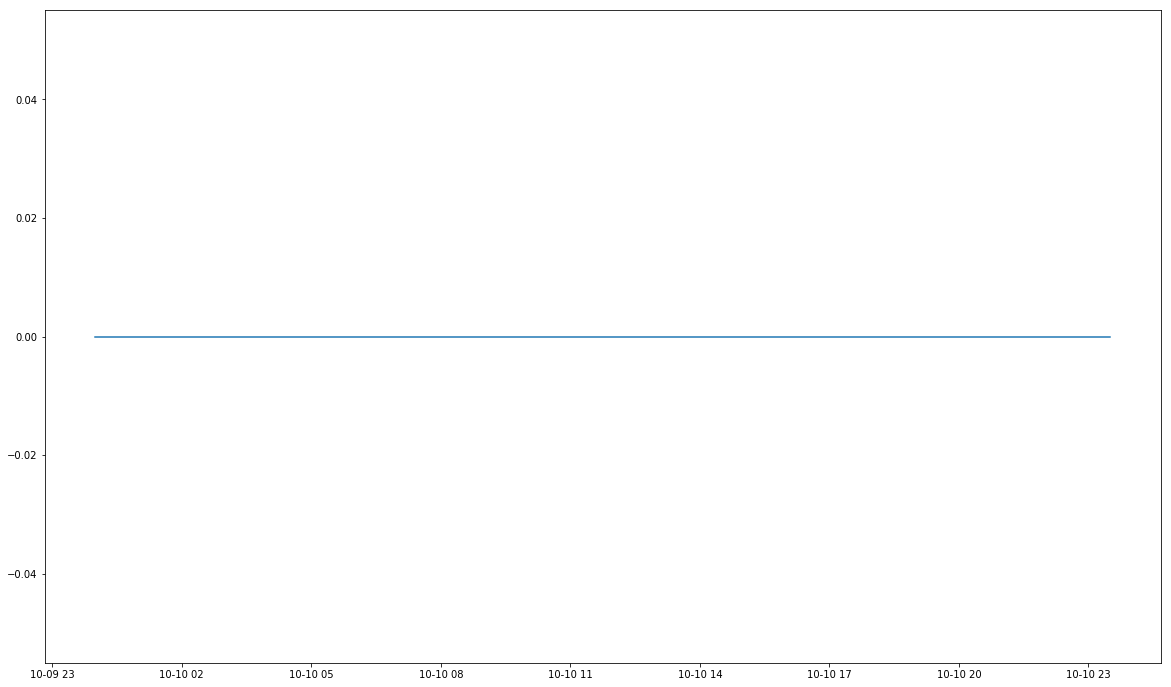

12
深圳深业进元大厦充电站


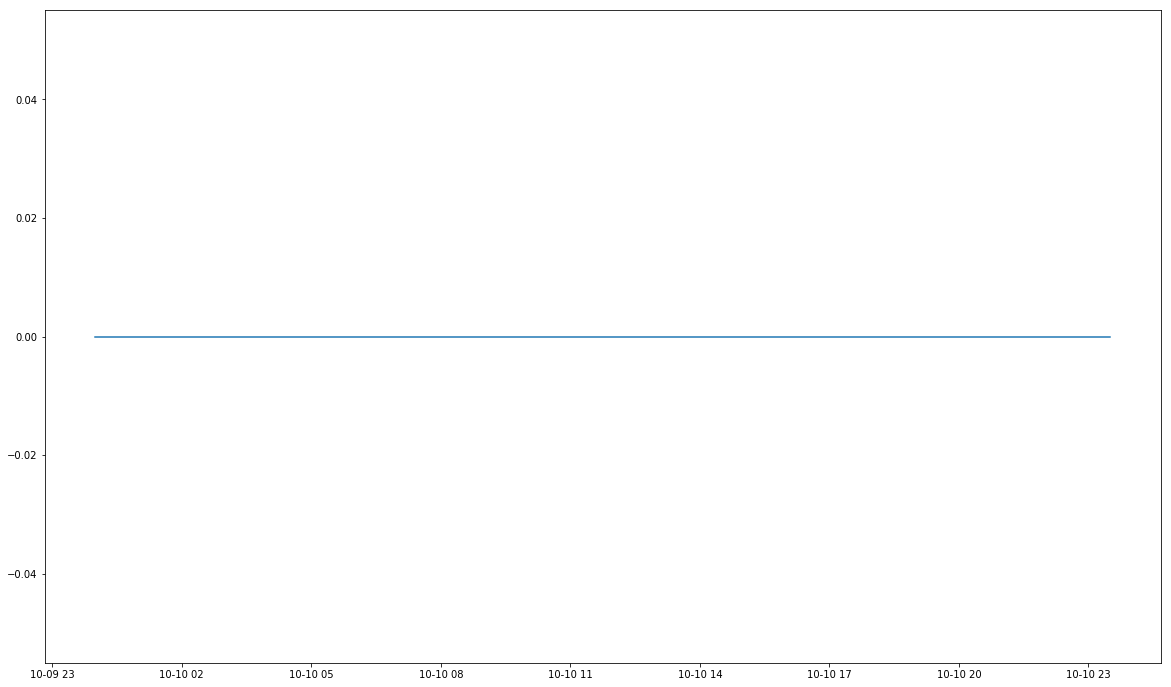

13
深圳天发大厦充电站


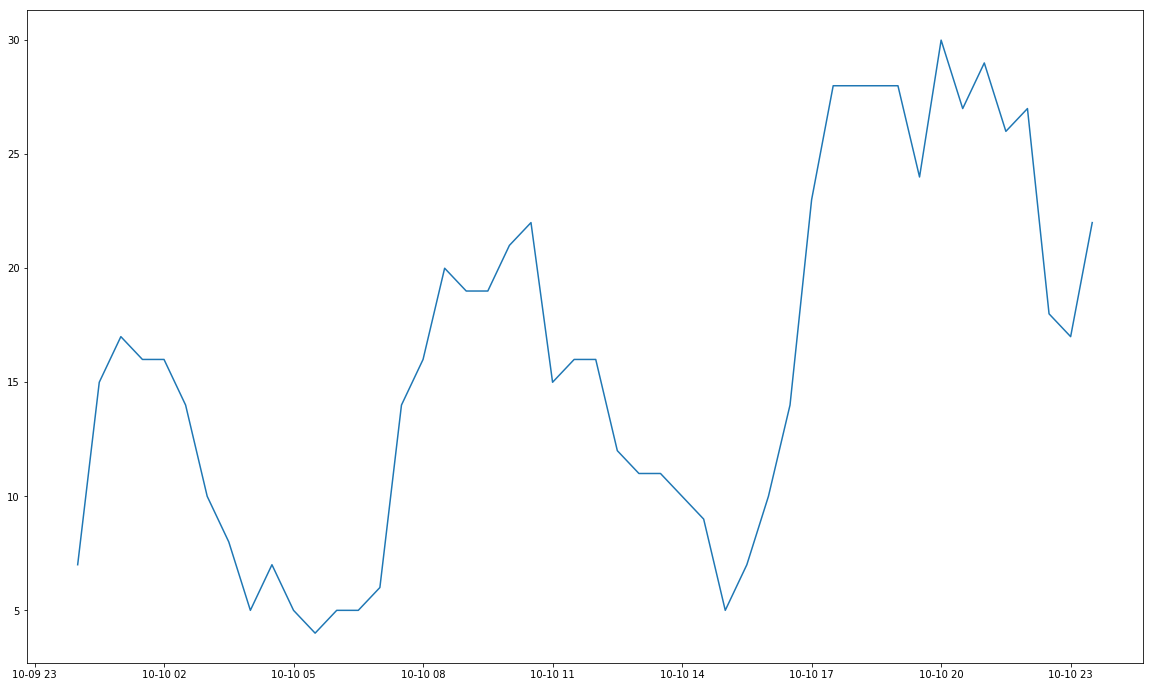

14
深圳联美新天地充电站


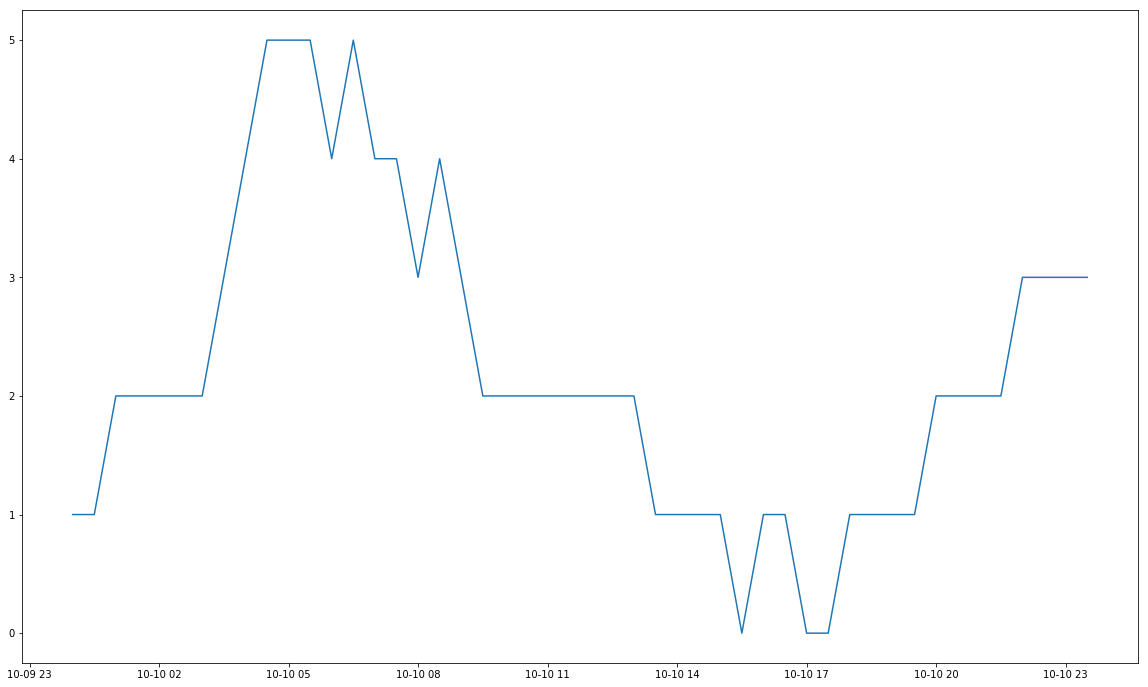

15
深圳豪方花园充电站


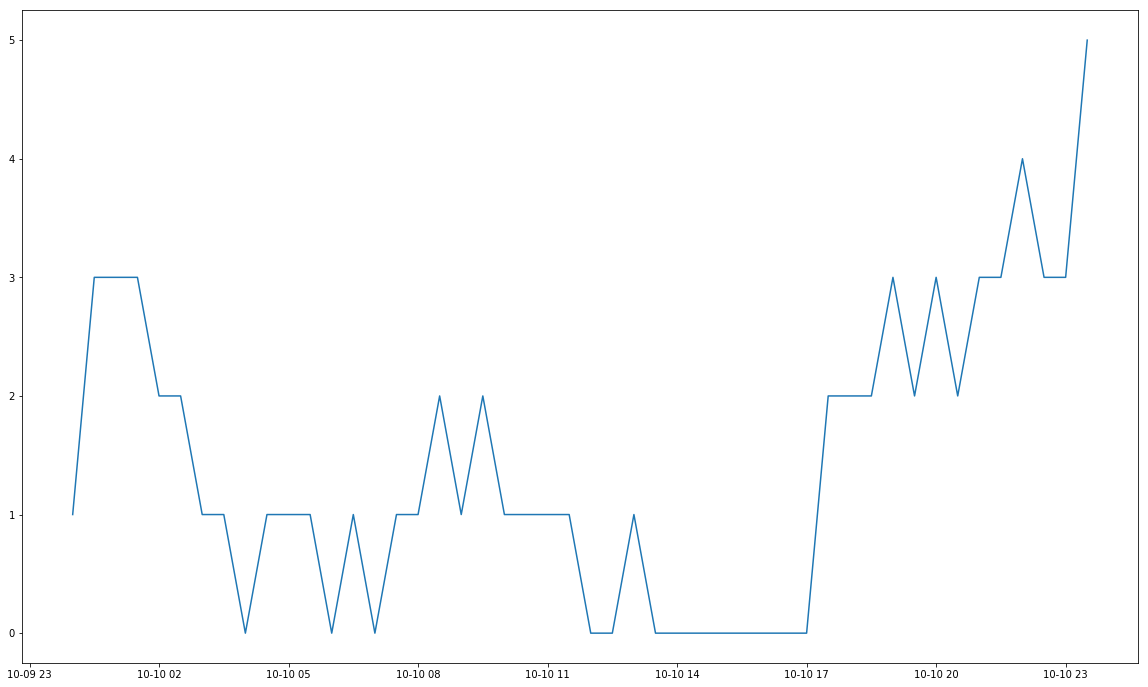

16
深圳春晖苑充电站


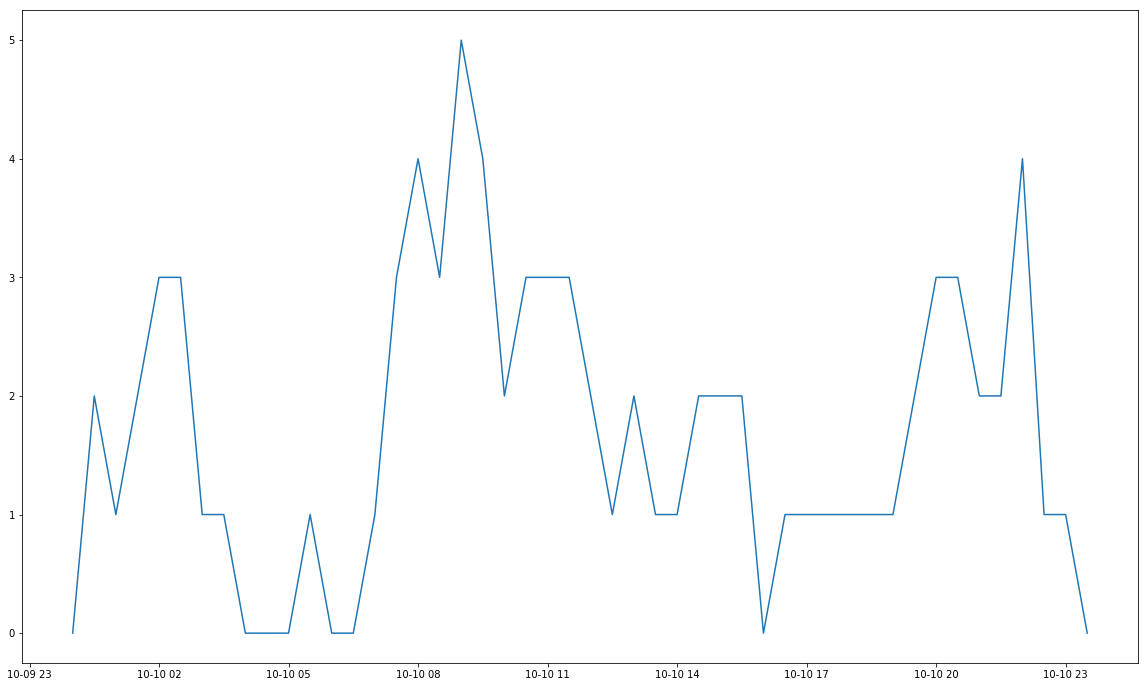

17
深圳军威物业充电站


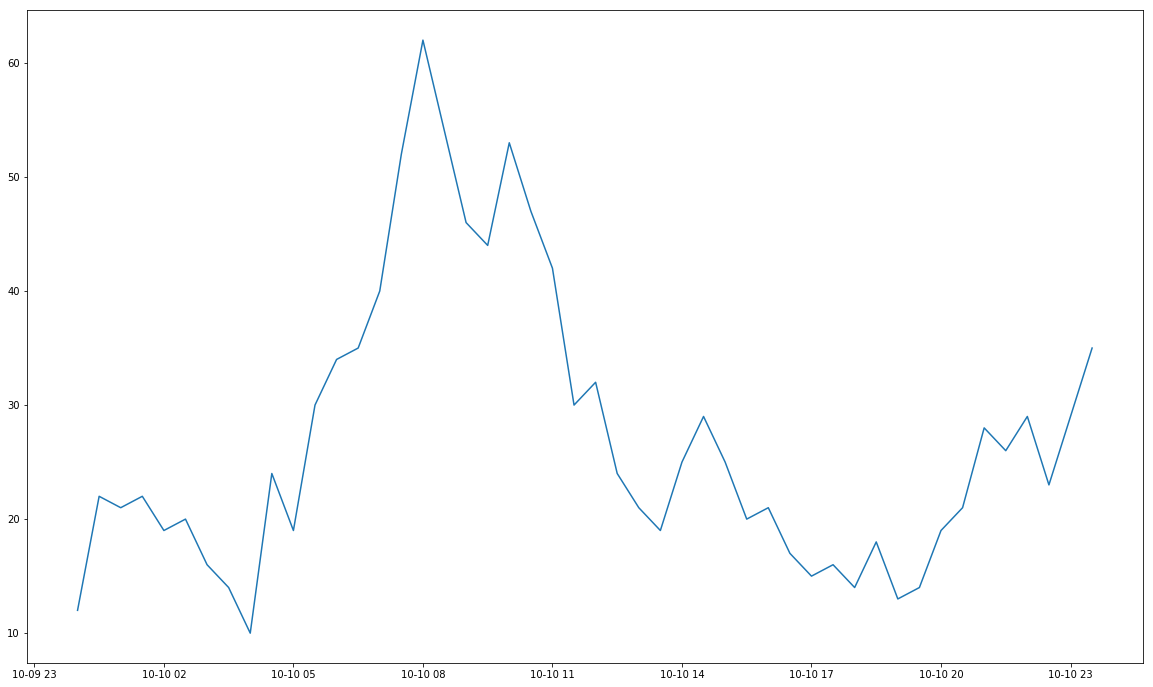

18
深圳熙璟城充电站


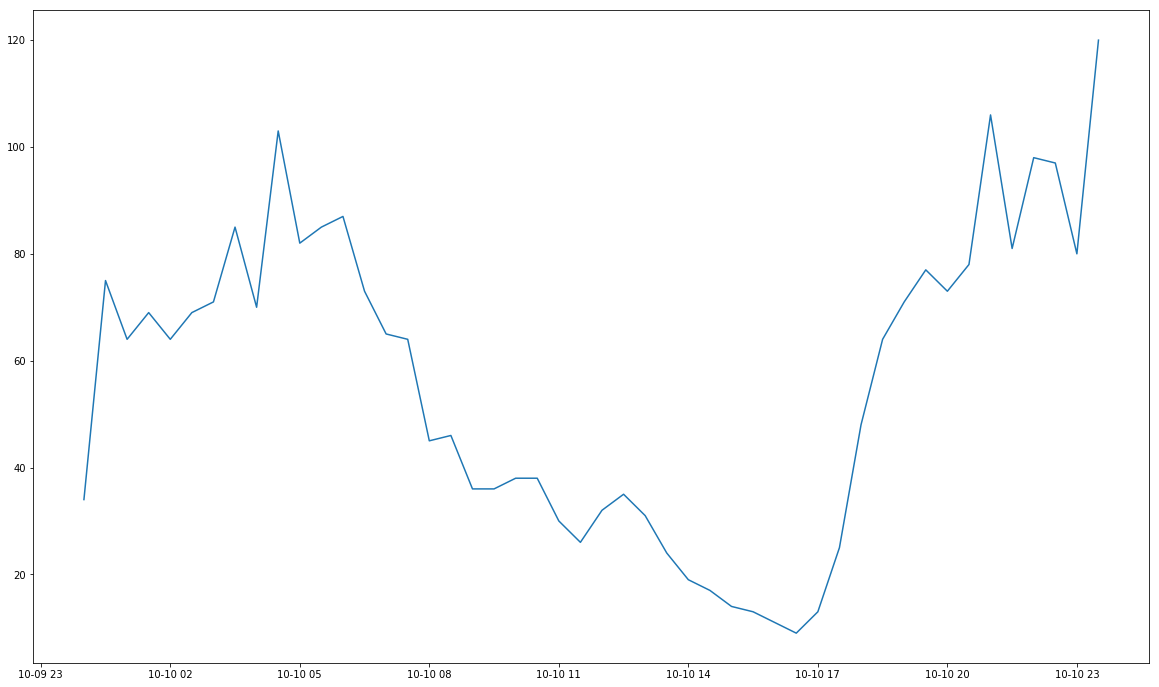

19
深圳凤凰大厦充电站


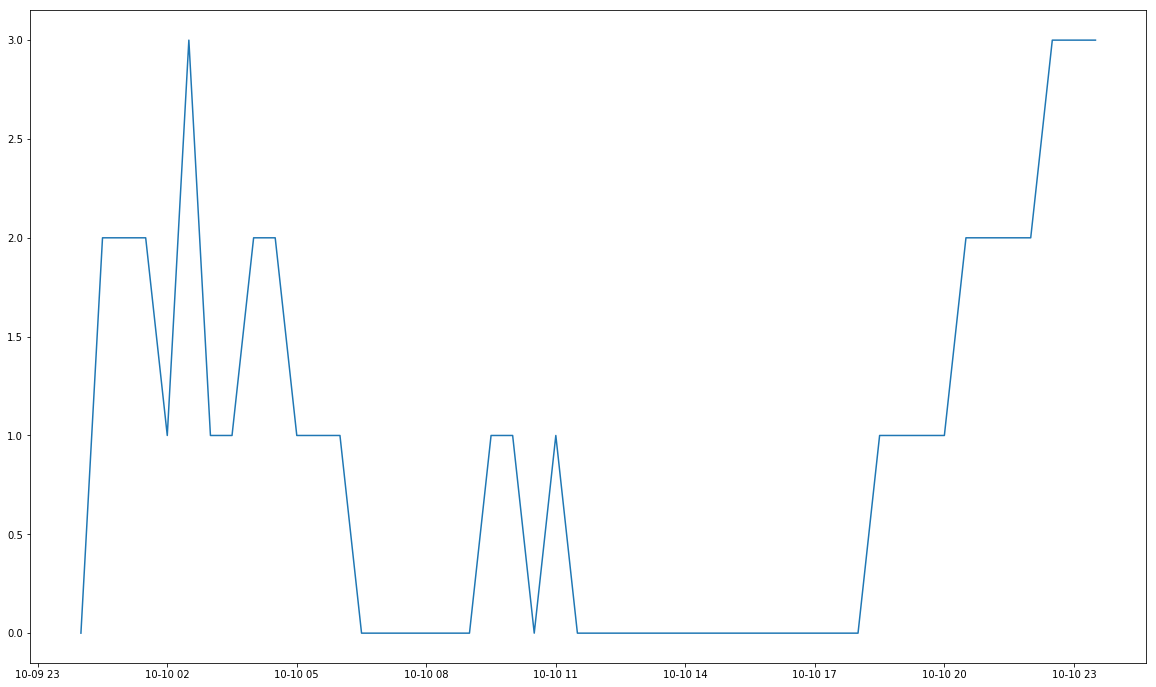

20
深圳公园一号广场充电站


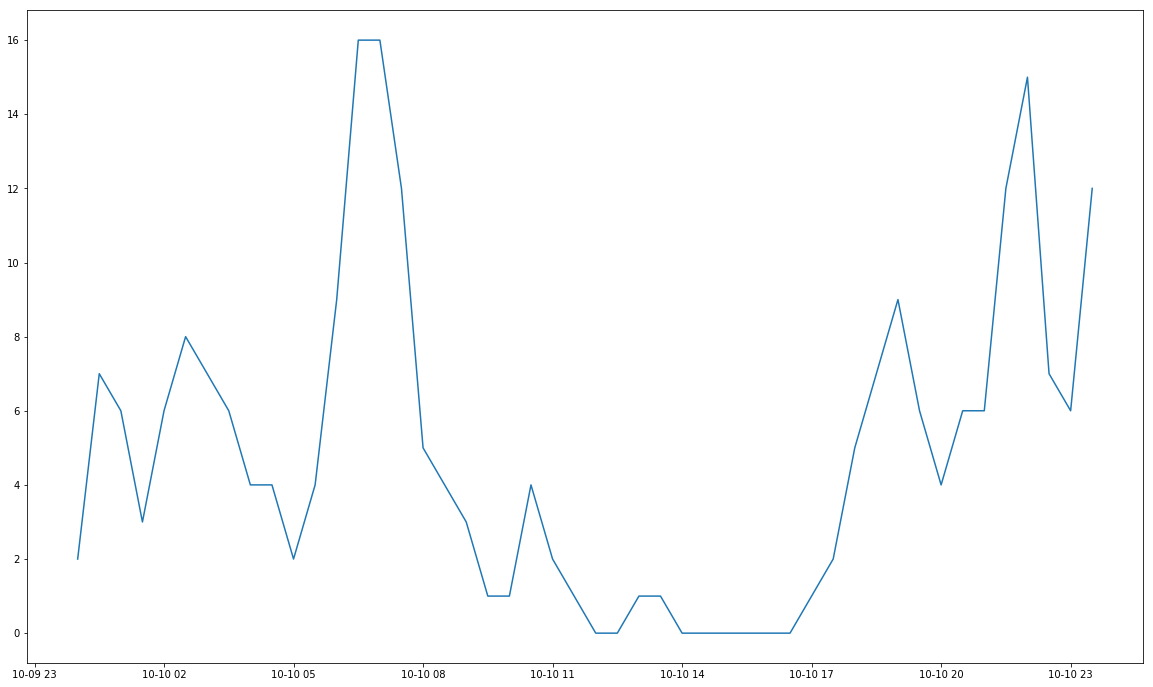

21
深圳长富金茂大厦充电站


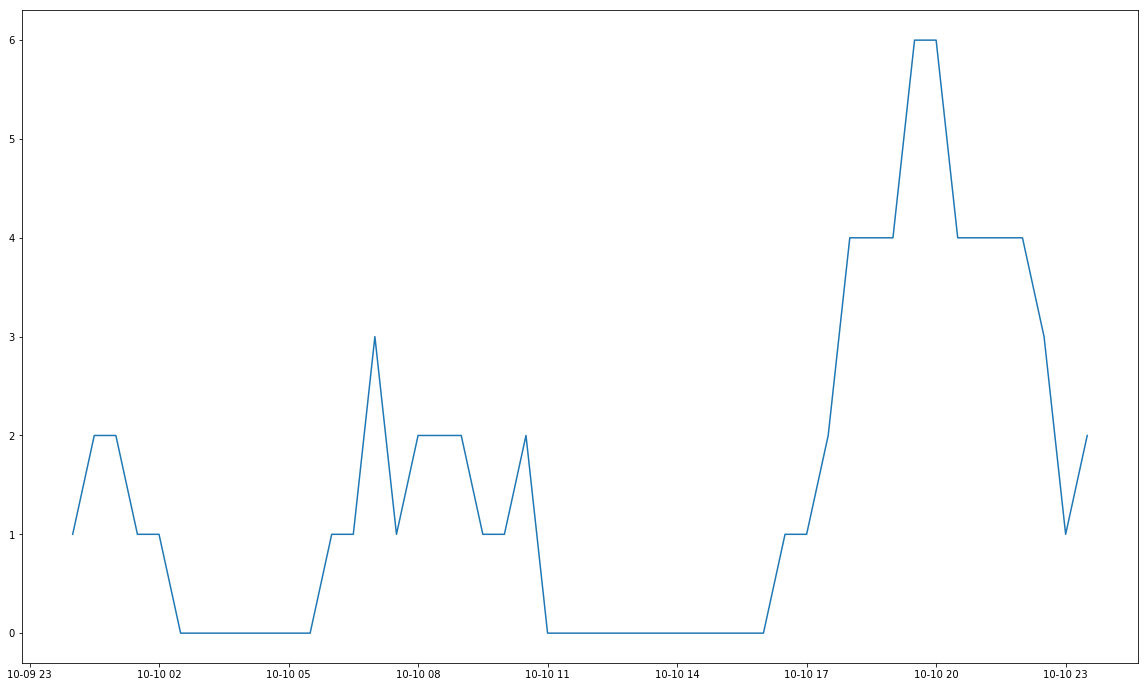

22
深圳李朗珠宝产业园充电站


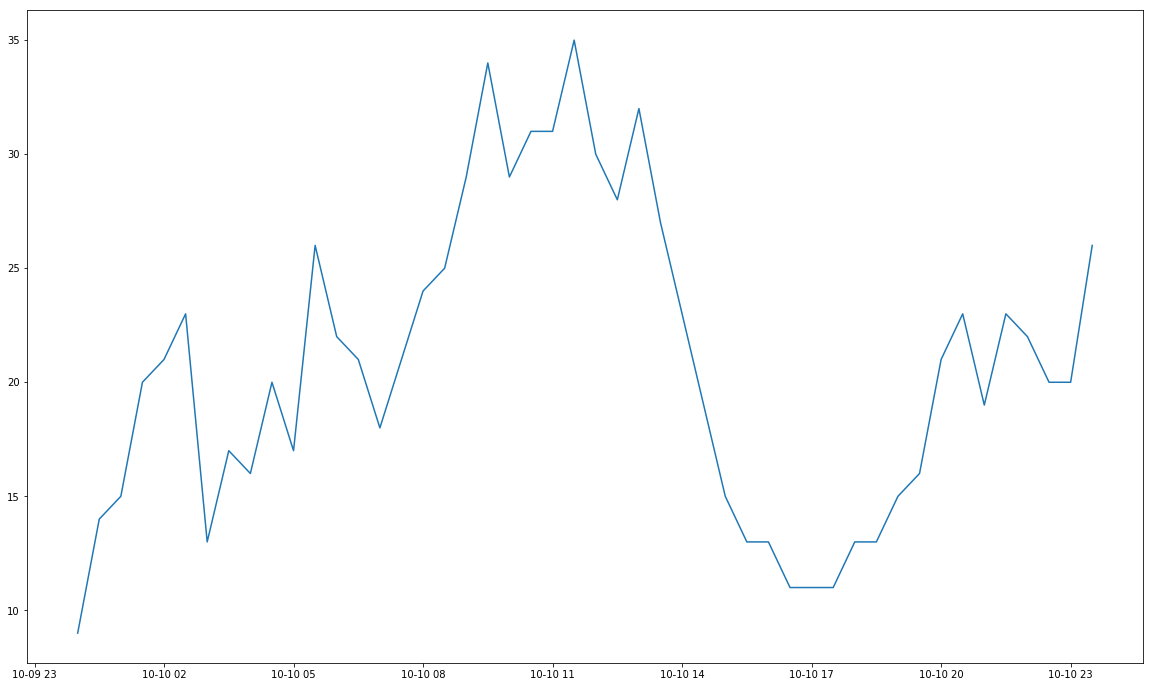

23
深圳华晖云门充电站


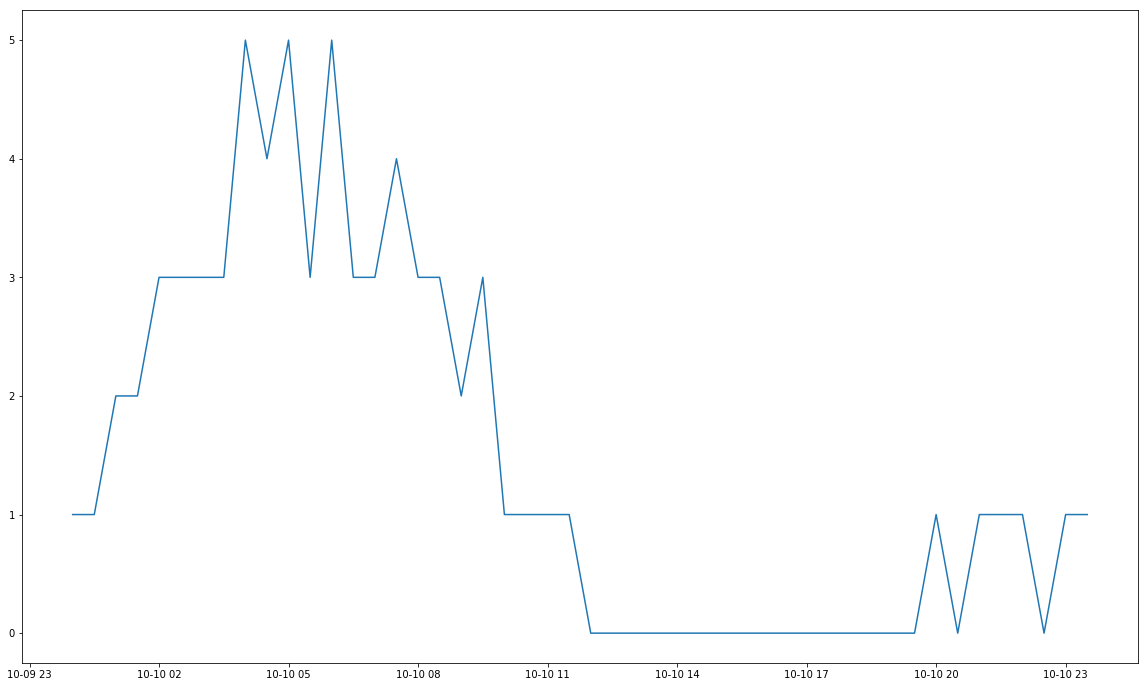

24
深圳创维大厦充电站


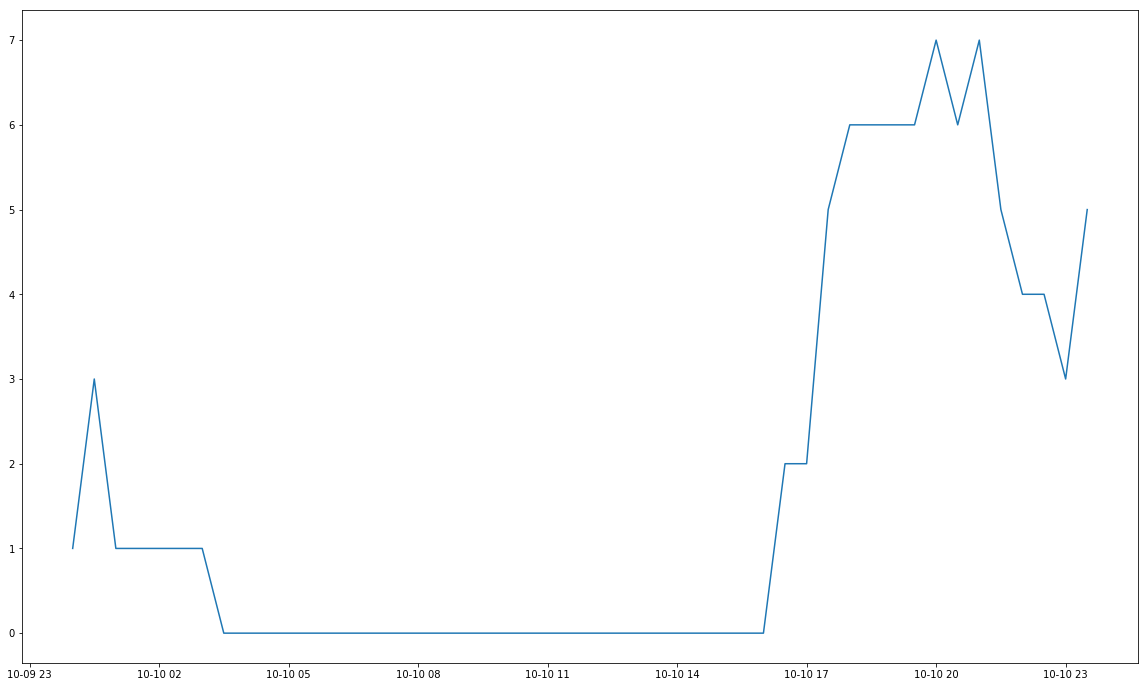

25
深圳百丽大厦充电站


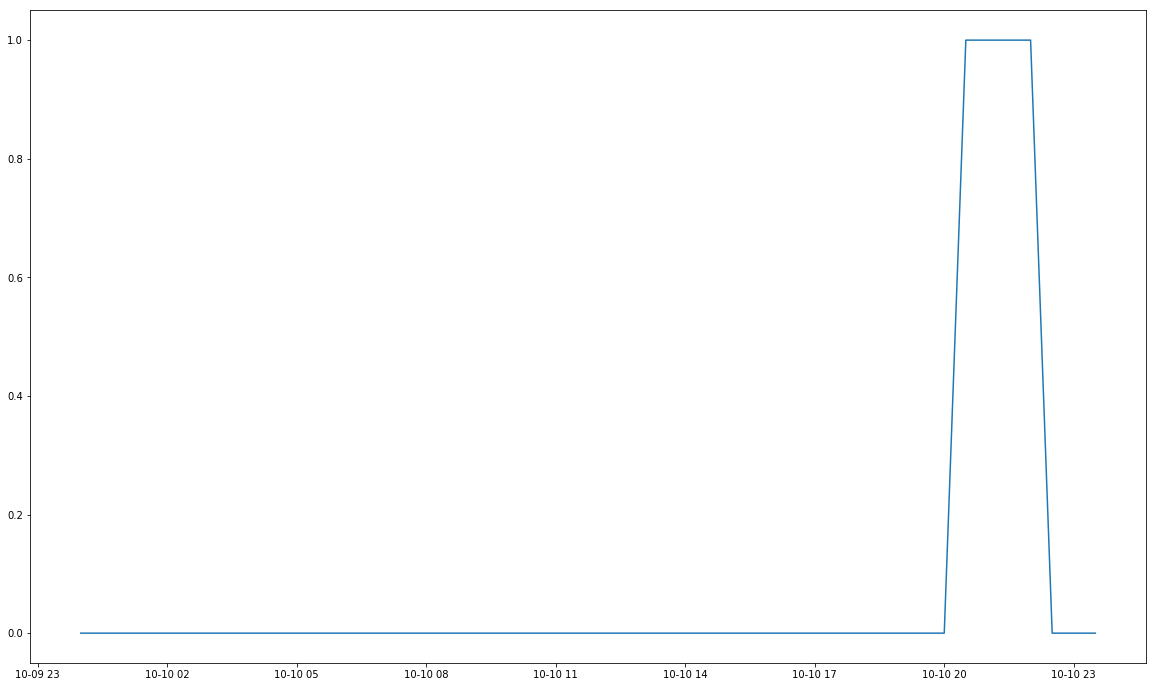

26
深圳南景新村充电站


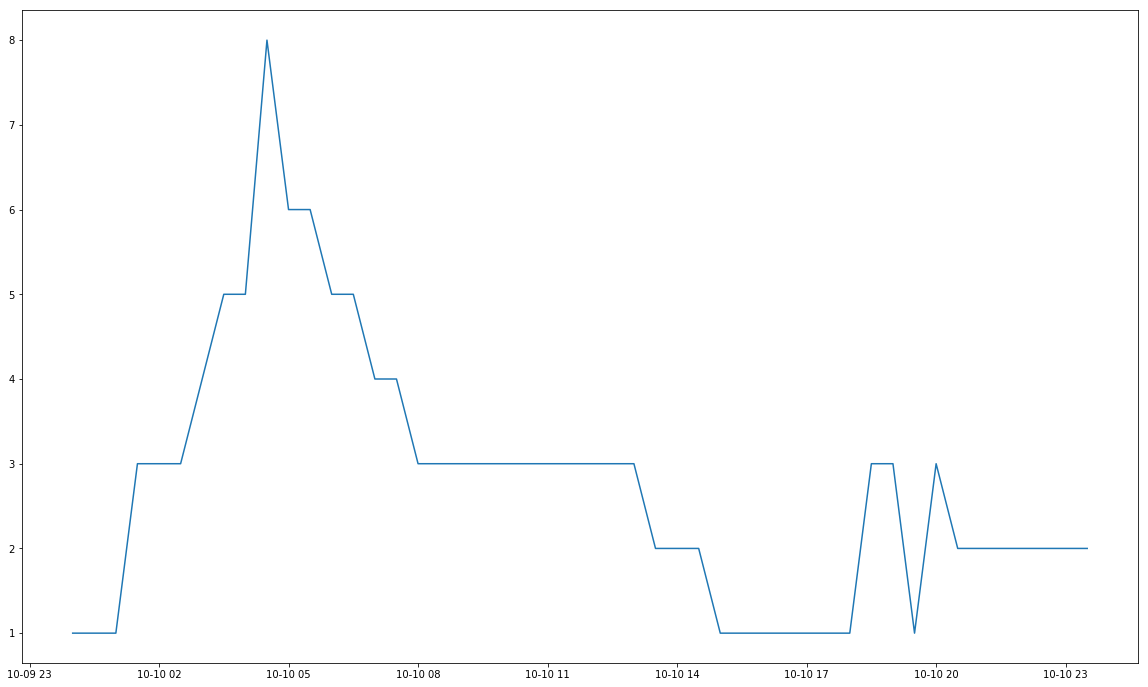

27
深圳龙华人人乐充电站


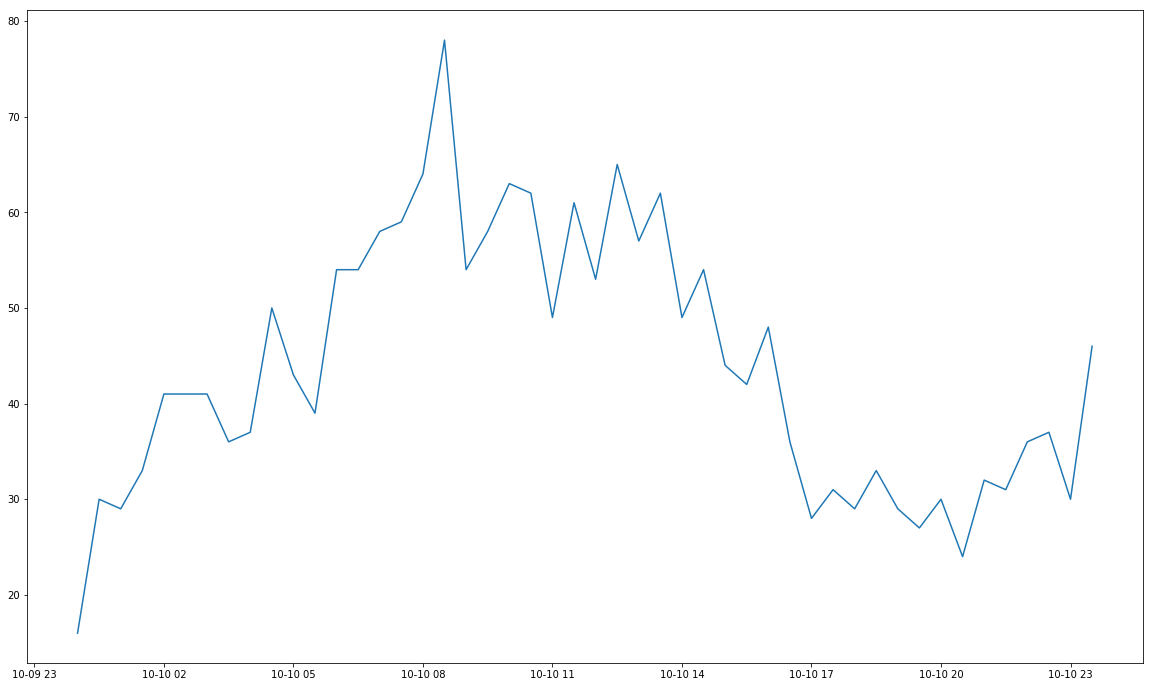

28
深圳深业U中心充电站


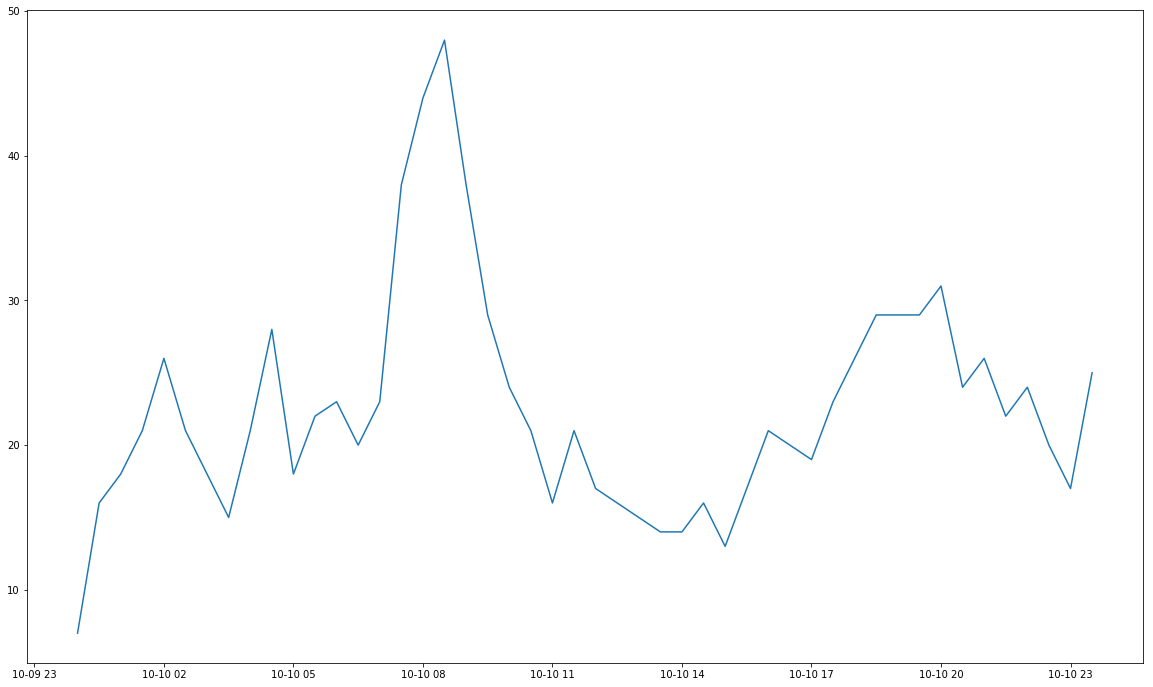

29
深圳湾美花园充电站


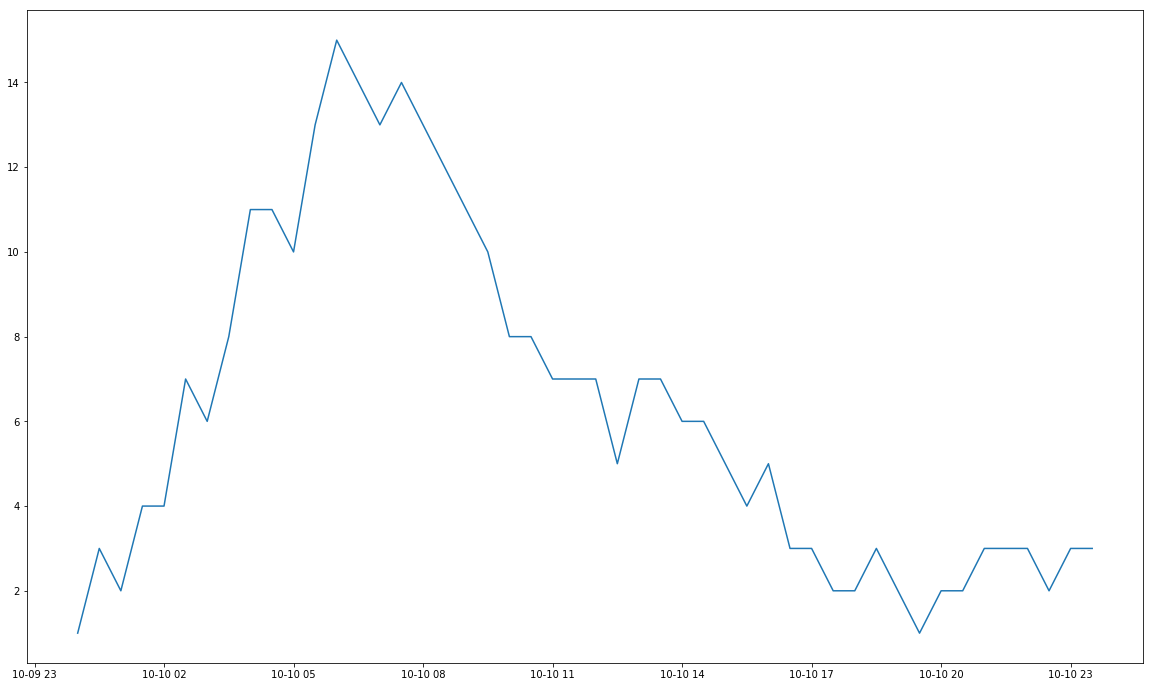

30
深圳金山大厦充电站


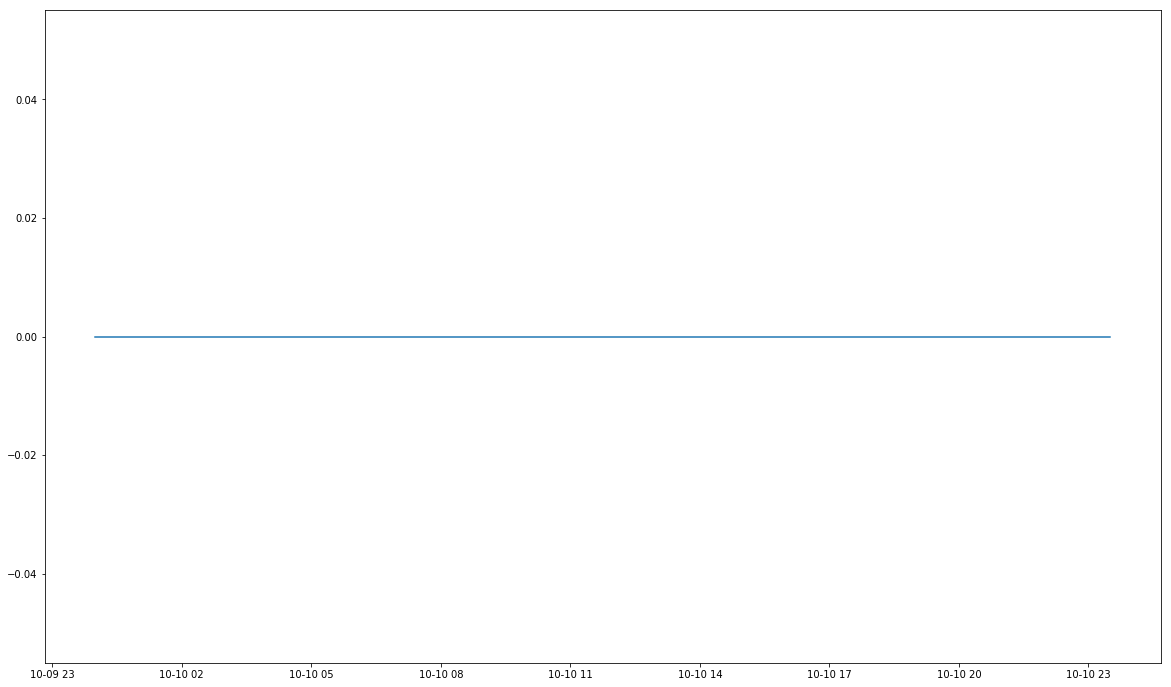

31
深圳万菱New寓充电站


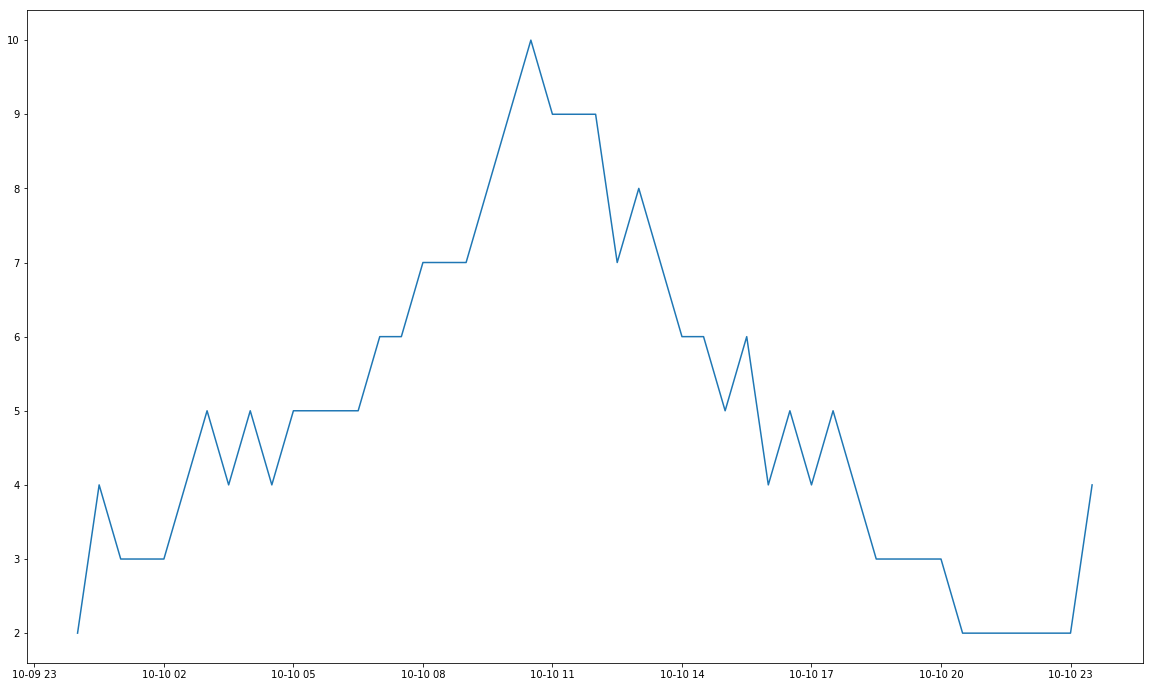

32
深圳鼎新大厦充电站


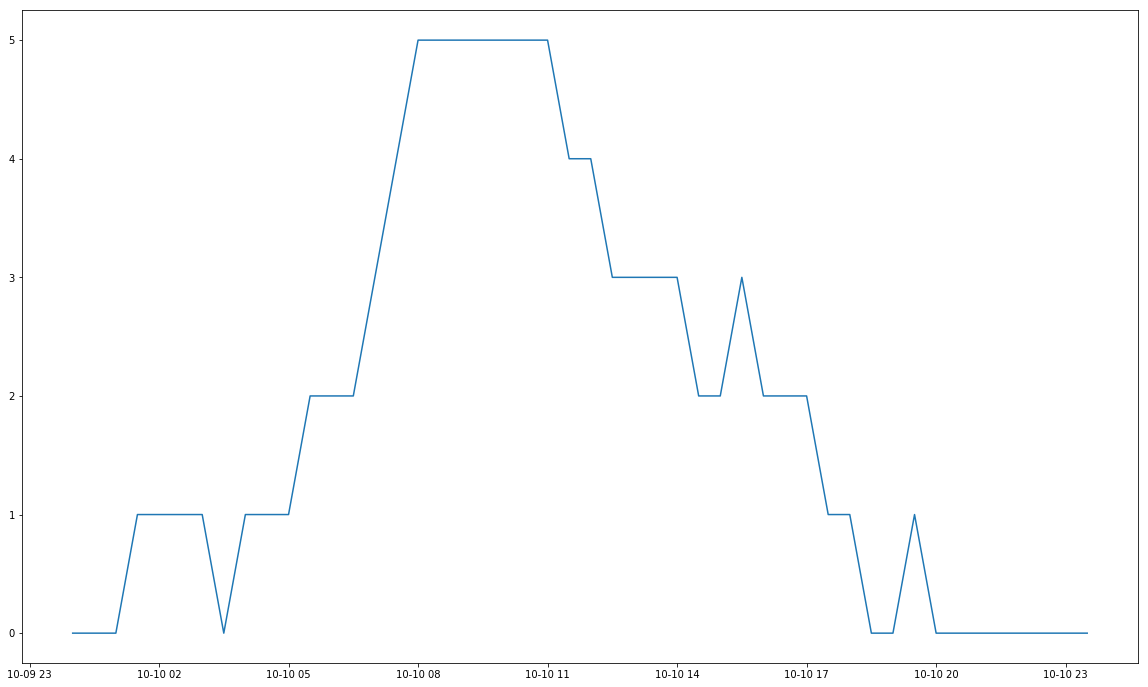

33
深圳天安天展大厦充电站


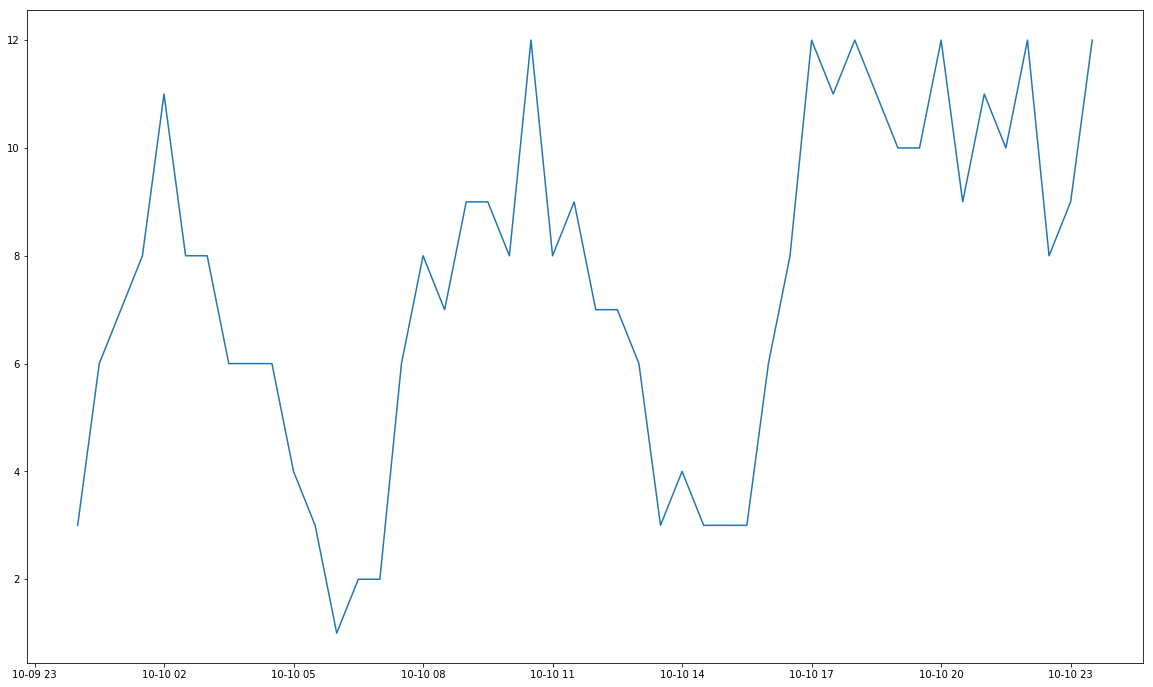

34
深圳恒江大厦充电站


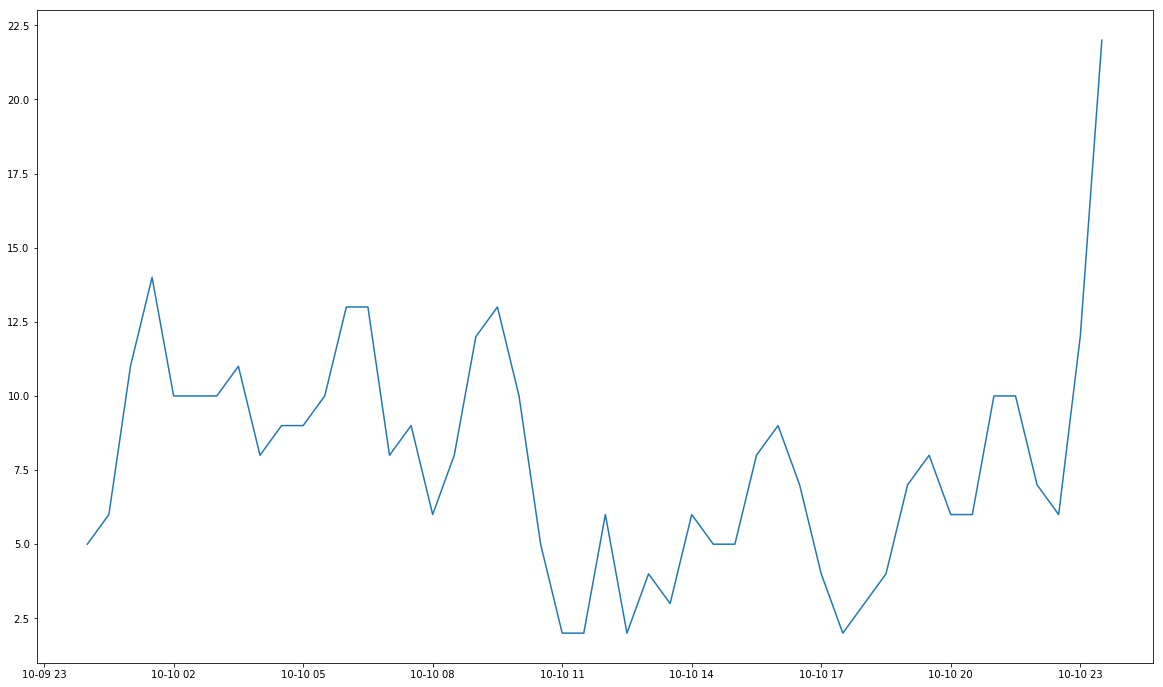

35
深圳天安数码时代充电站


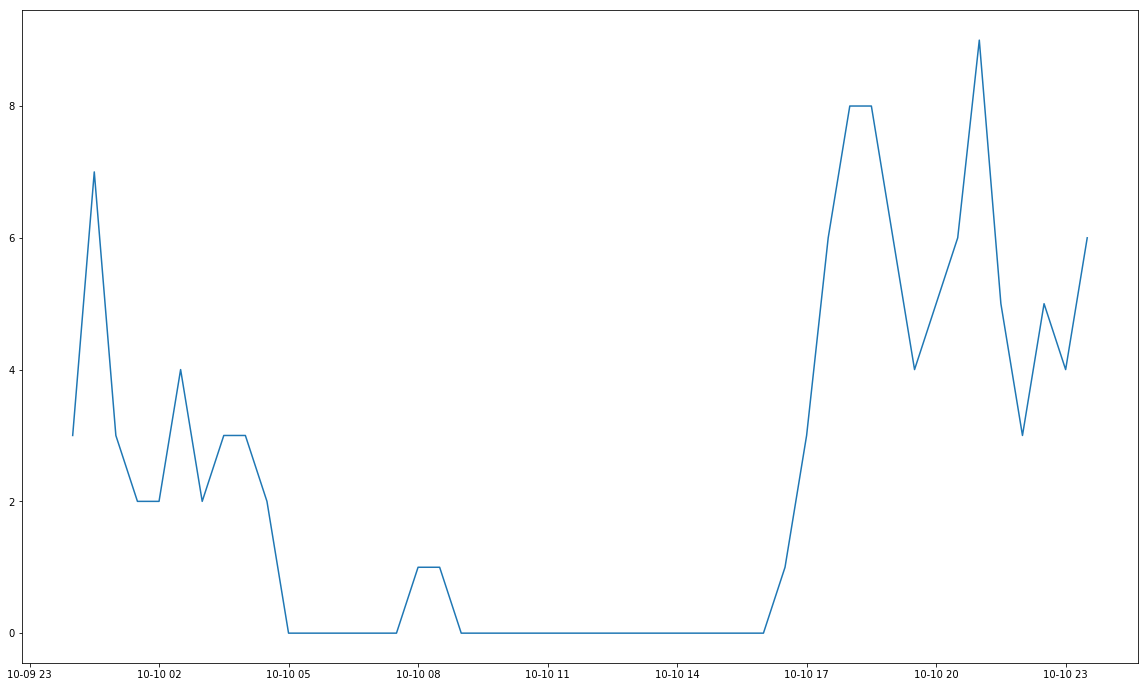

36
深圳天安创业园充电站


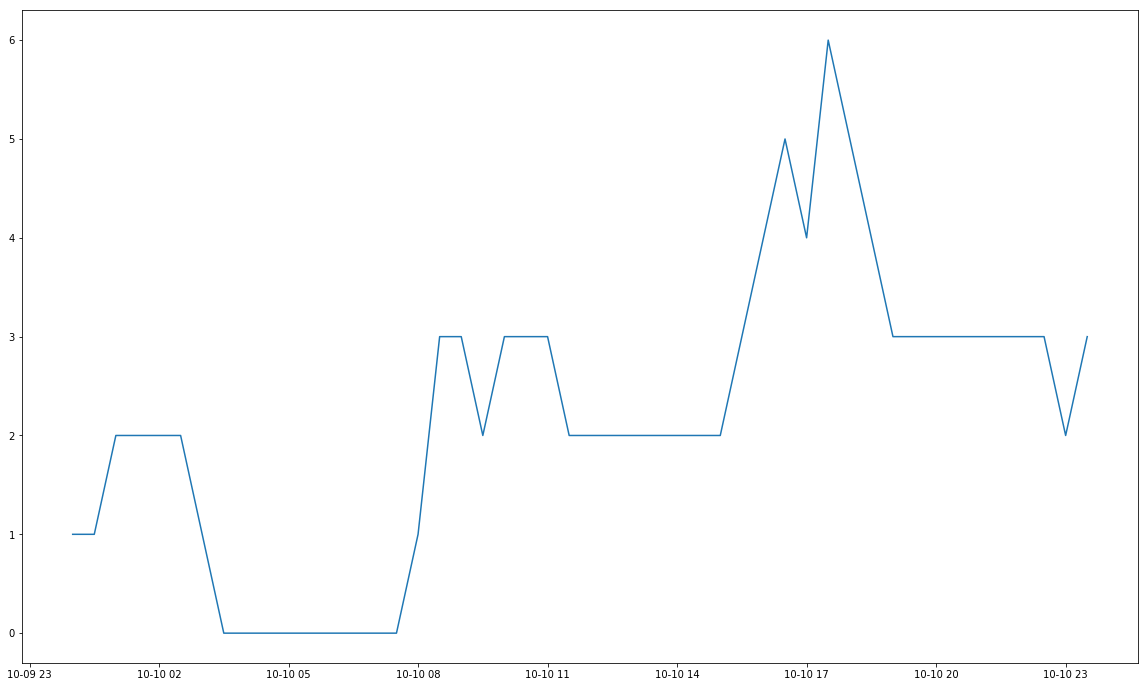

37
深圳景元大厦充电站


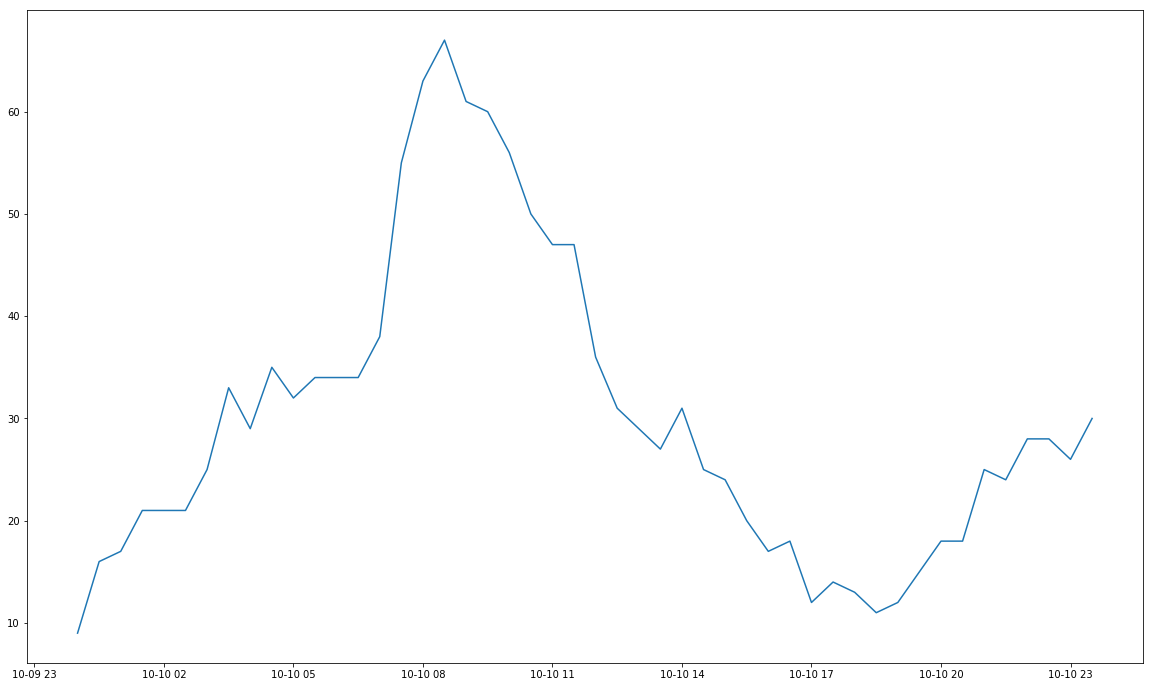

38
深圳天御香山二期充电站


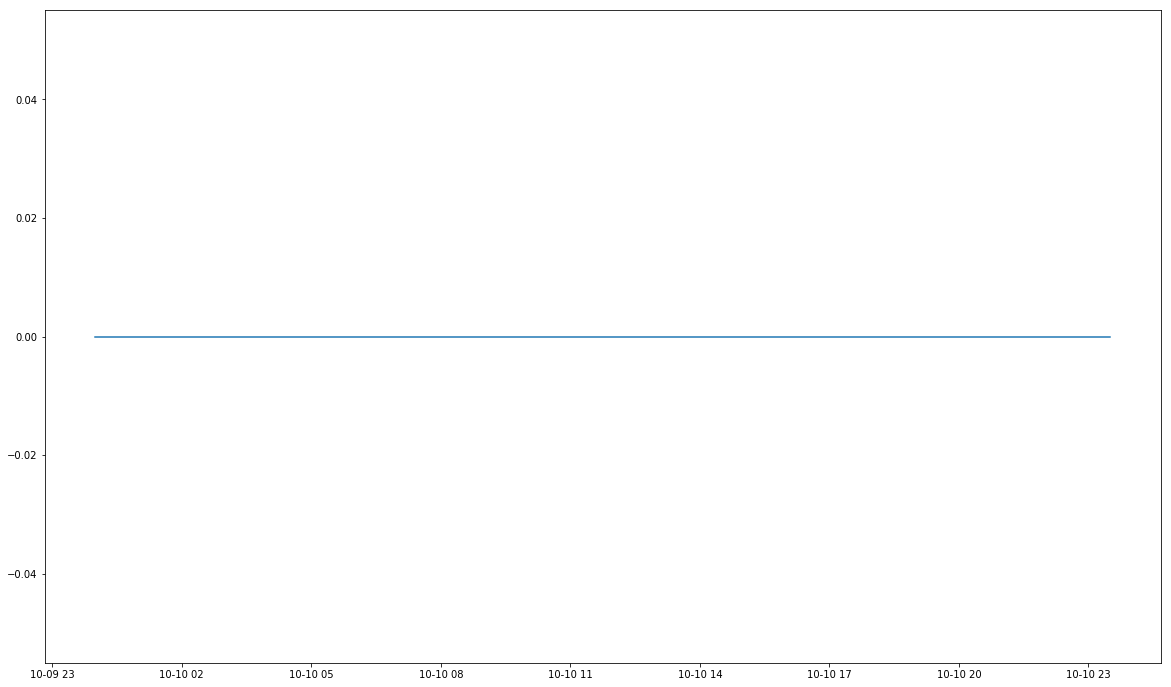

39
深圳东方都会大厦充电站


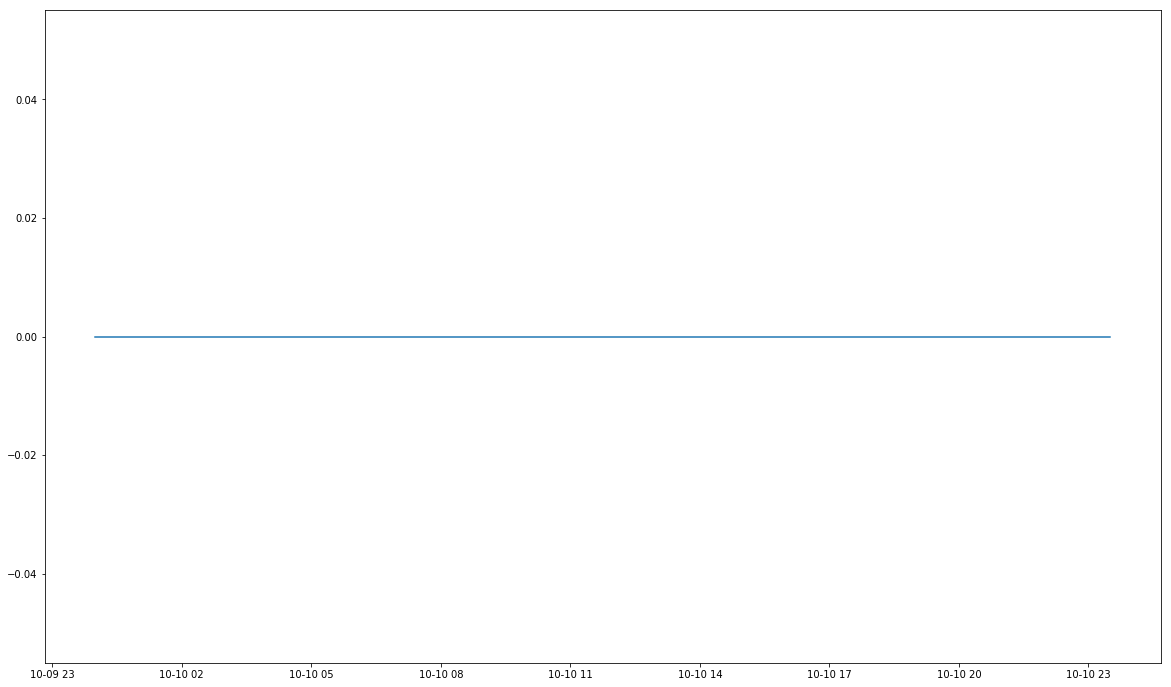

40
深圳湾体育中心充电站


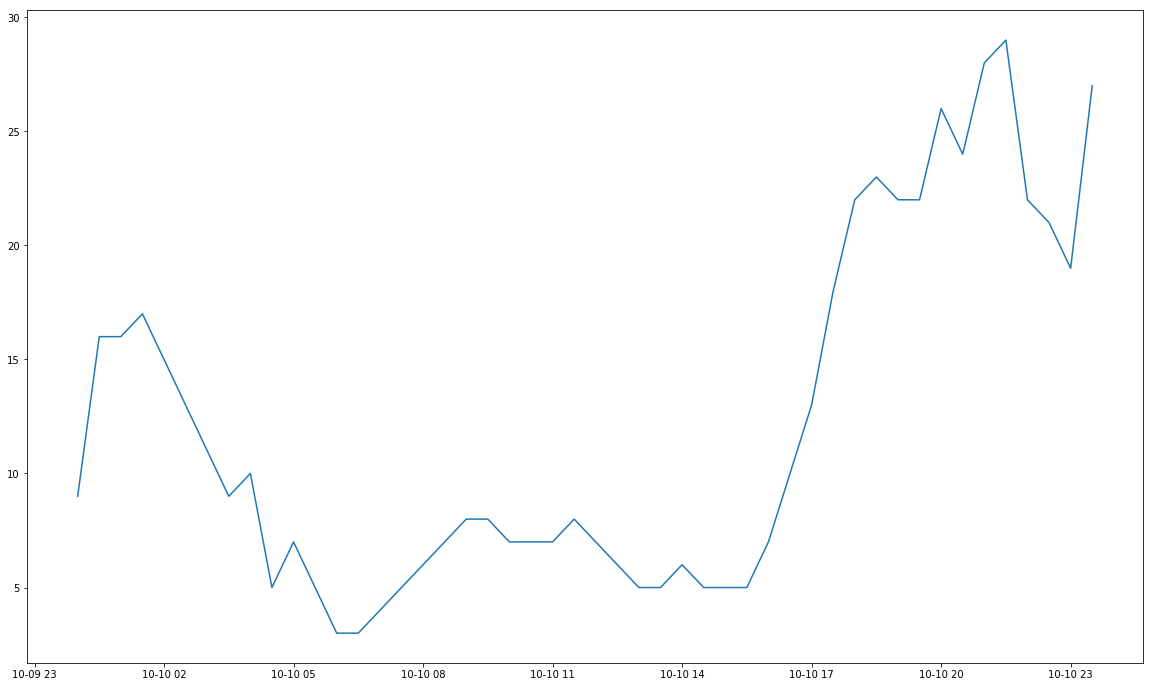

41
深圳东方华都大厦充电站


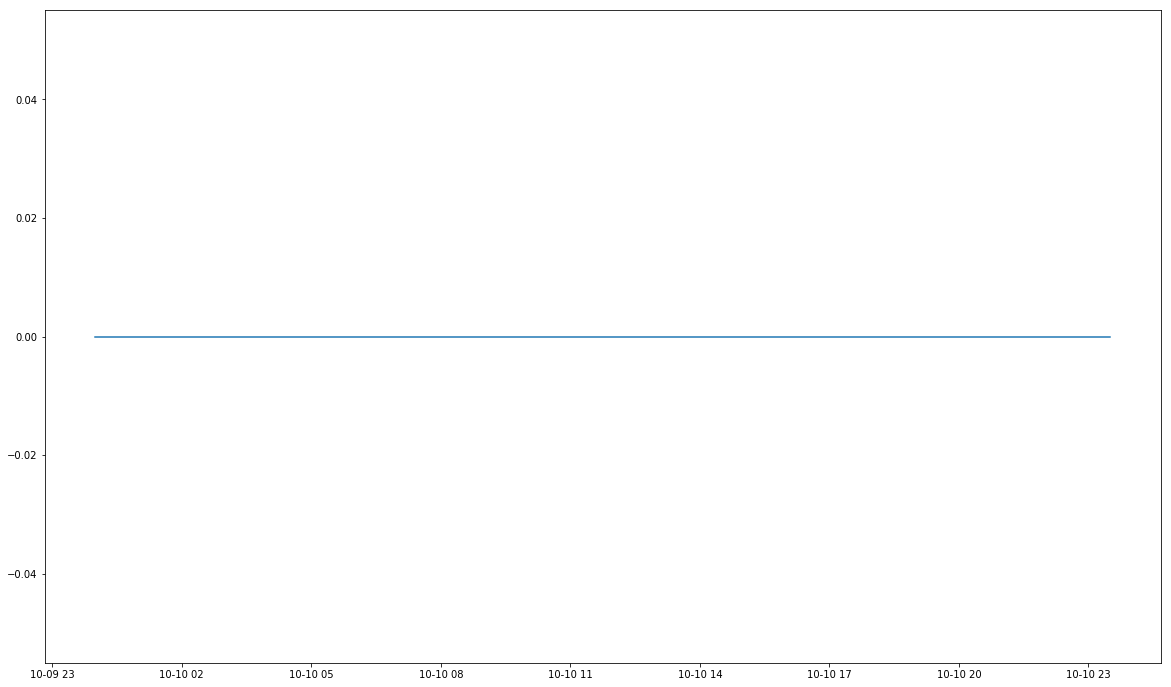

42
深圳金骐智谷充电站


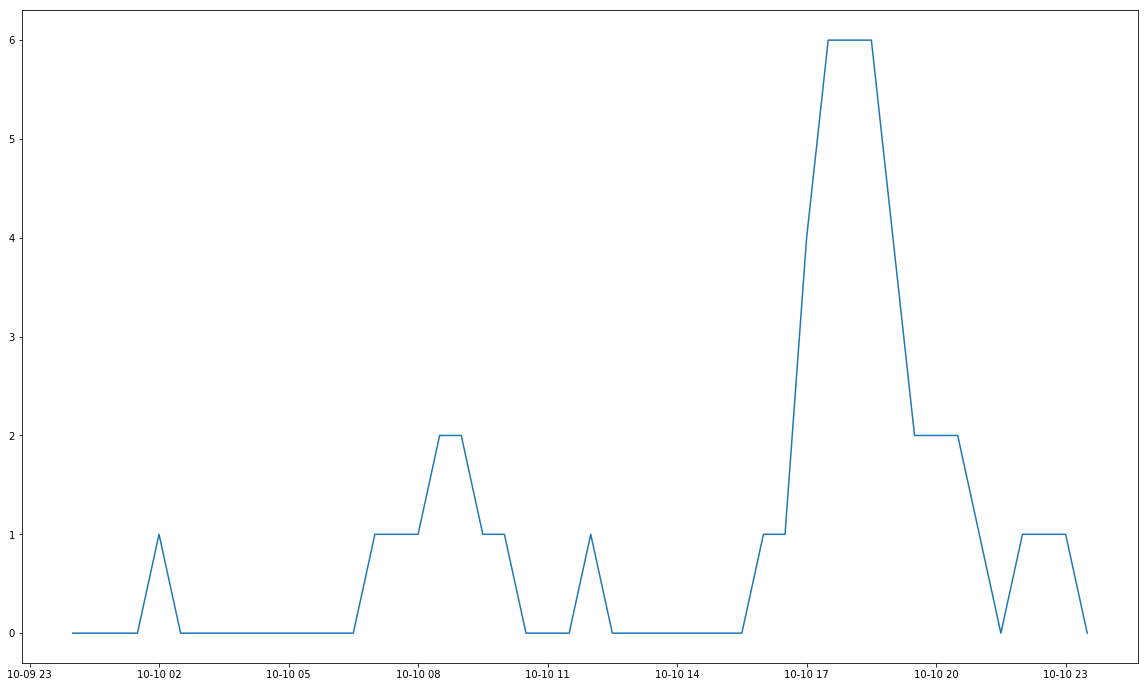

43
深圳广田集团大厦充电站


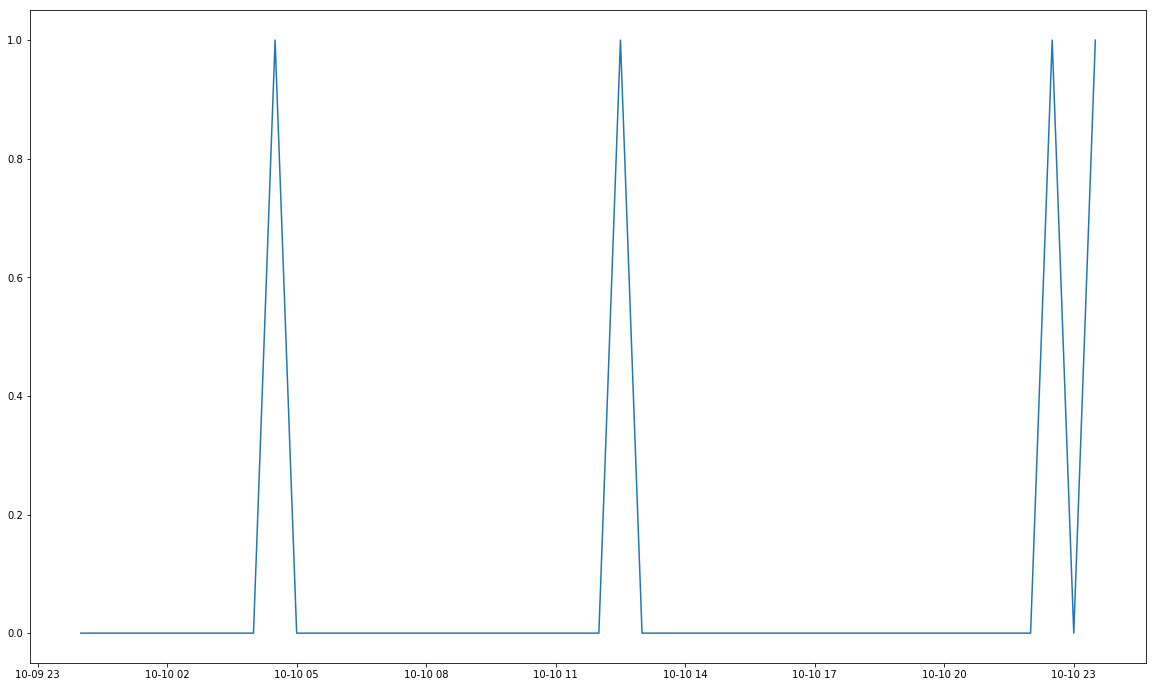

44
深圳民生金融大厦充电站


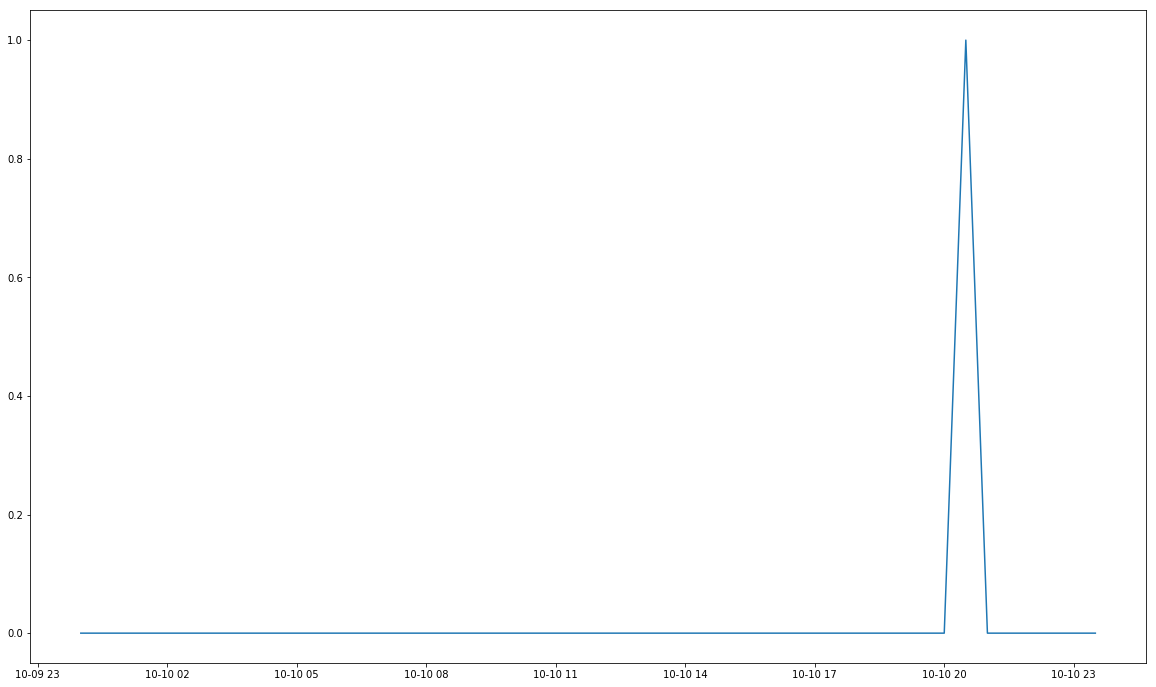

45
深圳汇聚创新园充电站


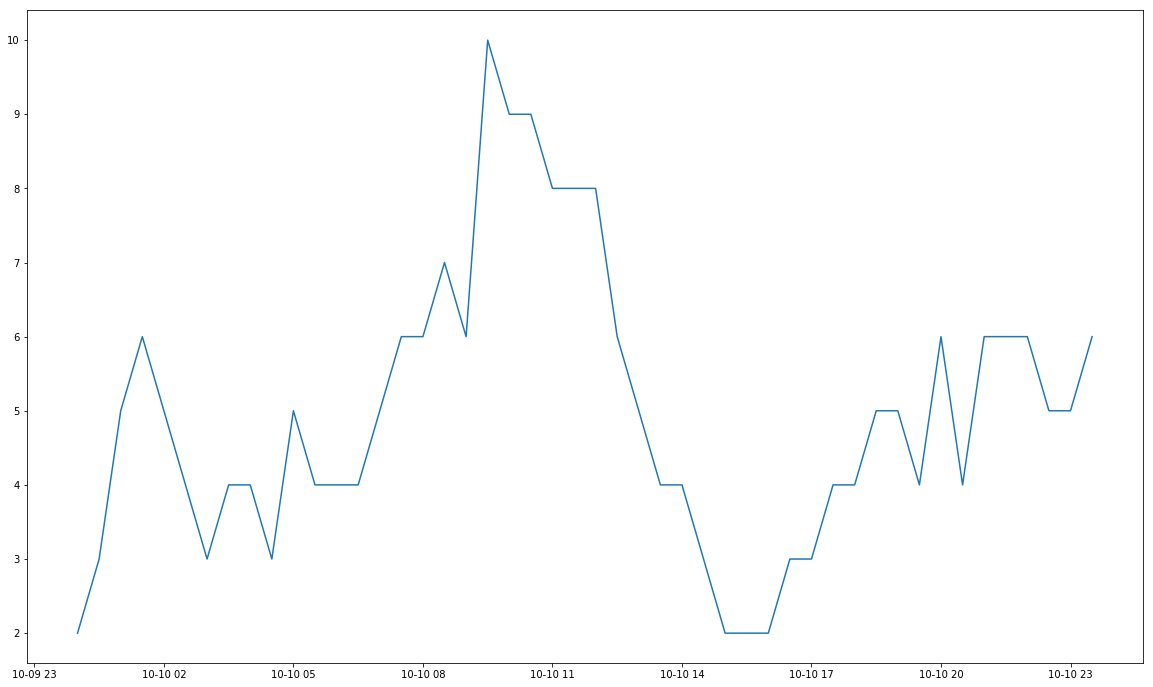

46
深圳宝立方充电站


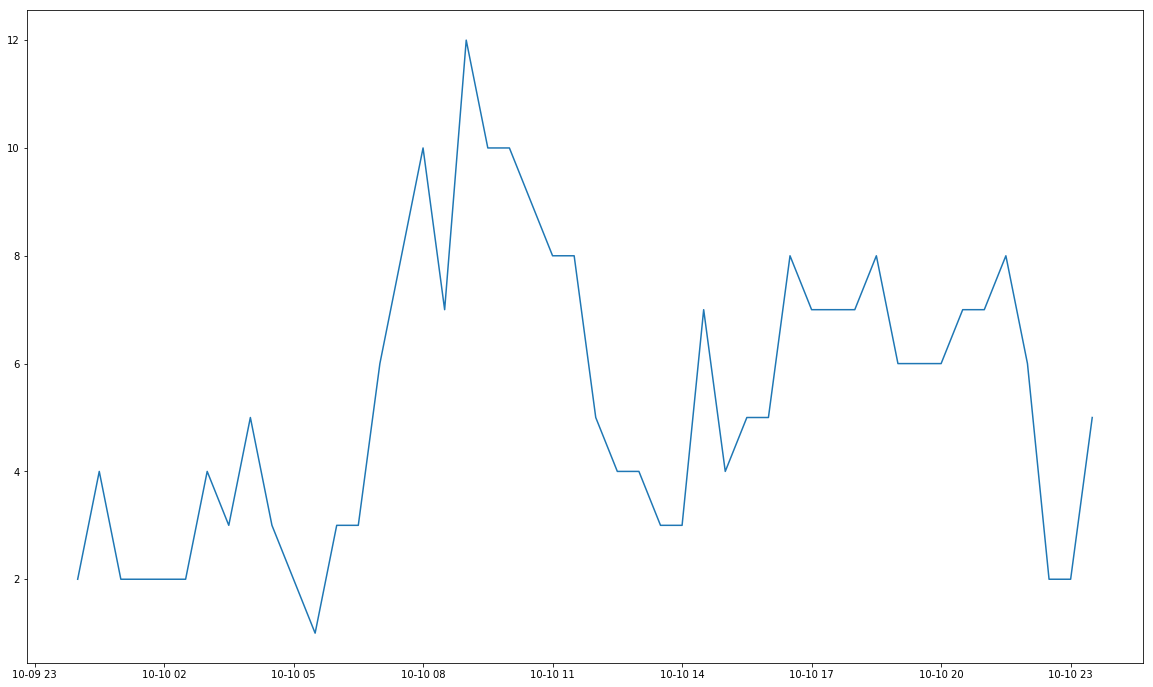

47
深圳凯欣园充电站


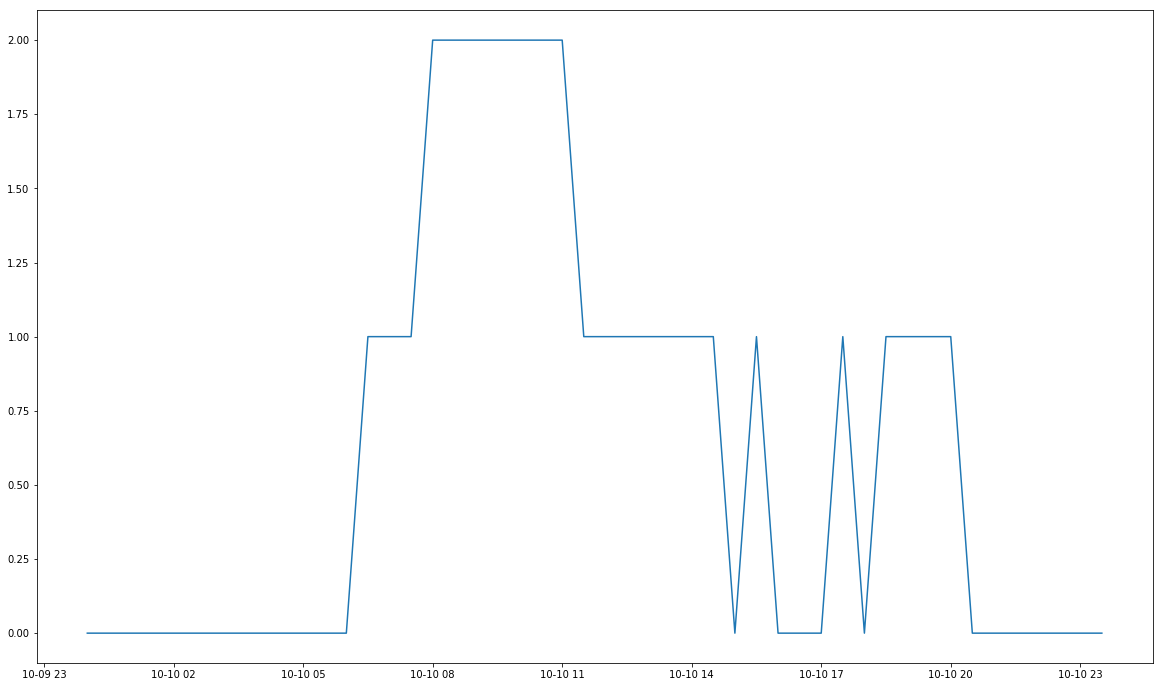

48
深圳农科商务楼充电站


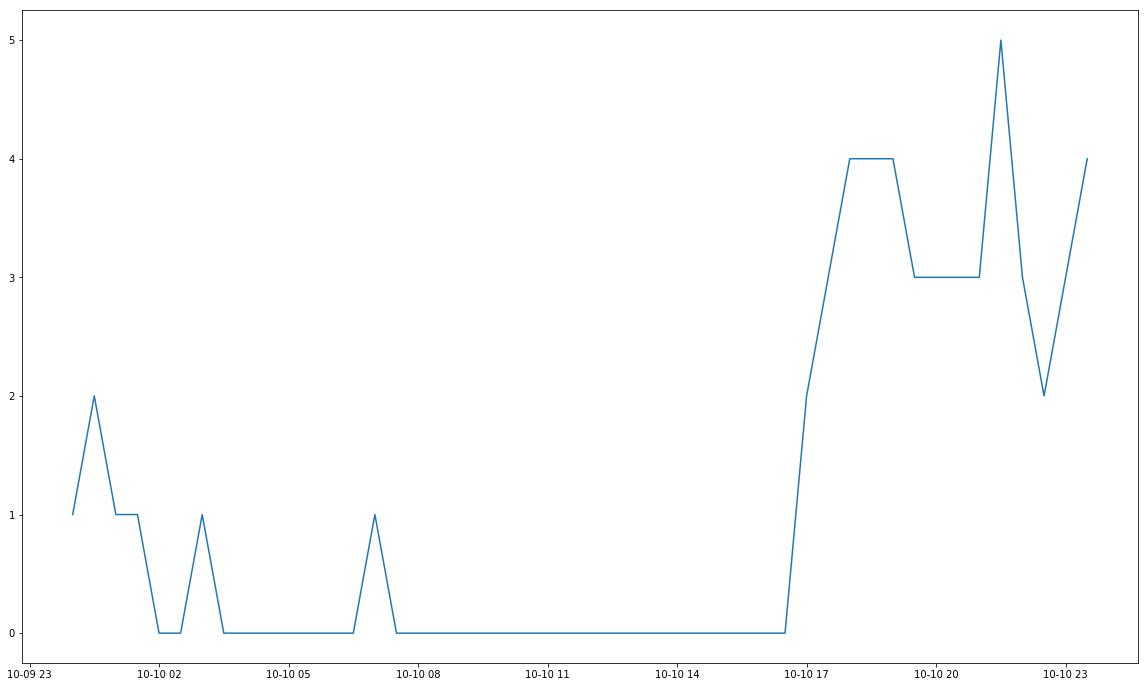

49
深圳朗山酒店充电站


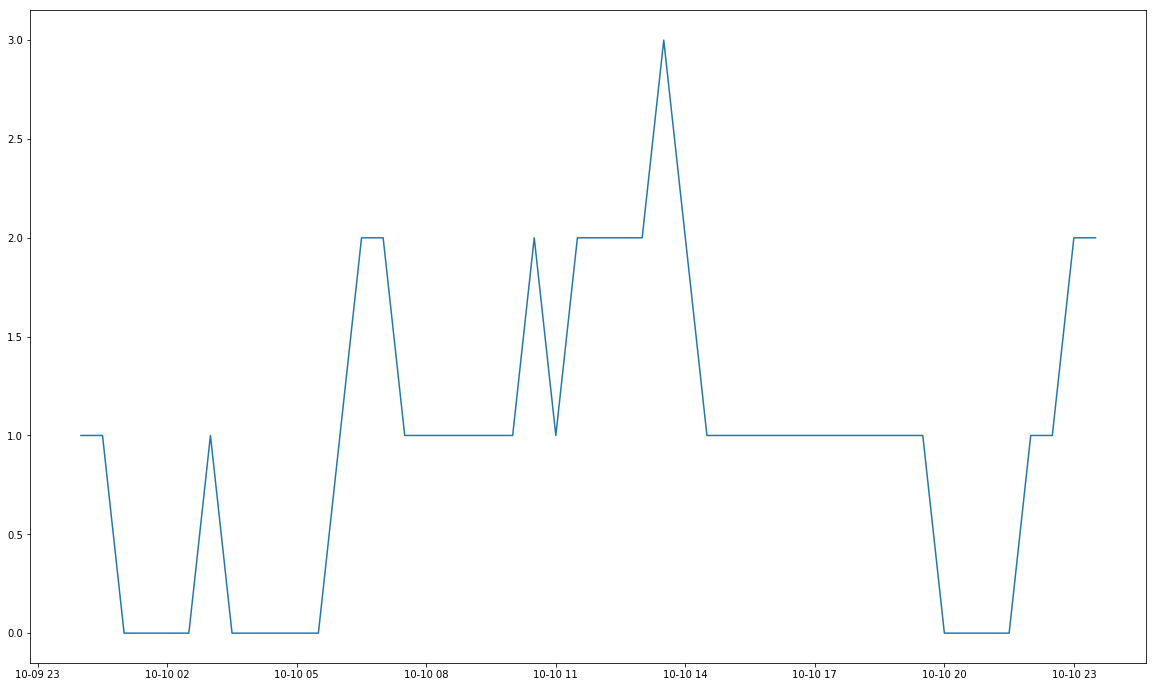

50
深圳集浩大厦充电站


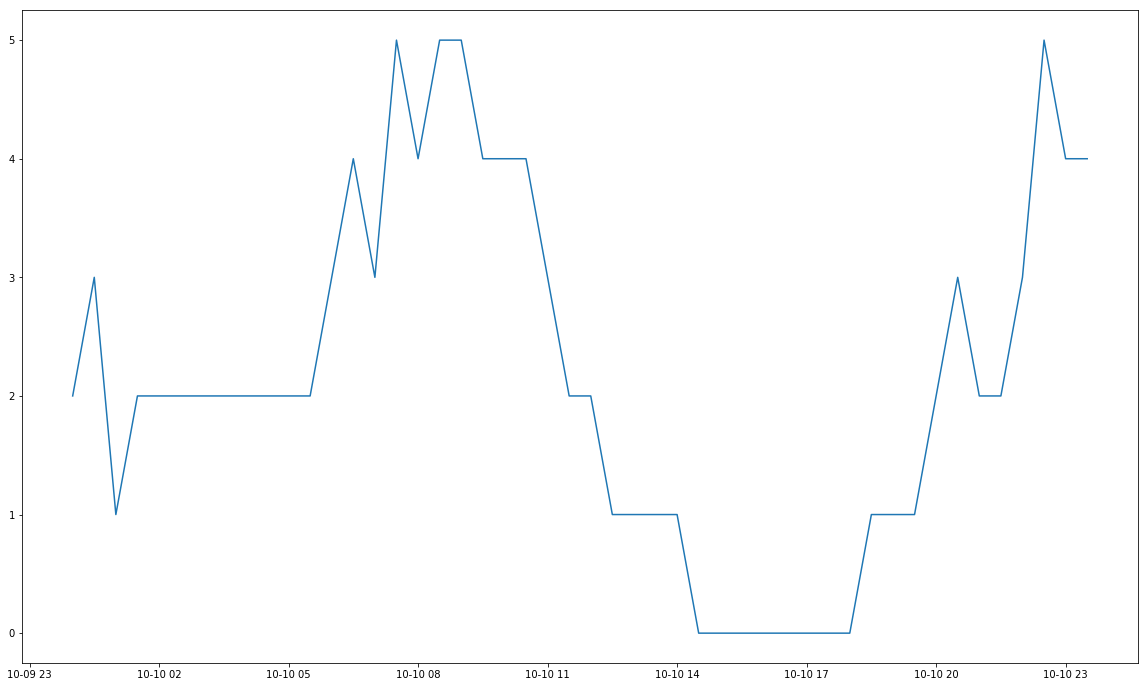

51
深圳万科公园里充电站


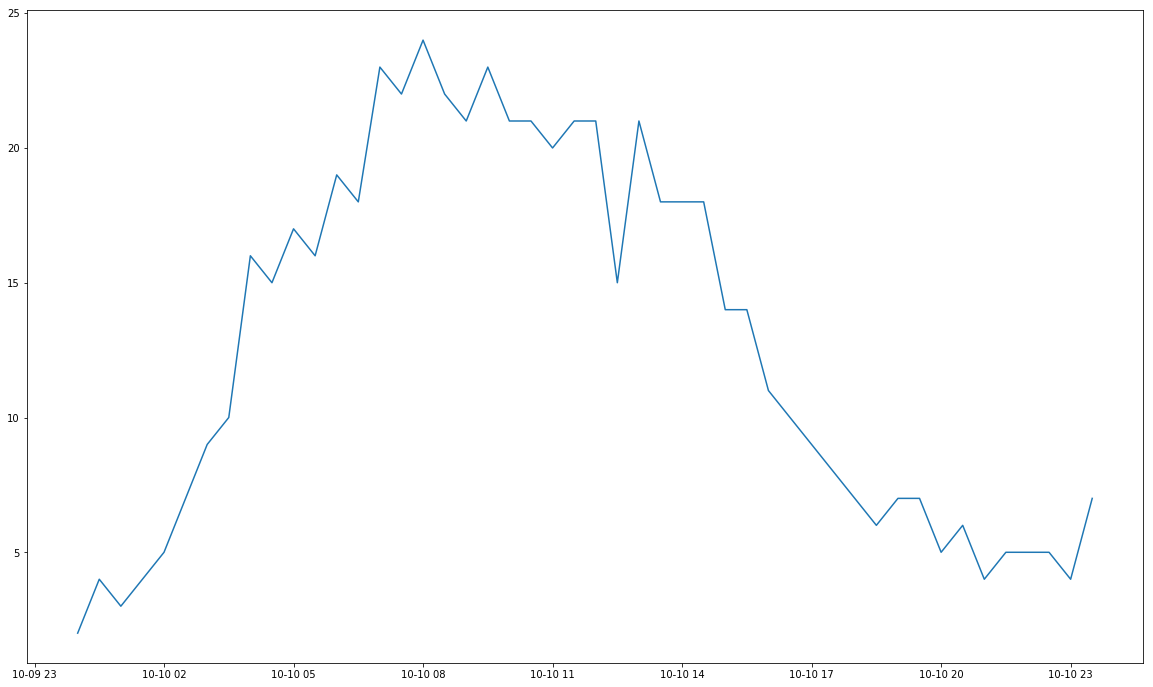

52
深圳博达大厦充电站


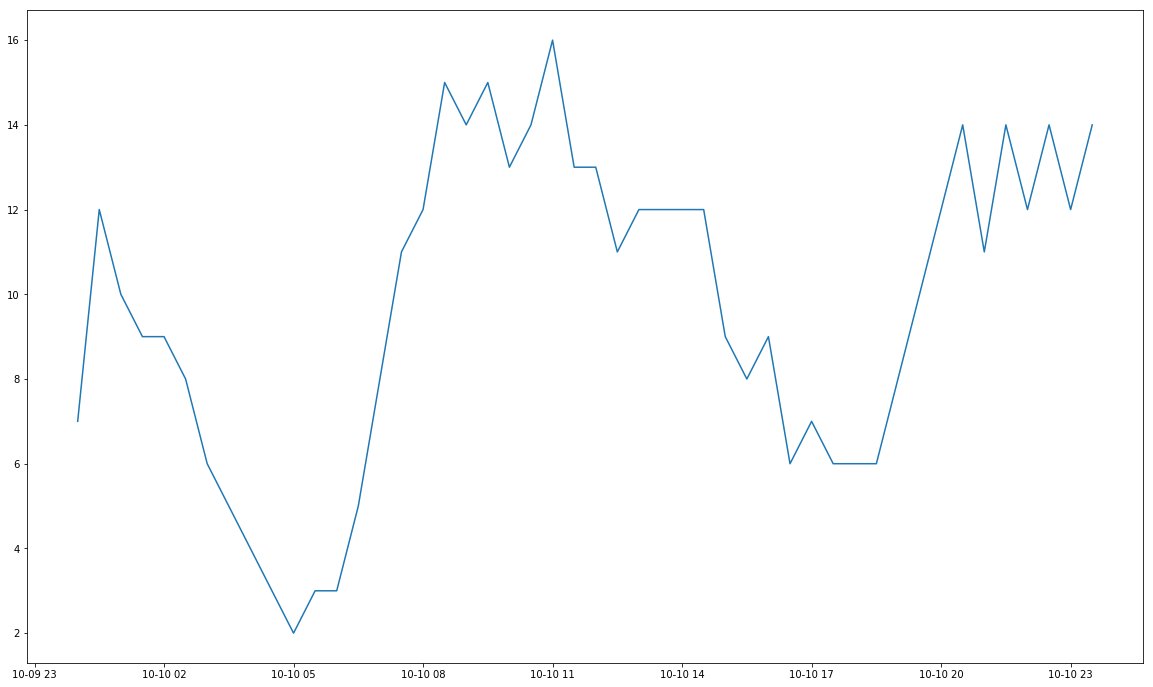

53
深圳崇文花园充电站


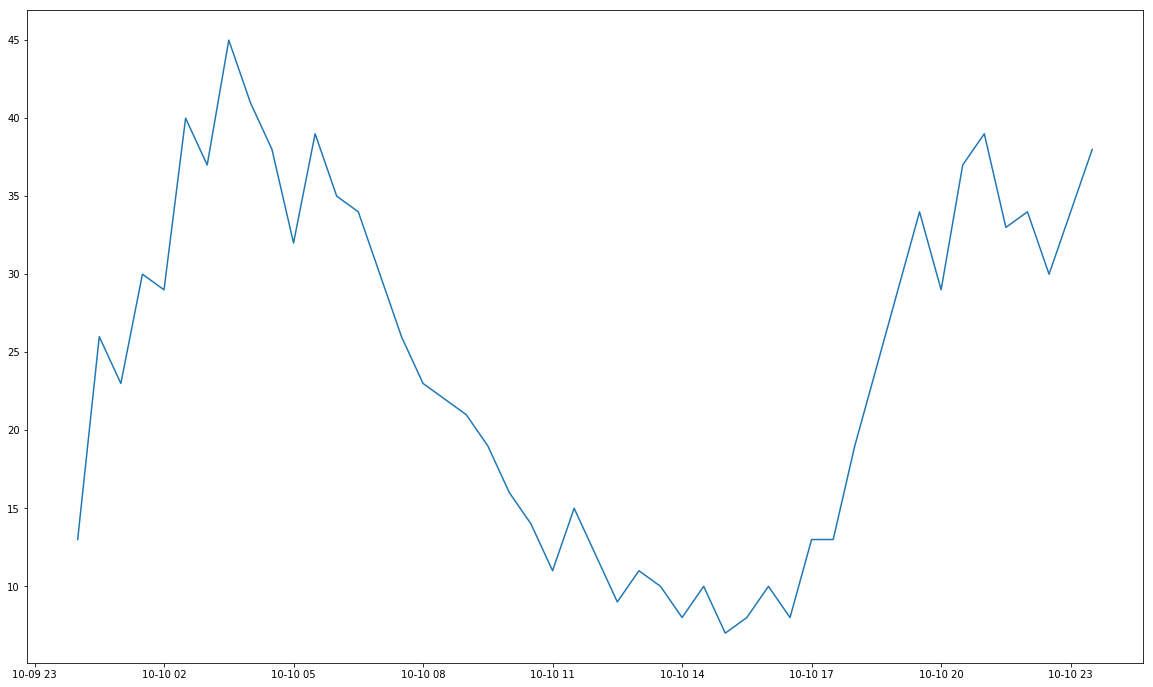

54
深圳鸿隆世纪广场充电站


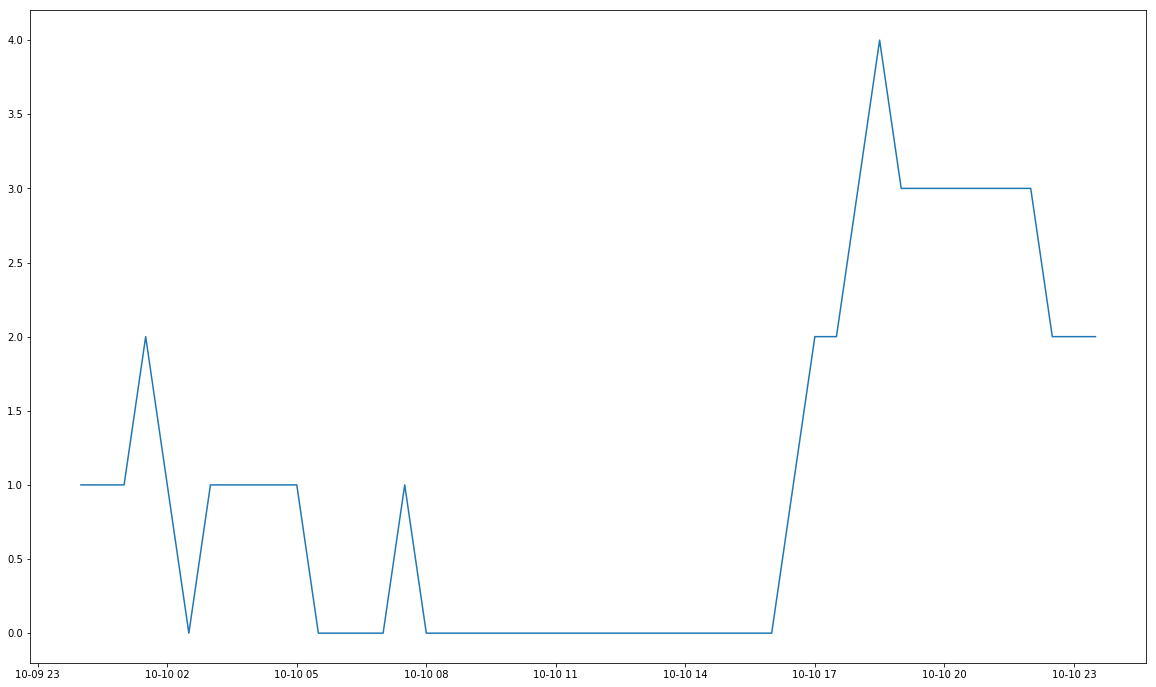

55
深圳瑞思国际大厦充电站


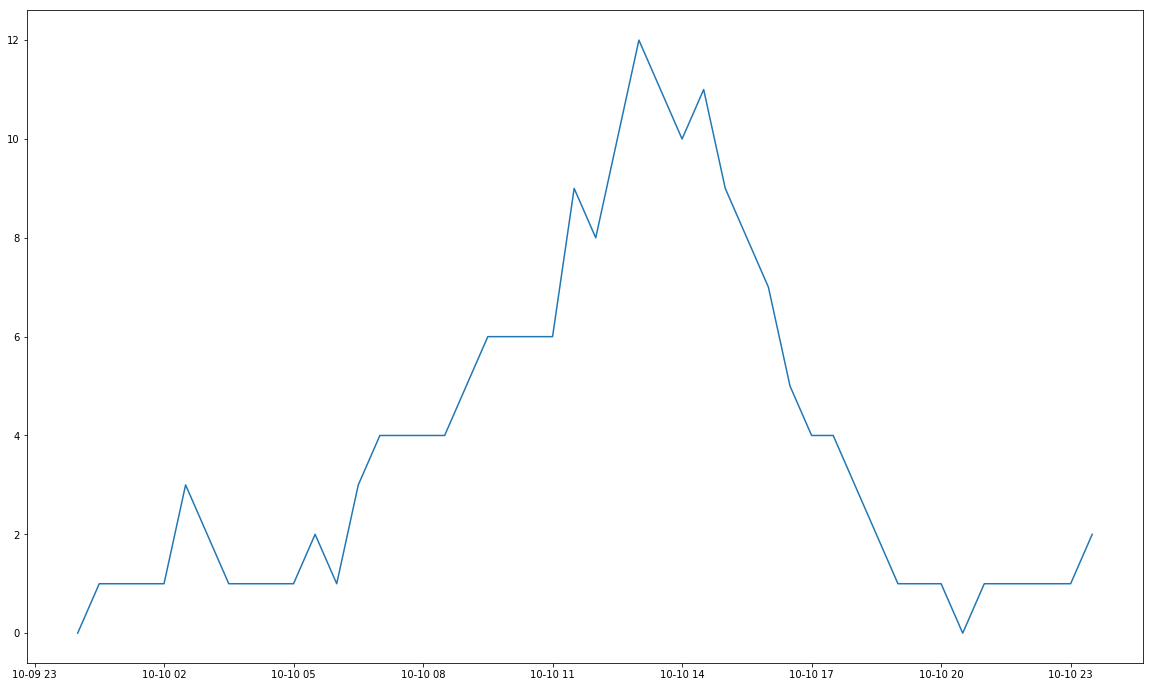

56
深圳锦庐花园充电站


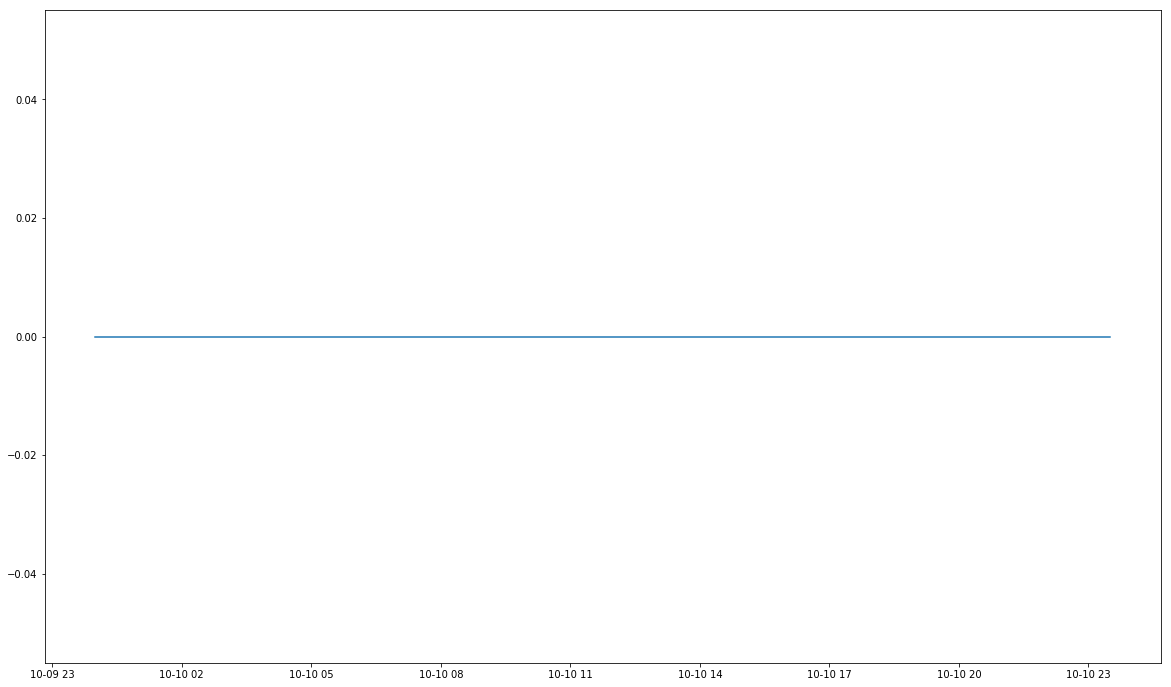

57
深圳华盛盛荟名庭充电站


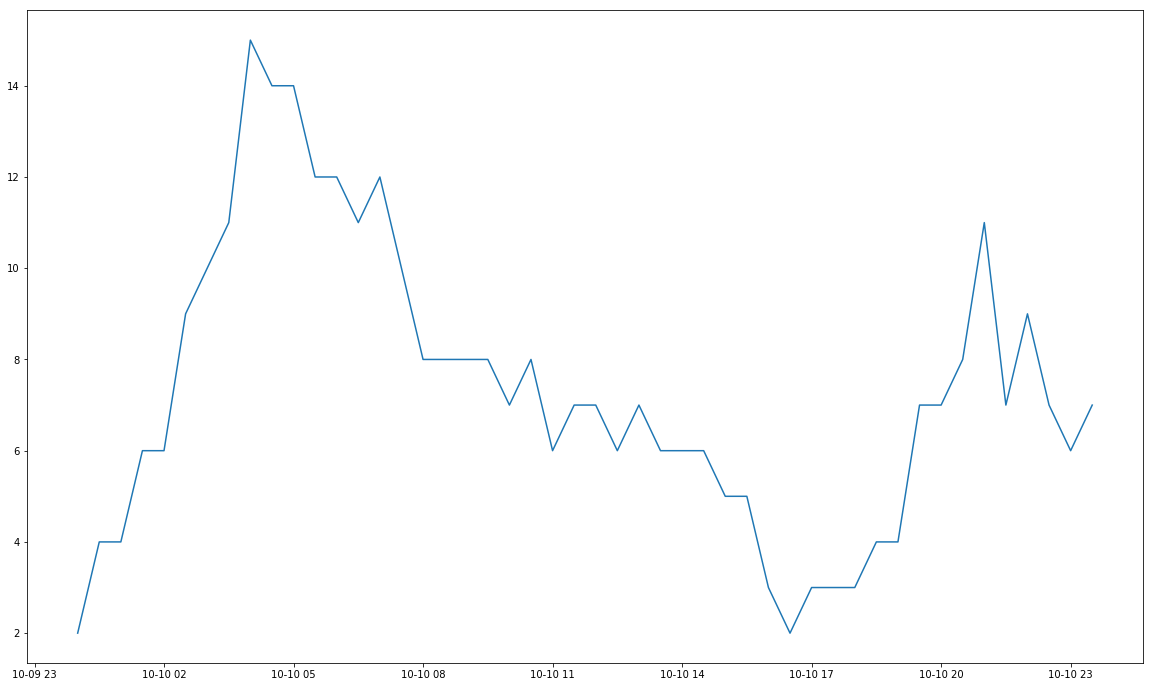

58
深圳西湖林语充电站


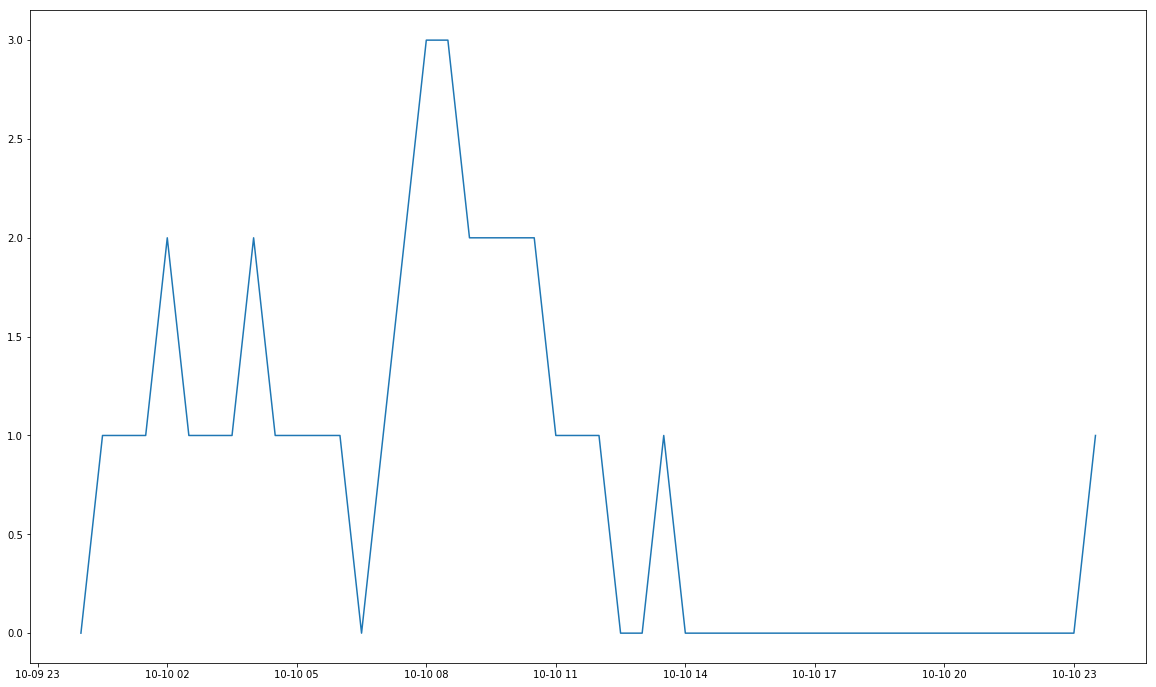

59
深圳雍和园充电站


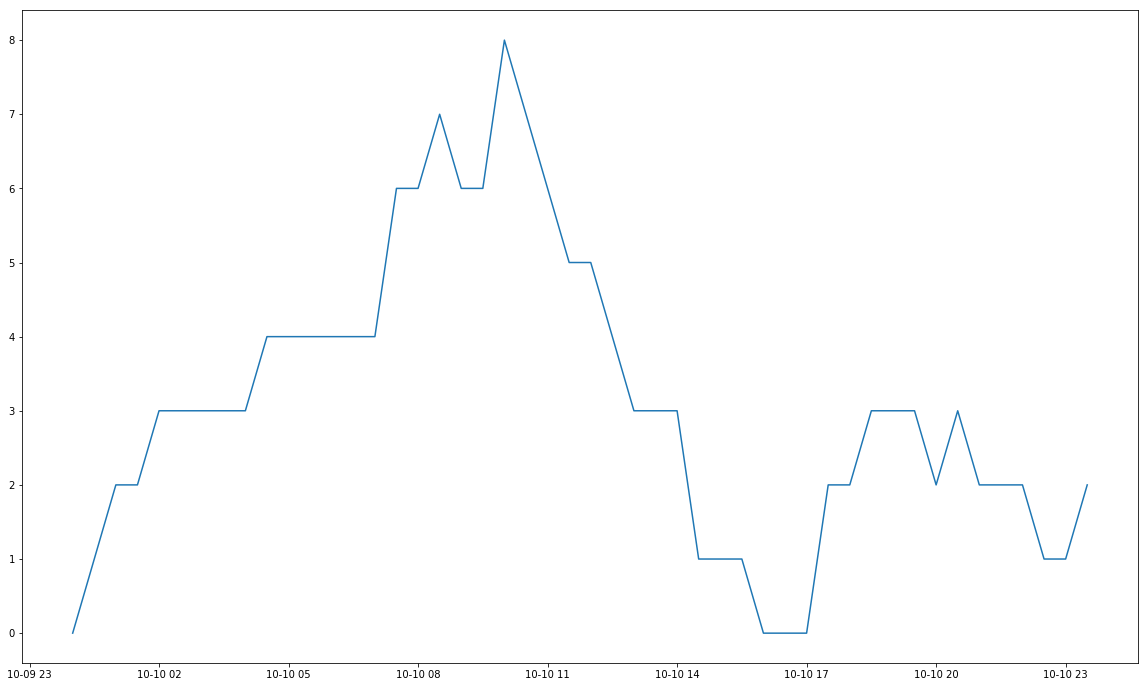

60
深圳紫悦山充电站


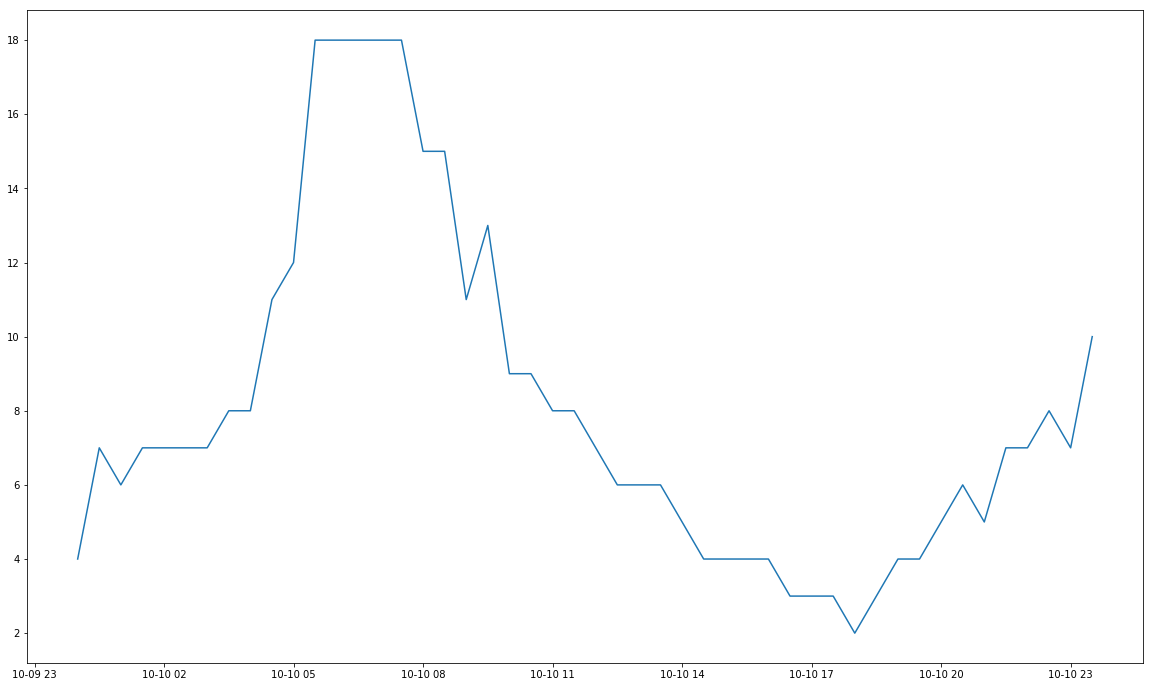

61
深圳海韵大厦充电站


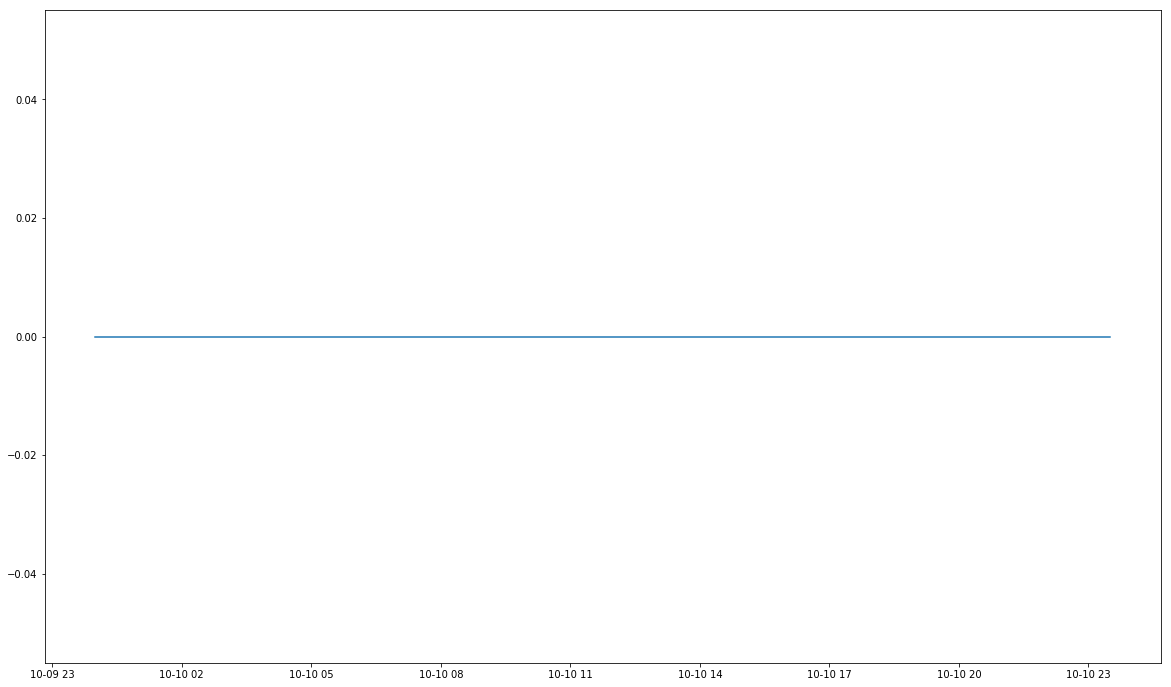

62
深圳南山文体中心充电站


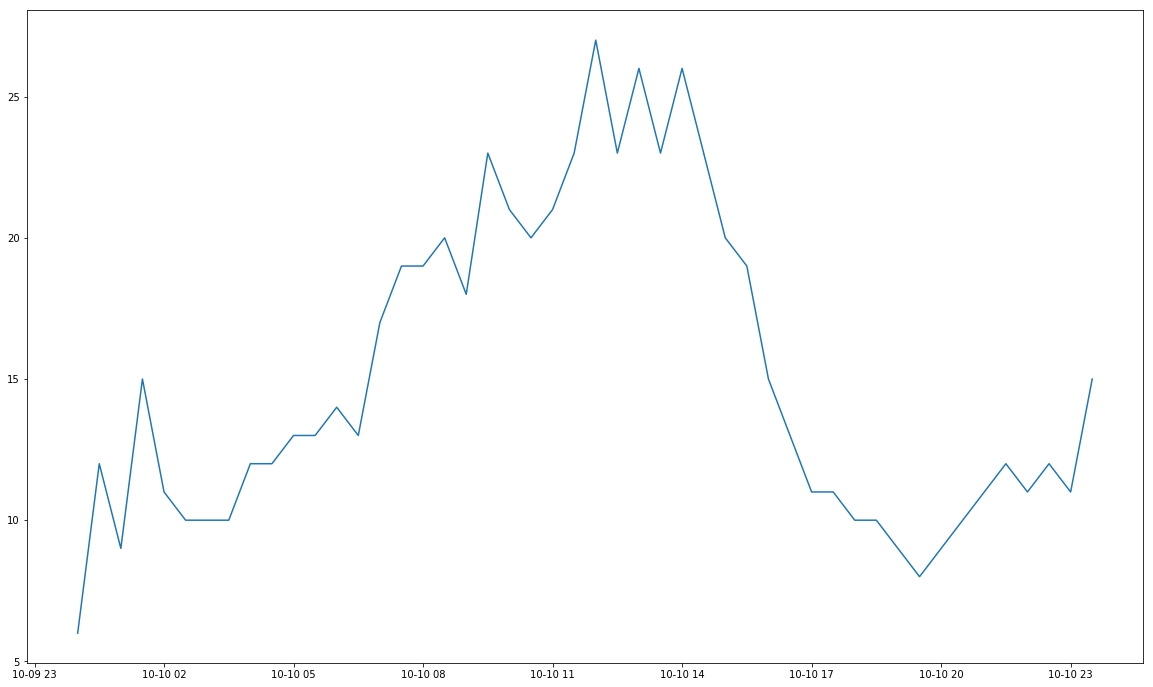

63
深圳祥昭大厦充电站


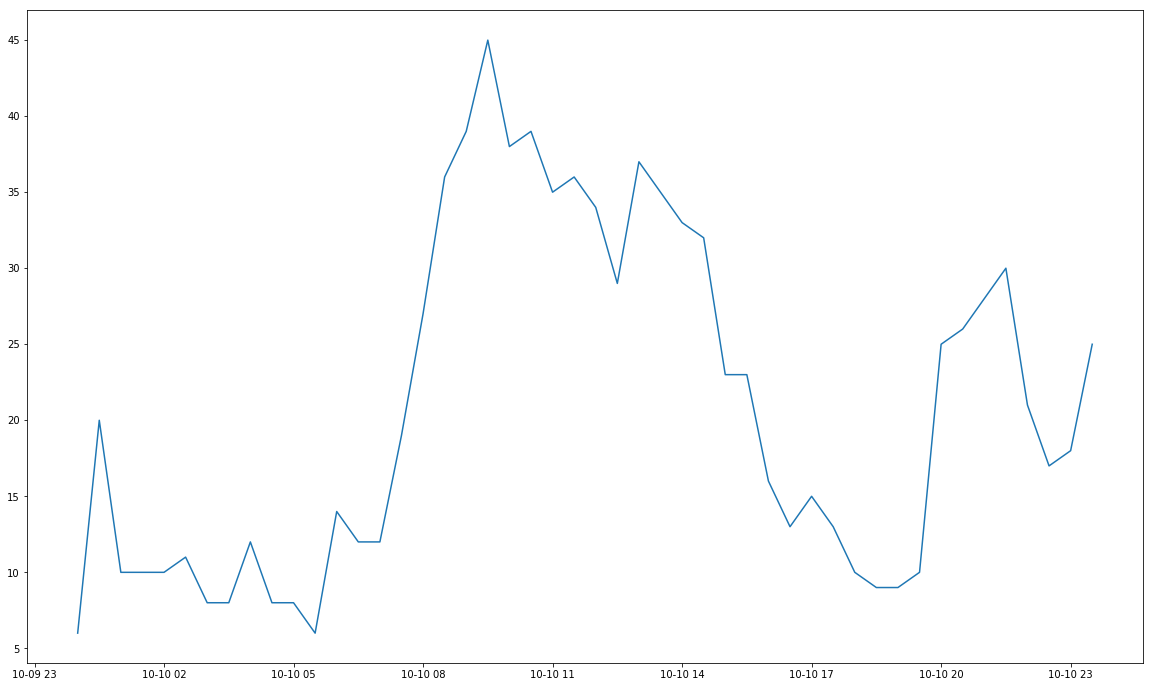

64
深圳幸福城二期充电站


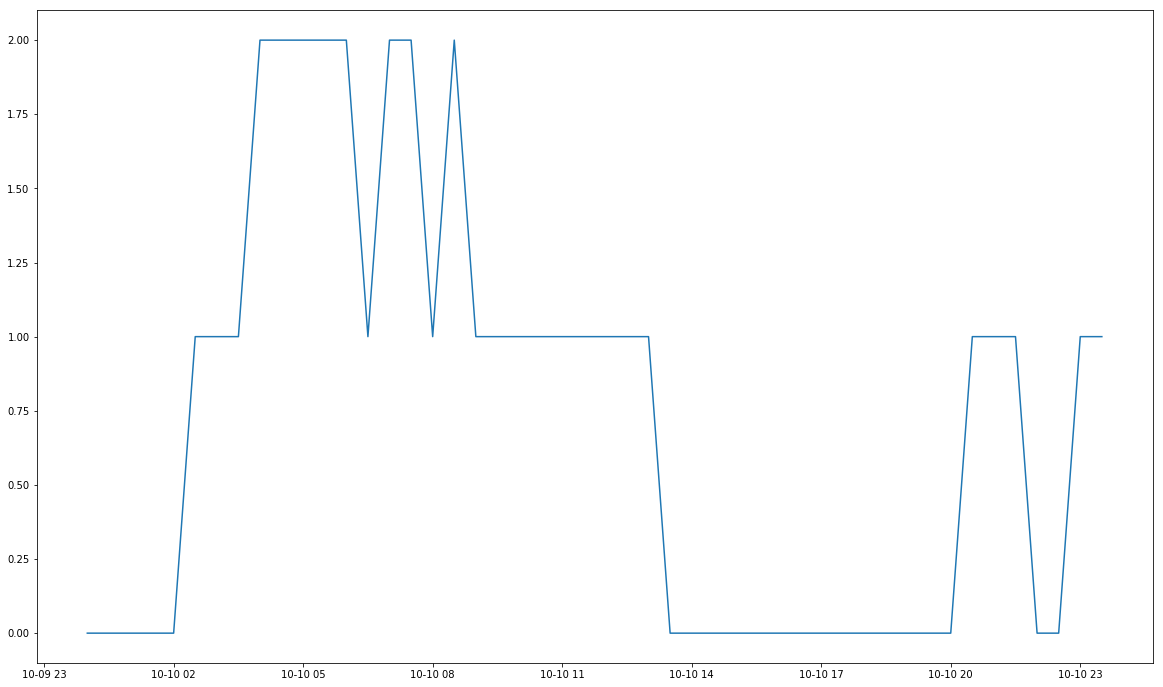

65
深圳朗科大厦充电站


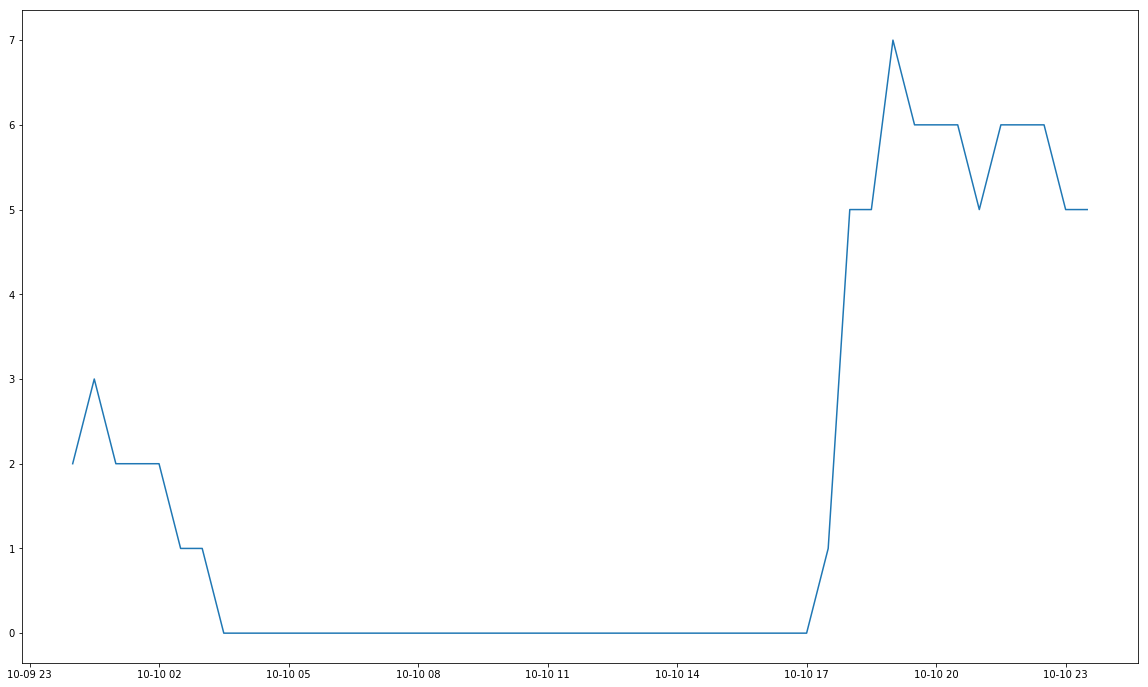

66
深圳尚水天成充电站


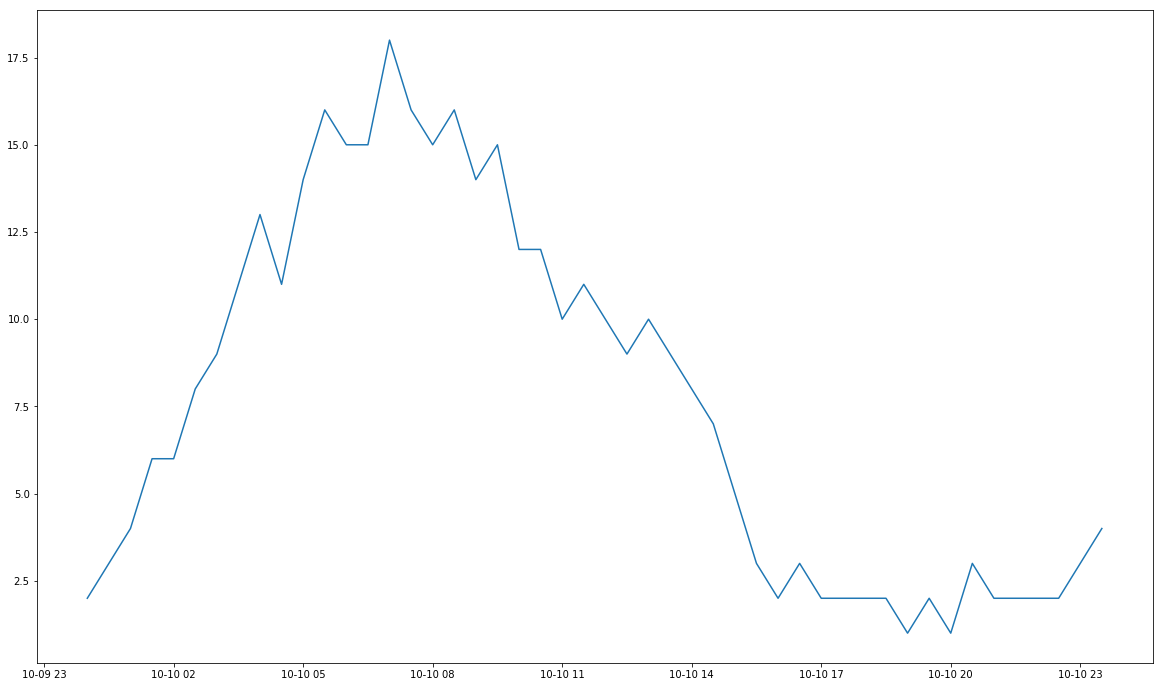

67
深圳彩虹城充电站


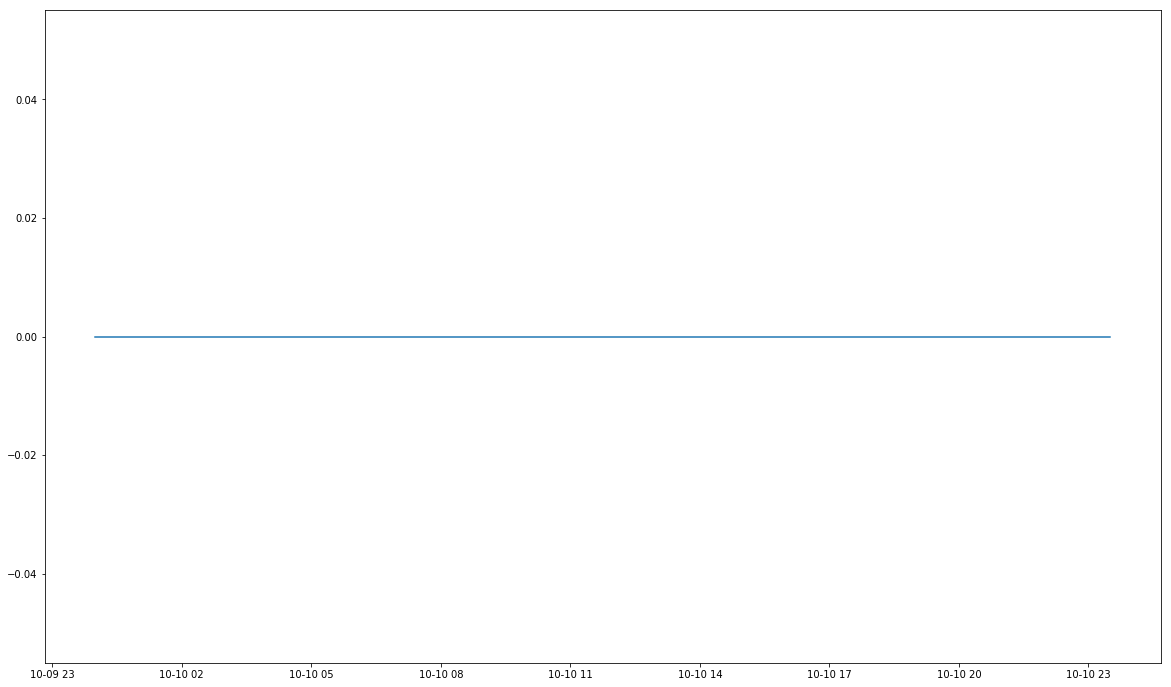

In [86]:
timeOfDay = create_timeOfDay(test_date, timestamp)
for index, station in enumerate(shenzhen_station_list_copylist):
    plt.figure(10, figsize=(20,12))
    avg_timeOfPower = get_avg_timeOfPower(station, day_range, timestamp)
    print(index)
    print(station.name)
    plt.plot(timeOfDay, avg_timeOfPower)
    plt.show()

In [448]:
print(shenzhen_station_list_copylist[0].pills[0].pricedesc)

电费:00:00~07:00:0.3044,07:00~09:00:0.7484,09:00~11:30:1.1009,11:30~14:00:0.7484,14:00~16:30:1.1009,16:30~19:00:0.7484,19:00~21:00:1.1009,21:00~23:00:0.7484,23:00~24:00:0.3044;服务费:00:00~07:00:0.7000,07:00~09:00:0.7000,09:00~11:30:0.7000,11:30~14:00:0.7000,14:00~16:30:0.7000,16:30~19:00:0.7000,19:00~21:00:0.7000,21:00~23:00:0.7000,23:00~24:00:0.7000


In [438]:
for index, station in enumerate(shenzhen_station_list):
    print(index)
    print(station.name)

0
深圳水木丹华充电站
1
深圳天安国际大厦充电站
2
深圳联泰大厦充电站
3
深圳南山书城充电站
4
深圳园博园管理处充电站
5
深圳京基晶都酒店充电站
6
深圳百仕达三期充电站
7
深圳书城中心城充电站
8
深圳城市管理局充电站
9
深圳大冲都市花园充电站
10
深圳创维半导体大厦充电站
11
深圳东方银座广场充电站
12
深圳深业进元大厦充电站
13
深圳天发大厦充电站
14
深圳联美新天地充电站
15
深圳豪方花园充电站
16
深圳春晖苑充电站
17
深圳军威物业充电站
18
深圳熙璟城充电站
19
深圳凤凰大厦充电站
20
深圳公园一号广场充电站
21
深圳长富金茂大厦充电站
22
深圳李朗珠宝产业园充电站
23
深圳华晖云门充电站
24
深圳创维大厦充电站
25
深圳百丽大厦充电站
26
深圳南园枫叶大厦充电站
27
深圳星都豪庭充电站
28
深圳南景新村充电站
29
深圳龙华人人乐充电站
30
深圳深业U中心充电站
31
深圳湾美花园充电站
32
深圳金山大厦充电站
33
深圳万菱New寓充电站
34
深圳鼎新大厦充电站
35
深圳天安天展大厦充电站
36
深圳恒江大厦充电站
37
深圳天安数码时代充电站
38
深圳天安创业园充电站
39
深圳海心汇福园充电站
40
深圳高新奇科技园充电站
41
深圳庄氏大厦充电站
42
深圳景元大厦充电站
43
深圳天御香山二期充电站
44
深圳东方都会大厦充电站
45
深圳湾体育中心充电站
46
深圳东方华都大厦充电站
47
深圳金骐智谷充电站
48
深圳广田集团大厦充电站
49
深圳民生金融大厦充电站
50
深圳汇聚创新园充电站
51
深圳宝立方充电站
52
深圳凯欣园充电站
53
深圳农科商务楼充电站
54
深圳朗山酒店充电站
55
深圳集浩大厦充电站
56
深圳万科公园里充电站
57
深圳博达大厦充电站
58
深圳崇文花园充电站
59
深圳鸿隆世纪广场充电站
60
深圳瑞思国际大厦充电站
61
深圳锦庐花园充电站
62
深圳新豪方大厦充电站
63
深圳豪方现代豪园充电站
64
深圳同富村工业园充电站
65
深圳星河中心大厦充电站
66
深圳华盛盛荟名庭充电站
67
深圳西湖林语充电站
68
深圳雍和园充电站
69
深圳紫悦山充电站
70
深圳海韵大厦充电站
71
深圳南山文体中心充电站
72
深圳祥昭大厦充电

# 6.4 Plot a Period of Days, No Aggregation

In [73]:
#Specify Params
test_date = datetime.datetime(2017, 11, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-480, name=None))
day_range = 28
timestamp = 15

In [74]:
time_list = []
power_list = []
YinXing_IndustrialPark_sta_copy = copy.deepcopy(YinXing_IndustrialPark_sta)
YinXing_IndustrialPark_sta_copy1 = copy.deepcopy(YinXing_IndustrialPark_sta)
YinXing_IndustrialPark_sta_copy, boundary_list_grand = clean_pillUltdata(YinXing_IndustrialPark_sta_copy, test_date, day_range)
YinXing_IndustrialPark_sta_copy1 = map_ultdata(YinXing_IndustrialPark_sta_copy1, boundary_list_grand, timestamp, day_range, aggregated=0)
for _ in range(day_range):
    timeOfDay = create_timeOfDay(test_date)
    time_list.extend(timeOfDay)
    test_date = test_date+datetime.timedelta(days=1)

In [75]:
power_list = [sum(elem) for elem in YinXing_IndustrialPark_sta_copy1.ult_data]

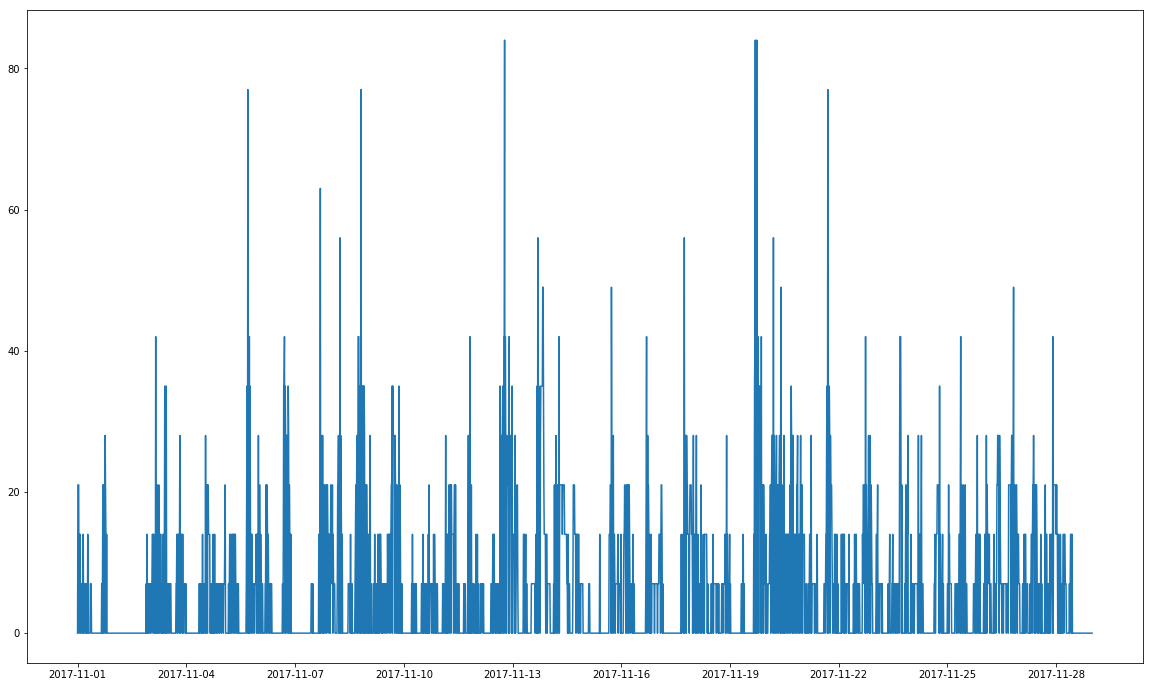

In [76]:
plt.figure(10, figsize=(20,12))
plt.plot(time_list, power_list)
plt.show()